In [8]:
from data import *
from models import *
import pickle
import collections
from sklearn.metrics.pairwise import cosine_similarity

%matplotlib inline 
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 100)    
pd.set_option('display.max_colwidth', 100)    

%load_ext autoreload
%autoreload 2

data_path = os.getcwd() + "/data"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## DATA

In [2]:
kb_file = os.path.join(data_path,'kb_question.csv')
if os.path.exists(kb_file):
    kb_question = pd.read_csv(kb_file)
else:
    kb_question = read_kb(data_path)
    kb_question.to_csv(kb_file , index=False, encoding='utf-8-sig')

In [3]:
# display(kb_question.sample(n=100))

In [4]:
train_question, dev_question, test_question = np.split(kb_question.sample(frac=1), [int(.8*len(kb_question)), int(.9*len(kb_question))])

In [118]:
kb_question_pairs_dfs = {}
for data_type in ['train', 'dev', 'test']:
    filename = data_type+".csv"
    if not os.path.exists(os.path.join(data_path,filename)):
        df = create_pair_data(eval(data_type+"_question"))
        df.to_csv(os.path.join(data_path, filename), index=False, header=False, encoding='utf_8_sig')
#     kb_question_pairs_dfs[data_type] = pd.read_csv(os.path.join(data_path, filename), header=None, names=['s1', 's2', 'score'])
#     kb_question_pairs_dfs[data_type]['label'] = kb_question_pairs_dfs[data_type]['score'].apply(lambda x: int(x/2))

In [119]:
train_pairs, dev_pairs, test_pairs = get_question_pairs(data_path)

processing /home/tingchunyeh/Sentence_sim/data/train.csv ...
** TRAIN DATA : Found 1446025 pairs of train sentences.
processing /home/tingchunyeh/Sentence_sim/data/dev.csv ...
** DEV DATA : Found 148063 pairs of dev sentences.
processing /home/tingchunyeh/Sentence_sim/data/test.csv ...
** TEST DATA : Found 148010 pairs of test sentences.


In [10]:
sentences = np.append(train_pairs['s1'], train_pairs['s2'])

In [11]:
if not os.path.exists(os.path.join(data_path,'word2ind.pickle')):
    word2ind, ind2word = get_word2ind_ind2word(sentences, min_n=5)
    with open( os.path.join(data_path, "word2ind.pickle" ), 'wb') as handle:
        pickle.dump(word2ind, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open( os.path.join(data_path, "ind2word.pickle" ), 'wb') as handle:
        pickle.dump(ind2word, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    word2ind = pickle.load( open(os.path.join(data_path,'word2ind.pickle'), "rb") )
    ind2word = pickle.load( open(os.path.join(data_path,'ind2word.pickle'), "rb") )

In [12]:
wv, default_wv = build_vocab(sentences, "w2v-model.txt")
word_embed_matrix = build_word_embed_matrix(word2ind, pretrained_wordVec="w2v-model.txt")
# word_embed_matrix = build_word_embed_matrix(word2ind, word_embed_dim=150)

Found (5201/5757) words with w2v vectors
vocab size: 5757
Found (5211/5768) words with w2v vectors


In [13]:
test_vec1 = "苏宁 易 购 所 出售 的 商品 均 为 正品 行货 均 来自 正规 渠道 带 正规 机 打 发票 享受 国家 三 包 服务 质量 和 售后 服务 与 门店 完全 相同 请您 放心 选购"
test_vec2 =  "苏宁 易 购 所 出售 的 商品 均 为 正品 行货 请您 放心 选购"
test_vec3 = "有 统一 的 全 国 售后 服务 正品 质量 保证"
test_vec4 = "所有 货物 都 是 正品 请 安心 购买"
test_vec5 = "正规 发票 服务 完全 相同 放心 享受 服务"

## TF-IDF

In [14]:
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer

In [15]:
def TF_IDF_train(txt, min_df=5):
    tf = TfidfVectorizer(norm=None,  min_df=min_df)
    txt_fitted = tf.fit(txt)
    idf = dict(zip(txt_fitted.get_feature_names(), tf.idf_))    
    return txt_fitted, idf

In [16]:
def TF_IDF_predict(s1, s2):
    tfidf1 = txt_fitted.transform([s1])
    tfidf2 = txt_fitted.transform([s2])
    return cosine_similarity(tfidf1, tfidf2)[0][0]

In [18]:
txt_fitted, idf = TF_IDF_train(sentences)
print("Vocabulary size: {}".format(len(idf)))

Vocabulary size: 4768


In [19]:
print(TF_IDF_predict(test_vec1, test_vec2))
print(TF_IDF_predict(test_vec1, test_vec3))
print(TF_IDF_predict(test_vec1, test_vec4))
print(TF_IDF_predict(test_vec1, test_vec5))

0.5627363749263302
0.3259855733346884
0.08960184805345982
0.7085944204351438


## Avg word embedding

In [23]:
def avg_embedding(sentence):
    return np.mean([wv[w] if w in wv else default_wv for w in sentence.split(" ")], axis=0)

In [24]:
def avg_embedding_predict(s1, s2):
    avg_embed1 = avg_embedding(s1)
    avg_embed2 = avg_embedding(s2)
    return cosine_similarity([avg_embed1], [avg_embed2])[0][0]

In [25]:
print(avg_embedding_predict(test_vec1, test_vec2))
print(avg_embedding_predict(test_vec1, test_vec3))
print(avg_embedding_predict(test_vec1, test_vec4))
print(avg_embedding_predict(test_vec1, test_vec5))

0.7395001899548104
0.7664265903248856
0.5822733632456523
0.80507960399557


## IDF word embedding

In [26]:
def IDF_embedding(sentence):
    res = np.zeros(300)
    count = 0
    for w in sentence.split():
        if w in wv:
            cur = wv[w]*idf[w] if w in idf else wv[w] 
        else:
            cur = default_wv
        res = np.add(res, cur)
        count += 1
    return res/count

In [27]:
def IDF_embedding_predict(s1, s2):
    IDF_embed1 = IDF_embedding(s1)
    IDF_embed2 = IDF_embedding(s2)
    return cosine_similarity([IDF_embed1], [IDF_embed2])[0][0]

In [28]:
print(IDF_embedding_predict(test_vec1, test_vec2))
print(IDF_embedding_predict(test_vec1, test_vec3))
print(IDF_embedding_predict(test_vec1, test_vec4))
print(IDF_embedding_predict(test_vec1, test_vec5))

0.7688947760681957
0.8509951993633056
0.6039779244802277
0.8746852736461386


## Evaluation

In [109]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues): 
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def predict(s1_ls, s2_ls, ptype='TF_IDF_predict'):
    preds = []
    for idx in tqdm(range(len(s1_ls))):
        s1, s2 = s1_ls[idx], s2_ls[idx]
        preds.append(eval(ptype)(s1, s2))
    return preds

def get_labels(preds, ths=[0.5, 0.7]):
    labels = []
    for pred in preds:
        if pred<ths[0]:
            labels.append(0)
        elif pred<ths[1]:
            labels.append(1)
        else:
            labels.append(2)
    return labels    
    
def eval_plot(pred_labels, true_labels):
    cnf_matrix = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plot_confusion_matrix(cnf_matrix, classes=[0, 1, 2], title='Confusion matrix, without normalization')
    plt.subplot(1,2,2)
    plot_confusion_matrix(cnf_matrix, classes=[0, 1, 2], title='Confusion matrix', normalize=True)
    plt.subplots_adjust(wspace = 0.2)
    plt.show()
    
    
val_acc_best = -1e10
def evaluate(data_pairs, bsize = 64):
    nli_net.eval()
    correct = 0.0
    global val_acc_best
    
    s1 = data_pairs['s1'] 
    s2 = data_pairs['s2'] 
    target = data_pairs['label'] 
    labels = np.array([])

    for i in tqdm(range(0, len(s1), bsize)):
        # prepare batch
            
        s1_batch, s1_len = get_inds_batch(s1[i: i+bsize], word2ind)
        s2_batch, s2_len = get_inds_batch(s2[i: i+bsize], word2ind)
        s1_batch, s2_batch = Variable(s1_batch.cuda()), Variable(s2_batch.cuda())
        tgt_batch = Variable(torch.LongTensor(target[i: i+bsize])).cuda()

        # model forward
        output = nli_net((s1_batch, s1_len), (s2_batch, s2_len))

        pred = output.data.max(1)[1]
        correct += pred.long().eq(tgt_batch.data.long()).cpu().sum().item()
        labels = np.append(labels, pred.cpu().data.numpy())

    eval_acc = round(100 * correct / len(s1), 2)        
    return labels

def pred_onePair(s1, s2):
    nli_net.eval()
    
    s1_batch, s1_len = get_inds_batch(s1, word2ind)
    s2_batch, s2_len = get_inds_batch(s2, word2ind)
    s1_batch, s2_batch = Variable(s1_batch.cuda()), Variable(s2_batch.cuda())

    # model forward
    output = nli_net((s1_batch, s1_len), (s2_batch, s2_len))
    pred = output.data.max(1)[1]
    return pred.item()

def score_onePair(s1, s2):
    nli_net.eval()
    
    s1_batch, s1_len = get_inds_batch(s1, word2ind)
    s2_batch, s2_len = get_inds_batch(s2, word2ind)
    s1_batch, s2_batch = Variable(s1_batch.cuda()), Variable(s2_batch.cuda())

    # model forward
    output = nli_net((s1_batch, s1_len), (s2_batch, s2_len))
    return output.cpu().data[0][2].item()

def encode_sentence(s):
    nli_net.eval()
    s_batch, s_len = get_inds_batch(s, word2ind)
    s_batch = Variable(s_batch.cuda())
    return nli_net.encode((s_batch, s_len)).cpu().data[0]

def cosScore_onePair(s1, s2):
    arr1 = encode_sentence(s1).reshape(1, -1)
    arr2 = encode_sentence(s2).reshape(1, -1)
    return cosine_similarity(arr1, arr2)[0][0]

### TF-IDF

In [30]:
TFIDF_preds = predict(dev_pairs['s1'], dev_pairs['s2'])

100%|██████████| 148063/148063 [10:46<00:00, 228.85it/s]


overall accuracy: 0.5849807176674794


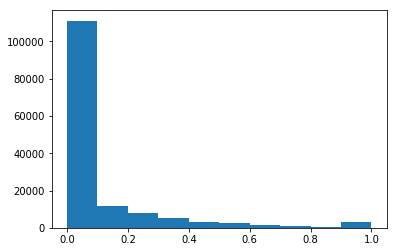

Confusion matrix, without normalization
[[60799  3005  3056]
 [32531  3116 11180]
 [10187  1490 22699]]
Normalized confusion matrix
[[0.90934789 0.04494466 0.04570745]
 [0.69470605 0.06654281 0.23875115]
 [0.29634047 0.04334419 0.66031534]]


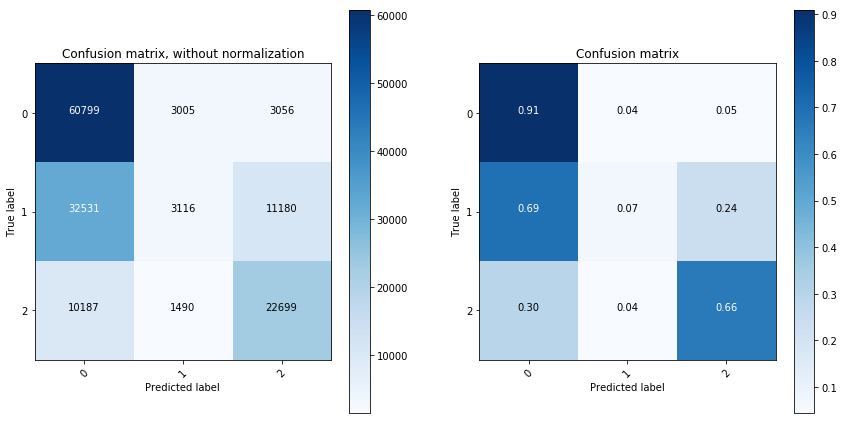

In [116]:
TFIDF_pred_labels = get_labels(TFIDF_preds, ths=[0.01, 0.1])
print("overall accuracy:", float(np.where(TFIDF_pred_labels==dev_pairs['label'])[0].shape[0])/len(TFIDF_pred_labels))
plt.figure()
plt.hist(TFIDF_preds)
plt.show()
eval_plot(TFIDF_pred_labels, dev_pairs['label'])

### avg word embedding

In [45]:
avg_embed_preds = predict(dev_pairs['s1'], dev_pairs['s2'], ptype="avg_embedding_predict")

100%|██████████| 148063/148063 [02:19<00:00, 1063.90it/s]


overall accuracy: 0.5727156683303729


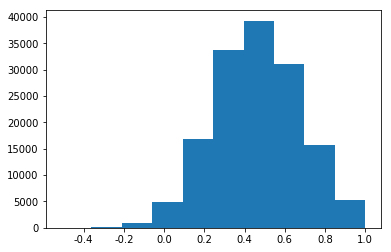

Confusion matrix, without normalization
[[53292  5272  8296]
 [24951  5259 16617]
 [ 5989  2140 26247]]
Normalized confusion matrix
[[0.7970685  0.07885133 0.12408017]
 [0.53283362 0.112307   0.35485938]
 [0.17422039 0.06225273 0.76352688]]


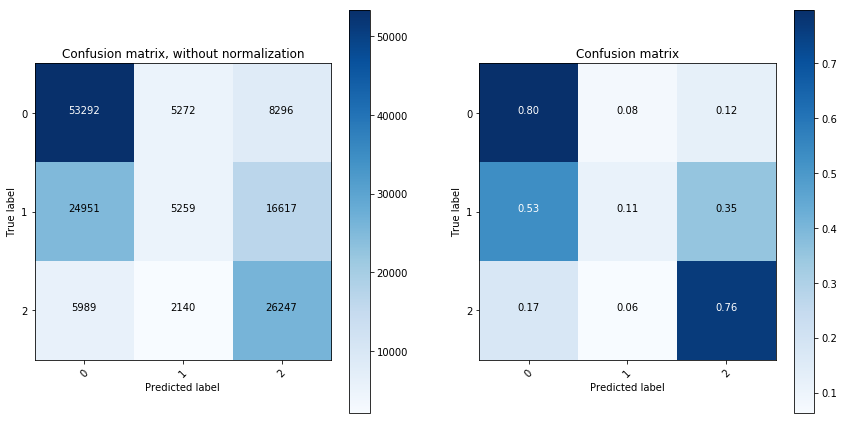

In [115]:
avg_embed_pred_labels = get_labels(avg_embed_preds, ths=[0.5, 0.55])
print("overall accuracy:", float(np.where(avg_embed_pred_labels==dev_pairs['label'])[0].shape[0])/len(avg_embed_pred_labels))
plt.figure()
plt.hist(avg_embed_preds)
plt.show()
eval_plot(avg_embed_pred_labels, dev_pairs['label'])

### IDF word embedding

In [50]:
IDF_embed_preds = predict(dev_pairs['s1'], dev_pairs['s2'], ptype="IDF_embedding_predict")

100%|██████████| 148063/148063 [02:23<00:00, 1032.21it/s]


0.5529335485570331


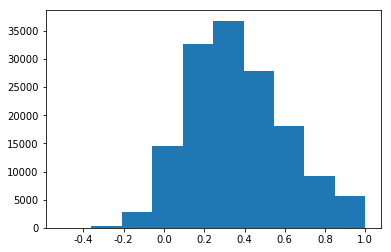

Confusion matrix, without normalization
[[45174 11673 10013]
 [15982  8856 21989]
 [ 3432  3105 27839]]
Normalized confusion matrix
[[0.67565061 0.17458869 0.14976069]
 [0.34129882 0.18912166 0.46957952]
 [0.0998371  0.09032465 0.80983826]]


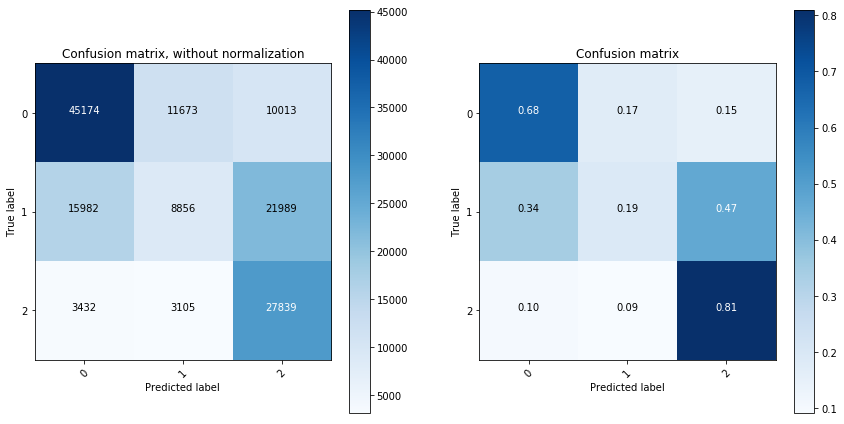

In [114]:
IDF_embed_pred_labels = get_labels(IDF_embed_preds, ths=[0.3, 0.4])
print( float(np.where(IDF_embed_pred_labels==dev_pairs['label'])[0].shape[0])/len(IDF_embed_pred_labels))
plt.figure()
plt.hist(IDF_embed_preds)
plt.show()
eval_plot(IDF_embed_pred_labels, dev_pairs['label'])

### InferSent Train

In [56]:
from torch import optim

def train_small_epoch(epoch=1, batch_size=64, dpout_embed=0.2, percent=0.1, verbose=False):
    all_costs = []
    tot_costs = []
    logs = []
    correct = 0.0
    nli_net.train()
    permutation = np.random.choice(np.random.permutation(len(train_pairs['s1'])), int(percent*len(train_pairs['s1'])))
    s1 = train_pairs['s1'][permutation]
    s2 = train_pairs['s2'][permutation]
    target = train_pairs['label'][permutation]
    
    for i in range(0, len(s1), batch_size):
#         s1_batch, s1_len = get_batch(s1[i:i+batch_size], wv, default_wv, dpout_embed)
#         s2_batch, s2_len = get_batch(s2[i:i+batch_size], wv, default_wv, dpout_embed)
        
        s1_batch, s1_len= get_inds_batch(s1[i:i+batch_size], word2ind)
        s2_batch, s2_len= get_inds_batch(s2[i:i+batch_size], word2ind)
    
        s1_batch, s2_batch = Variable(s1_batch.cuda()), Variable(s2_batch.cuda())
        tgt_batch = Variable(torch.LongTensor(target[i:i+batch_size])).cuda()
        
        k = s1_batch.size(1)
        output = nli_net((s1_batch, s1_len), (s2_batch, s2_len))
        
        pred = output.data.max(1)[1]
        correct += pred.long().eq(tgt_batch.data.long()).cpu().sum().item()

        # loss
        loss = loss_fn(output, tgt_batch)
        all_costs.append(loss.item())
        tot_costs.append(loss.item())
        

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if verbose and len(all_costs) == 10:
            logs.append('{0};  loss: {1};  accuracy train: {2}'.format(i, 
                            round(np.mean(all_costs), 2), round(100.*correct/(i+k), 2)))
            print(logs[-1])
            all_costs = []
            
    train_acc = round(100 * correct/len(s1), 2)
    train_loss = round(np.mean(tot_costs), 2)
    return train_loss, train_acc  

In [57]:
config_nli_model = {
    'n_words'        :  word_embed_matrix.shape[0],
    'word_emb_dim'   :  300,
    'enc_lstm_dim'   :  256,
    'num_layer'   :  1,
    'dpout_model'    :  0,
    'dpout_fc'       :  0.2,
    'fc_dim'         :  256,
    'bsize'          :  64,
    'n_classes'      :  3,
    'pool_type'      :  'max',
    'encoder_type'   :  'GRUEncoder',
    'use_cuda'       :  True,
    'dpout_embed'    :  0.0,
    'embed_freeze'   :  True,
    'embed_matrix'   :  word_embed_matrix,
}

In [58]:
torch.manual_seed(10)
np.random.seed(10)

### Train Playground

In [59]:
# from models import *
# nli_net = NLINet(config_nli_model)
# print(nli_net)
# # loss 
# weight = torch.FloatTensor(3).fill_(1)
# loss_fn = nn.CrossEntropyLoss(weight=weight)
# loss_fn.size_average = False

# # optimizer
# parameters = filter(lambda p: p.requires_grad, nli_net.parameters())
# optimizer = optim.Adam(parameters, lr=0.005)

# # cuda 
# torch.cuda.manual_seed(10)
# torch.cuda.set_device(0)
# nli_net.cuda()
# loss_fn.cuda()

In [60]:
# percent = 0.01
# batch_size = 64
# dpout_embed = 0.2

# nli_net.train()
# permutation = np.random.choice(np.random.permutation(len(train['s1'])), int(percent*len(train['s1'])))
# s1 = train['s1'][permutation]
# s2 = train['s2'][permutation]
# target = train['label'][permutation]

# for stidx in range(0, len(s1), batch_size):
# #     s1_batch, s1_len = get_batch(s1[stidx:stidx+batch_size], wv, default_wv, dpout_embed)
# #     s2_batch, s2_len = get_batch(s2[stidx:stidx+batch_size], wv, default_wv, dpout_embed)
    
#     s1_batch2, s1_len2= get_inds_batch(s1[stidx:stidx+batch_size], word2ind)
#     s2_batch2, s2_len2= get_inds_batch(s2[stidx:stidx+batch_size], word2ind)
    


#     s1_batch2, s2_batch2 = Variable(s1_batch2.cuda()), Variable(s2_batch2.cuda())
#     tgt_batch = Variable(torch.LongTensor(target[stidx:stidx+batch_size])).cuda()
#     k = s1_batch.size(1)
#     output = nli_net((s1_batch2, s1_len2), (s2_batch2, s2_len2))


#     pred = output.data.max(1)[1]
    
#     # loss
#     loss = loss_fn(output, tgt_batch)


#     optimizer.zero_grad()
#     loss.backward()
#     print(nn.utils.clip_grad_norm_(nli_net.parameters(), 1.0, norm_type=2))
#     optimizer.step()
    
# #     for p in parameters:
# #         print(p.grad.norm())

### Find Best Parameters

In [ ]:
lrs = []
hidden_sizes = []
train_losses = []
train_accs = []
for i in range(100):
    lr = 10**np.random.uniform(-1, -4.5)
    hidden_size = np.random.choice([128, 256, 512])
    lrs.append(lr)
    hidden_sizes.append(hidden_size)
    
    config_nli_model['enc_lstm_dim'] = int(hidden_size)
    from models import *
    nli_net = NLINet(config_nli_model)
    optimizer = optim.Adam(nli_net.parameters(), lr=lr)
    weight = torch.FloatTensor(3).fill_(1)
    loss_fn = nn.CrossEntropyLoss(weight=weight)
    loss_fn.size_average = False
    
    nli_net.cuda()
    loss_fn.cuda()
    for i in range(10):
        train_loss, train_acc  = train_small_epoch(1, batch_size=64, dpout_embed=0.2, percent=0.01)
        print("lr: {};  hidden_size: {};  train_loss: {};  train_acc: {}".format(round(lr,5), hidden_size, train_loss, train_acc))
    print("-"*100)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

### InferSent Eval

In [62]:
model_name = "model_1"
params = pickle.load( open(os.path.join("saved_model", model_name, "config.pickle"), "rb"))
word2ind = pickle.load( open(os.path.join(data_path,'word2ind.pickle'), "rb") )
ind2word = pickle.load( open(os.path.join(data_path,'ind2word.pickle'), "rb") )
word_embed_matrix = build_word_embed_matrix(word2ind, pretrained_wordVec="w2v-model.txt")

Found (5211/5768) words with w2v vectors


In [86]:
config_nli_model = {
    'n_words'        :  word_embed_matrix.shape[0],
    'word_emb_dim'   :  word_embed_matrix.shape[1],
    'enc_lstm_dim'   :  params.enc_lstm_dim,
    'num_layer'      :  params.num_layer,
    'dpout_model'    :  params.dpout_model,
    'dpout_fc'       :  params.dpout_fc,
    'fc_dim'         :  params.fc_dim,
    'bsize'          :  params.batch_size,
    'n_classes'      :  params.n_classes,
    'pool_type'      :  params.pool_type,
    'encoder_type'   :  params.encoder_type,
    'use_cuda'       :  params.use_cuda,
    'dpout_embed'    :  params.dpout_embed,
    'embed_freeze'   :  params.embed_freeze,
    'embed_matrix'   :  word_embed_matrix,
}


In [87]:
torch.cuda.set_device(0)
np.random.seed(10)
torch.manual_seed(10)
torch.cuda.manual_seed(10)

In [101]:
nli_net = NLINet(config_nli_model)
nli_net.load_state_dict(torch.load(os.path.join("saved_model", model_name, model_name)))
nli_net.cuda()
print(nli_net)

NLINet(
  (embed): Embedding(5769, 300)
  (embed_dropout): Dropout(p=0.1)
  (encoder): GRUEncoder(
    (enc_lstm): GRU(300, 256, bidirectional=True)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.2)
    (1): Linear(in_features=2048, out_features=256, bias=True)
    (2): Tanh()
    (3): Dropout(p=0.2)
    (4): Linear(in_features=256, out_features=3, bias=True)
    (5): Softmax()
  )
)


In [110]:
eval_labels = evaluate(dev_pairs, bsize = 64)

100%|██████████| 2314/2314 [00:37<00:00, 61.87it/s]


0.8895200016209316
Confusion matrix, without normalization
[[61970  3500  1390]
 [ 4593 38893  3341]
 [ 1551  1983 30842]]
Normalized confusion matrix
[[0.9268621  0.05234819 0.02078971]
 [0.09808444 0.83056783 0.07134773]
 [0.04511869 0.05768559 0.89719572]]


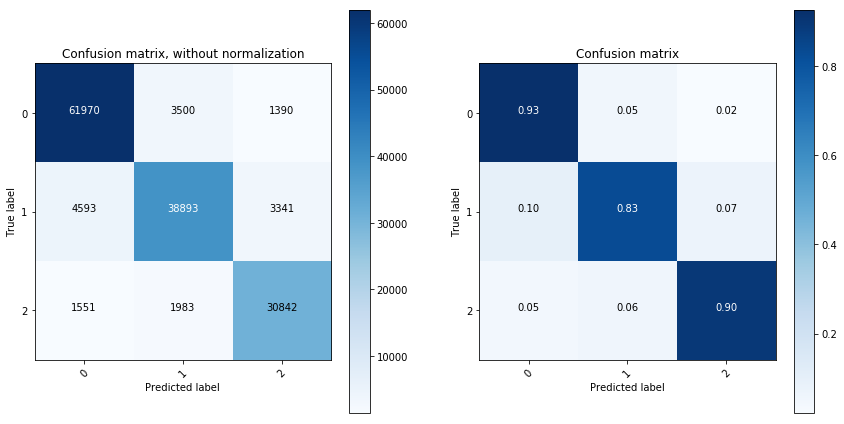

In [112]:
print( float(np.where(eval_labels==dev_pairs['label'])[0].shape[0])/len(eval_labels))
eval_plot(eval_labels, dev_pairs['label'])

## Error Analysis

In [121]:
inds = np.where((eval_labels==2) & (dev_pairs['label']==2))[0]
for ind in inds:
    print(dev_pairs['s1'][ind],"  ", dev_pairs['s2'][ind])

电磁炉 我 能 买 2件    电磁炉 我 能 买 2件
我 买 冰箱 有 赠品 我 没收到    买 有 赠品 送
我 买 冰箱 有 赠品 我 没收到    赠品 没有 给 发货 过来
我 买 冰箱 有 赠品 我 没收到    物流 问时间 问时间 给我 送 贷 没有 赠品
我 买 冰箱 有 赠品 我 没收到    到底 问时间 赠品 赠品
我 买 冰箱 有 赠品 我 没收到    手机 到 赠品 怎么 没收到
我 买 冰箱 有 赠品 我 没收到    我 买 油烟机 送 美的 烤箱 是 和 货 一起 送来
我 买 冰箱 有 赠品 我 没收到    我 买 东西 到 但是 赠品 为什么 没有
我 买 冰箱 有 赠品 我 没收到    我 买 冰箱 有 赠品 我 没收到
我 买 冰箱 有 赠品 我 没收到    我 赠品 蓝 牙音 响
我 买 冰箱 有 赠品 我 没收到    赠品 问时间 能 到
我 买 冰箱 有 赠品 我 没收到    套餐 写 着 有 赠品 实际 没有 到
我 买 冰箱 有 赠品 我 没收到    我 lg 商品 当时 承诺 赠品 问时间 发货
我 买 冰箱 有 赠品 我 没收到    赠品 没收到 怎么
我 买 冰箱 有 赠品 我 没收到    我 订单 你 给我 赠品
我 买 冰箱 有 赠品 我 没收到    我 买 商品 送 赠品 怎么 没有 送
我 买 冰箱 有 赠品 我 没收到    赠品 我 没收到
我 买 冰箱 有 赠品 我 没收到    赠品 和 手机 一起 发货
我 买 冰箱 有 赠品 我 没收到    我 订单 有 赠品
我 买 冰箱 有 赠品 我 没收到    好评 晒单 赠品 还不 给
我 买 冰箱 有 赠品 我 没收到    我 赠品 没有 给我
易付宝 余额 提现 转账 有 手续费    转账 给 别人 有 手续费
易付宝 余额 提现 转账 有 手续费    转账 有 手续费
易付宝 余额 提现 转账 有 手续费    任性付 充值 转账 要 手续费 不
易付宝 余额 提现 转账 有 手续费    转账 有 手续费 没有
易付宝 余额 提现 转账 有 手续费    零钱宝 提现 要 手续费
易付宝 余额 提现 转账 有 手续费    易付宝 余额 提现 转账 有 手续费
消费者 商品 确认 到 有 问时间 评价   

我 任性贷 能 注销    怎么 注销 掉 或 关闭 任性贷
我 任性贷 能 注销    我 要 注销 任性贷 账号
我 任性贷 能 注销    能 把 任性贷 给 注销
我 任性贷 能 注销    怎么 取消 任性贷
我 任性贷 能 注销    我 任性贷 能 注销
我 任性贷 能 注销    苏宁 任性贷 不用 能 注销
买 货品 替换 直接 换 新机    货品 替换 是
买 货品 替换 直接 换 新机    我 了解 货品 替换 质保
买 货品 替换 直接 换 新机    买 货品 替换 我 不 小心 弄 坏的 用
买 货品 替换 直接 换 新机    买 货品 替换 直接 换 新机
我 准备 那里 买 商品 要 开 发票 怎么 开    我 准备 那里 买 商品 要 开 发票 怎么 开
我 准备 那里 买 商品 要 开 发票 怎么 开    线上 买 手机 有 发票
我 准备 那里 买 商品 要 开 发票 怎么 开    商家商品 能 开 发票
我 准备 那里 买 商品 要 开 发票 怎么 开    在 买 华为 手机 开 发票
我 准备 那里 买 商品 要 开 发票 怎么 开    线上 买 要 机 打 发票 怎么 设置
我 准备 那里 买 商品 要 开 发票 怎么 开    店 支付 能 给 发票
我 准备 那里 买 商品 要 开 发票 怎么 开    你 怎么 开 发票
苏宁 v 购 预约 能 取消    苏宁 v 购 预约 能 取消
为什么 我 订单 莫名其妙 变成 退换货    为什么 我 订单 莫名其妙 变成 退换货
为什么 我 订单 莫名其妙 变成 退换货    订单 为什么 直接 取消
为什么 我 订单 莫名其妙 变成 退换货    我 订单 被 取消 怎么 处理
理财 预约 能 约 到    问题 说来 简 但 麻烦 要 注销 任性付
理财 预约 能 约 到    任性付 不能 注销 能 关闭
理财 预约 能 约 到    我 任性付 是 联系 你 给 注销
理财 预约 能 约 到    任性付 能 关闭 冻结
理财 预约 能 约 到    我 账号 有 任性付 冻结
理财 预约 能 约 到    开 任性付 账号 怎么 能 注销
理财 预约 能 约 到    怎么 注销 掉 或 关闭 任性付
理财 预约 能 约 到    我 要 注销 

问地点 商品 不 需 买 材料 只是 底座 安装 安装 需 收费    安装 49寸 电视机 支架 价格 是 多少
问地点 商品 不 需 买 材料 只是 底座 安装 安装 需 收费    一 楼 没有 高空作业 服务
问地点 商品 不 需 买 材料 只是 底座 安装 安装 需 收费    商品 安装 材料 有 哪些
问地点 商品 不 需 买 材料 只是 底座 安装 安装 需 收费    我 先知 道 收 价格 在 装
问地点 商品 不 需 买 材料 只是 底座 安装 安装 需 收费    我 有 材料 安装 不 收 价格
问地点 商品 不 需 买 材料 只是 底座 安装 安装 需 收费    现在 联系 上门 安装 安装 要 收费
问地点 商品 不 需 买 材料 只是 底座 安装 安装 需 收费    商品 安装 收费
问地点 商品 不 需 买 材料 只是 底座 安装 安装 需 收费    免费 安装 是什么
问地点 商品 不 需 买 材料 只是 底座 安装 安装 需 收费    安装 价格 是否 会 变动
问地点 商品 不 需 买 材料 只是 底座 安装 安装 需 收费    我 买 海信 商品 安装 是 免费
问地点 商品 不 需 买 材料 只是 底座 安装 安装 需 收费    有 安装 收费 标准 单
问地点 商品 不 需 买 材料 只是 底座 安装 安装 需 收费    安装 是否 收 材料费
问地点 商品 不 需 买 材料 只是 底座 安装 安装 需 收费    为什么 要 安装 费
问地点 商品 不 需 买 材料 只是 底座 安装 安装 需 收费    问地点 商品 不 需 买 材料 只是 底座 安装 安装 需 收费
问地点 商品 不 需 买 材料 只是 底座 安装 安装 需 收费    刚 物流 上门 是 免费 安装
问地点 商品 不 需 买 材料 只是 底座 安装 安装 需 收费    安装 收费
生产日期 不 告诉 我 怎么 买    能 告诉 我 生产日期
生产日期 不 告诉 我 怎么 买    保质期 问时间
生产日期 不 告诉 我 怎么 买    现在 买 买 牛奶 保质期 有 问时间
生产日期 不 告诉 我 怎么 买    生产日期 是 近
生产日期 不 告诉 我 怎么 买    有效期 问时间
生产日期 不 告诉 我 怎么 买    是

发票 问时间 开 出 来    我 才 到 商品 找 半天 没有 看到 发票
发票 问时间 开 出 来    订单 发票 为什么 我 没有 到
发票 问时间 开 出 来    买 两个 商品 都 没有 发票
发票 问时间 开 出 来    我 发票 一直 没有 给我
发票 问时间 开 出 来    我 问时间 买 手机 到 没有 发票
发票 问时间 开 出 来    为什么 没有 发票
发票 问时间 开 出 来    我 买 商品 当时 没有 发票
发票 问时间 开 出 来    我 买 油烟机 没有 给 发票
发票 问时间 开 出 来    已经 安装 没有 发票
发票 问时间 开 出 来    财务 要 发票 做 账 发票 还不 给我
发票 问时间 开 出 来    我 发票
发票 问时间 开 出 来    冰箱 到 发票 怎么 没有
发票 问时间 开 出 来    发票 问时间 寄送
发票 问时间 开 出 来    我 发票 没有 到
发票 问时间 开 出 来    发票 是否 到 时 取 手机 一起 取 发票
发票 问时间 开 出 来    问时间 份 买 东西 为什么 不 给 开 发票
我 今 早 零钱宝 转出 三百 到 交通 银行卡 没有 到账 能 帮 查 下    零钱宝 提现 到 银行卡 问时间
我 今 早 零钱宝 转出 三百 到 交通 银行卡 没有 到账 能 帮 查 下    零钱 负责 问时间 转出 问时间 收益 是 发放
我 今 早 零钱宝 转出 三百 到 交通 银行卡 没有 到账 能 帮 查 下    我 转出 零钱宝 为什么 一直 在 确认
我 今 早 零钱宝 转出 三百 到 交通 银行卡 没有 到账 能 帮 查 下    零钱宝 提现 100元 现在 没有 到账
我 今 早 零钱宝 转出 三百 到 交通 银行卡 没有 到账 能 帮 查 下    我 问时间 从 零钱宝 转 款 到 汉口 银行 300元 价格 怎么 没有 到账 没有 记录
我 今 早 零钱宝 转出 三百 到 交通 银行卡 没有 到账 能 帮 查 下    零钱宝 转出 不是 半 小时 到账 都 六七个 小时
我 今 早 零钱宝 转出 三百 到 交通 银行卡 没有 到账 能 帮 查 下    我有 一笔 从 零钱宝 里 提现 价格 一直 没有 到账
我 今 早 零钱宝 转出 

我 现在 退换货    故障 退换货 流程
我 现在 退换货    买 大 买 小 商品 都 没有 拆 是否 能 退换货
我 现在 退换货    我 退换货 能 换 其他 商品
我 现在 退换货    我 买 5s 没收到 前 能 退换货
我 现在 退换货    手里 故障 负责 退换货
v 2 会员 能 用 苏宁帮 客 什么 权益    v 2 会员 能 用 苏宁帮 客 什么 权益
我 价格 退换货 少了    退款 怎么 只 退换货 一 部分
我 价格 退换货 少了    我 价格 退换货 少了
我 价格 退换货 少了    退换货 金额 故障
我 弄 提前 还款 为什么 还款 状态 还是 说 还款    我 弄 提前 还款 为什么 还款 状态 还是 说 还款
退换货 申请 问时间 能 受理    我 退换货 申请 成功 问时间 师傅 才 上门 取件
退换货 申请 问时间 能 受理    怎么 没有 退换货 成功
退换货 申请 问时间 能 受理    你 看下 我 单子 审核
退换货 申请 问时间 能 受理    问时间 不能 赠品 去 办 退换货 单 你 受理 下 谢谢
退换货 申请 问时间 能 受理    拍 错 麻烦 退款 申请 通过 下 谢谢
退换货 申请 问时间 能 受理    我 是否 没有 退换货 成功
退换货 申请 问时间 能 受理    我 退换货 申请 是 问时间 来 取
退换货 申请 问时间 能 受理    我 退换货 给 你 说 你 申请
退换货 申请 问时间 能 受理    自助 申请 退换货 处理 时
退换货 申请 问时间 能 受理    关于 退换货 事 怎么 没有 人 来 取
退换货 申请 问时间 能 受理    怎么 没有 退换货
退换货 申请 问时间 能 受理    我 货 问时间 退换货
退换货 申请 问时间 能 受理    我 退换货 什么 时 通过
退换货 申请 问时间 能 受理    格力 台 取消 订单 成功 没有
退换货 申请 问时间 能 受理    退换货 申请 问时间 能 受理
退换货 申请 问时间 能 受理    不知道 物流 没有 上门取货
退换货 申请 问时间 能 受理    我 提交 取消 没有 处理 能 及时 处理 下
退换货 申请 问时间 能 受理    问时间 来 拖 机
现在 物流 说 缺货 只

任性付 借款 升级 完成    任性付 升级 几个 月 准备
任性付 借款 升级 完成    任性付 借款 参数 开
任性付 借款 升级 完成    任性付 取 现 关闭
任性付 借款 升级 完成    任性付 有 额度 借 不了 款 一直 在 升级 停止 为什么
怎么 获得 苏宁免 邮 服务    怎么 获得 苏宁免 邮 服务
怎么 获得 苏宁免 邮 服务    自营 70元 商品 怎么 有 运费
怎么 获得 苏宁免 邮 服务    物流 都是 免费
怎么 获得 苏宁免 邮 服务    能 包邮
怎么 获得 苏宁免 邮 服务    买 两个 也要 运费
怎么 获得 苏宁免 邮 服务    第三方 怎么 运费 贵
怎么 获得 苏宁免 邮 服务    选 店 支付 为什么 有 运费
怎么 获得 苏宁免 邮 服务    必须 自营商品 才 负责 邮
怎么 获得 苏宁免 邮 服务    你 不满 86 要 收 运费
怎么 获得 苏宁免 邮 服务    苏宁 所有 商品 都 不 存在 运费
怎么 获得 苏宁免 邮 服务    满 价格 商品 免邮
怎么 获得 苏宁免 邮 服务    是否 买 什么 都 收费
怎么 获得 苏宁免 邮 服务    秒杀 要 运费
怎么 获得 苏宁免 邮 服务    什么 地区 负责 邮
怎么 获得 苏宁免 邮 服务    你 小米 电视机 邮费 怎么 这样 多
怎么 获得 苏宁免 邮 服务    我 自提 怎么 免运费
怎么 获得 苏宁免 邮 服务    价格 怎么 我 加上 运费
我 充 话费 怎么 过 好几分 钟 没收到    我 充值 两次 手机 话费 都 没有 到账
我 充 话费 怎么 过 好几分 钟 没收到    我 手机 话费 充值 没收到 帐 什么 情况
我 充 话费 怎么 过 好几分 钟 没收到    充值 话费 怎么 没有 到账
我 充 话费 怎么 过 好几分 钟 没收到    我 价格 扣 话费 为什么 没有 到账
我 充 话费 怎么 过 好几分 钟 没收到    我有 冲 话费 订单 过 48小时 没有 到账
我 充 话费 怎么 过 好几分 钟 没收到    充值 话费 一直 未 到账
我 充 话费 怎么 过 好几分 钟 没收到    问时间 给 别人 充 话费 价格 被 扣 但是 到 现在 都 没收到
我 充 话费 怎么

解释 不了 我 弄 退换货    破损 我 要 退换货
解释 不了 我 弄 退换货    解释 不了 我 弄 退换货
解释 不了 我 弄 退换货    激活 能 无理由 退换货
解释 不了 我 弄 退换货    机器 有 外观 损坏 我 要 换
解释 不了 我 弄 退换货    尺寸 不合 适 退换货
解释 不了 我 弄 退换货    买 不满意 能 退换货
解释 不了 我 弄 退换货    2019748920 能 退换货
解释 不了 我 弄 退换货    退换货 一台 留 一台
解释 不了 我 弄 退换货    我 问时间 买 iphone 用 快 两个 礼拜 结果 发现 故障 怎么 退换货
解释 不了 我 弄 退换货    买 大 买 小 商品 都 没有 拆 是否 能 退换货
解释 不了 我 弄 退换货    苹果 手机 激活 能 退换货
解释 不了 我 弄 退换货    要是 退换货 怎么
手机 要是 开封 我 可不 要    手机 要是 开封 我 可不 要
手机 要是 开封 我 可不 要    新买的 手机 不会 被 你 开机 过
平台 券 扣 佣金 网 盟 要 申请 发票 可行    平台 券 扣 佣金 网 盟 要 申请 发票 可行
平台 券 扣 佣金 网 盟 要 申请 发票 可行    平台 券 价格 收取 佣金 网 盟 申请 发票 是否 可行
我 不 想买 你 上面 东西 太 贵    价格 有 便宜
我 不 想买 你 上面 东西 太 贵    调 下 价格 行
我 不 想买 你 上面 东西 太 贵    一次 买 2个 99元 同意 买
我 不 想买 你 上面 东西 太 贵    手机 能 在 便宜点
我 不 想买 你 上面 东西 太 贵    我 朋友 想买 能 六一 价格 我 再 买
我 不 想买 你 上面 东西 太 贵    我 一次性 买 3个 能 优惠 点
我 不 想买 你 上面 东西 太 贵    2个 没有 便宜 贵
我 不 想买 你 上面 东西 太 贵    2578 有 折扣
我 不 想买 你 上面 东西 太 贵    你 便宜点
我 不 想买 你 上面 东西 太 贵    能 给我 优惠
我 不 想买 你 上面 东西 太 贵    我 次 买 便宜
我 不 想买 你 上面 东西 太 贵    现在 买 会 降
我 不 想买 你 

怎么 申请 任性付 解冻    任性付 账户 冻结
怎么 申请 任性付 解冻    我 解冻 任性付 怎么 流程
怎么 申请 任性付 解冻    我 任性付 被 冻结 什么 方式 能 解冻
怎么 申请 任性付 解冻    冻结 任性付 问时间 能 解冻
怎么 申请 任性付 解冻    我 任性付 被 冻结 能 申请 解冻 不
怎么 申请 任性付 解冻    我 任性付 冻结 怎么 解冻
怎么 申请 任性付 解冻    我 任性付 冻结 怎么 能 解冻
怎么 申请 任性付 解冻    任性付 冻结 怎么
怎么 申请 任性付 解冻    任性付 都 完 能 解冻 重新 用
怎么 申请 任性付 解冻    我 任性付 消费 参数 被 冻结 很 长 时 怎么 解冻
怎么 申请 任性付 解冻    任性付 怎么 被 冻结
怎么 申请 任性付 解冻    支付 时 发现 任性付 冻结 是什么 情况
怎么 申请 任性付 解冻    能 直接 解冻 任性付
开 任性付 怎么 没有 12期 免息券    买 苹果 8 p 任性付 12期 免息券 能 用
开 任性付 怎么 没有 12期 免息券    开 任性付 怎么 没有 12期 免息券
开 任性付 怎么 没有 12期 免息券    任性付 券 怎么用
开 任性付 怎么 没有 12期 免息券    我 领 两张 12期 免息券 买 什么 东西 能 用
开 任性付 怎么 没有 12期 免息券    苹果 能 12期 任性付 免息 支付
开 任性付 怎么 没有 12期 免息券    我有 五折 任性付 利息 券
开 任性付 怎么 没有 12期 免息券    任性付 免息券 问地点 用
开 任性付 怎么 没有 12期 免息券    有 苹果 6期 或 12期 免息券
开 任性付 怎么 没有 12期 免息券    怎么 获得 免息券
是什么 专卖店    苏宁 专卖店
是什么 专卖店    解释 苏宁 专卖店
是什么 专卖店    是什么 专卖店
放假 物流 停 运    放假 物流 停 运
礼品卡 能 开 什么 发票    怎么 我 买 礼品卡 没有 开 发票
礼品卡 能 开 什么 发票    用 礼品卡 买 是否 有 全额 发票
礼品卡 能 开 什么 发票    买 礼品卡 有 发票
礼品卡 能 开 什么 发票    企业 购 苏宁卡 开

充 话费 怎么 没收到 帐    我 充值 两次 手机 话费 都 没有 到账
充 话费 怎么 没收到 帐    充 话费 怎么 没收到 帐
充 话费 怎么 没收到 帐    我 冲 话费 怎么 还不 到账
充 话费 怎么 没收到 帐    我 充 话费 怎么 过 好几分 钟 没收到
充 话费 怎么 没收到 帐    我有 冲 话费 订单 过 48小时 没有 到账
充 话费 怎么 没收到 帐    为什么 问时间 冲 话费 现在 没有 到账
理财 安全 可靠    理财 是 哪边 担保
理财 安全 可靠    理财 安全 可靠
我 都 不知道 没有 人工    怎么 联系 人工客服
我 都 不知道 没有 人工    怎么 老是 机器人
我 都 不知道 没有 人工    给我 接 人工客服
我 都 不知道 没有 人工    人工 看到 给 回复
我 都 不知道 没有 人工    找 人工
我 都 不知道 没有 人工    订单 客服 在 那里 找
我 都 不知道 没有 人工    人工客服 在么
我 都 不知道 没有 人工    转换 货 通道
我 都 不知道 没有 人工    有 活人 回复
我 都 不知道 没有 人工    来 个人 工 妹妹 和 我 说 话
我 都 不知道 没有 人工    有 人工 没有
我 都 不知道 没有 人工    人工客服 在吗
我 都 不知道 没有 人工    我 要 找 人工客服 反馈 问题
我 都 不知道 没有 人工    更改 人工
我 都 不知道 没有 人工    赶紧 找 能 处理 我 问题 人
我 都 不知道 没有 人工    我 都 不知道 没有 人工
我 都 不知道 没有 人工    我 要 找 人工客服
我 都 不知道 没有 人工    转下 金融 客服
我 都 不知道 没有 人工    几点 有 人工
什么 叫 系统 检测 到 当前 交易 存在 风险 任性付 支付    任性付 系统 说 检测 到 风险
什么 叫 系统 检测 到 当前 交易 存在 风险 任性付 支付    什么 叫 系统 检测 到 当前 交易 存在 风险 任性付 支付
什么 叫 系统 检测 到 当前 交易 存在 风险 任性付 支付    任性付 系统 检测 有 风险
什么 叫 系统 检测 到 当前 交易 存在 风险 任性付 支付    任性付 交易 

问时间 到 全部 是 烂 和 商家 联系 不 回    商品 为什么 有 白色 小 颗粒 申请 售后
问时间 到 全部 是 烂 和 商家 联系 不 回    我 买 遥控器 为什么 着 没反应
问时间 到 全部 是 烂 和 商家 联系 不 回    可是 没反应
问时间 到 全部 是 烂 和 商家 联系 不 回    我 手环 连 不
看上 海信 冰箱 没有 办法 选 货到付款    能 到货 刷机 支付
看上 海信 冰箱 没有 办法 选 货到付款    找 不 到货 到 支付
看上 海信 冰箱 没有 办法 选 货到付款    明明 说 能 货到付款
看上 海信 冰箱 没有 办法 选 货到付款    支付 问时间 到
看上 海信 冰箱 没有 办法 选 货到付款    自营 不 到 支付
看上 海信 冰箱 没有 办法 选 货到付款    能 发货 货 到 在 支付
看上 海信 冰箱 没有 办法 选 货到付款    现在 怎么 不 给 货到付款
看上 海信 冰箱 没有 办法 选 货到付款    买 礼品卡 能 上门 支付
看上 海信 冰箱 没有 办法 选 货到付款    什么 东西 能 货到付款
看上 海信 冰箱 没有 办法 选 货到付款    有货 到 支付 选项
看上 海信 冰箱 没有 办法 选 货到付款    苏宁 不是 能 货到付款
看上 海信 冰箱 没有 办法 选 货到付款    云南白药 牙膏 货到付款
看上 海信 冰箱 没有 办法 选 货到付款    能 货到付款 不
看上 海信 冰箱 没有 办法 选 货到付款    洗衣 液 能 货到付款
看上 海信 冰箱 没有 办法 选 货到付款    为什么 选 不了 货到付款
看上 海信 冰箱 没有 办法 选 货到付款    看上 海信 冰箱 没有 办法 选 货到付款
看上 海信 冰箱 没有 办法 选 货到付款    我 能 货到付款
看上 海信 冰箱 没有 办法 选 货到付款    商品 能 货到付款
看上 海信 冰箱 没有 办法 选 货到付款    自提 能 货到付款
看上 海信 冰箱 没有 办法 选 货到付款    广州市 白云区 太和镇 能 货到付款
后面 家里 没有 人 在 问时间 说 约 问时间 安装    麻烦 给我 派 师傅 装 商品
后面 家里 没有 人 在 问时间 说 约 问时间 安装    安

银行卡 还款 有 限额    银行卡 价格 用 账户 余额
银行卡 还款 有 限额    银行卡 还款 能 用 快捷支付
商家入 驻 流程 填 银行 账号 是 人 账号 不要紧    商家入 驻 走 流程 时 填 个人 银行 账号 可行
商家入 驻 流程 填 银行 账号 是 人 账号 不要紧    商家入 驻 流程 填 银行 账号 是 人 账号 不要紧
商家入 驻 流程 填 银行 账号 是 人 账号 不要紧    商家入 驻 流程 能 填 个人 银行 账号
申请 借款 说 账号 不 存在 是    我 任性贷 准备 还款 它 说 说 我 账户 不 存在
申请 借款 说 账号 不 存在 是    任性贷 点 我 贷款 说 账号 不 存在
申请 借款 说 账号 不 存在 是    申请 借款 说 账号 不 存在 是
申请 借款 说 账号 不 存在 是    我 任性贷 提前 还款 说 账号 不 存在
申请 借款 说 账号 不 存在 是    任性贷 说 账号 不 存在
申请 借款 说 账号 不 存在 是    任性贷 账号 不 存在 是什么 原因
申请 借款 说 账号 不 存在 是    我 任性贷 怎么 帐 号 不 存在
申请 借款 说 账号 不 存在 是    我 开 任性贷 为什么 说 身份证 号 不 存在
申请 借款 说 账号 不 存在 是    为什么 我 任性贷 说 账号 不 存在
申请 借款 说 账号 不 存在 是    任性贷 进入 是 说 账户 不 存在
申请 借款 说 账号 不 存在 是    任性贷 还款 说 帐 号 不 存在
申请 借款 说 账号 不 存在 是    为什么 我 任性贷 帐 号 说 不 存在
我 买 多 不能 便宜    多 买 不能 便宜
我 买 多 不能 便宜    最低价 是 多少
我 买 多 不能 便宜    是否 能 议价
我 买 多 不能 便宜    现在 买 会 降
我 买 多 不能 便宜    都 家 买 什么 优惠 不
我 买 多 不能 便宜    能 在 便宜点
我 买 多 不能 便宜    便宜点
我 买 多 不能 便宜    手机 最 便宜 价格
我 买 多 不能 便宜    我 朋友 想买 能 六一 价格 我 再 买
我 买 多 不能 便宜    你 家 有 优惠
我 买 多 不能 便宜    2578 

申请 任性付 说 人脸 识别 失败    任性付 人脸 识别 不 通过 怎么
申请 任性付 说 人脸 识别 失败    任性付 我 做 人脸 识别 好 多次 不成功 太 郁闷 什么 情况
申请 任性付 说 人脸 识别 失败    申请 任性贷 说 公安 网 无 基准 照片
申请 任性付 说 人脸 识别 失败    为什么 我 支付 脸 老是 失败
申请 任性付 说 人脸 识别 失败    任性付 人脸 识别 为什么 总是 失败
申请 任性付 说 人脸 识别 失败    我 一直 人脸 识别 失败
申请 任性付 说 人脸 识别 失败    我 人脸 识别 开 任性付 为什么 总是 不 通过
申请 任性付 说 人脸 识别 失败    申请 任性付 说 人脸 识别 失败
我 在 问时间 9 日用 零钱宝 转账 到 银行卡 60元 到 现在 没有 到账    在吗 我 零钱宝 转 银行卡 一笔 交易 为什么 没有 到账
我 在 问时间 9 日用 零钱宝 转账 到 银行卡 60元 到 现在 没有 到账    我 两点 多 转出 零钱宝 怎么 没有 到账
我 在 问时间 9 日用 零钱宝 转账 到 银行卡 60元 到 现在 没有 到账    零钱宝 转出 周期 是 问时间
我 在 问时间 9 日用 零钱宝 转账 到 银行卡 60元 到 现在 没有 到账    问时间 问时间 发起 零钱宝 退换货 银行卡 到 现在 都 没有 到账
我 在 问时间 9 日用 零钱宝 转账 到 银行卡 60元 到 现在 没有 到账    零钱 负责 问时间 转出 问时间 收益 是 发放
我 在 问时间 9 日用 零钱宝 转账 到 银行卡 60元 到 现在 没有 到账    我 问时间 在 零钱 宝转 出 价格 到 我 卡 现在 没有 到账
我 在 问时间 9 日用 零钱宝 转账 到 银行卡 60元 到 现在 没有 到账    零钱 负责 转出 申请 成功 但 金额 未 到账
我 在 问时间 9 日用 零钱宝 转账 到 银行卡 60元 到 现在 没有 到账    我 今 早 零钱宝 转出 三百 到 交通 银行卡 没有 到账 能 帮 查 下
我 在 问时间 9 日用 零钱宝 转账 到 银行卡 60元 到 现在 没有 到账    零钱宝 提现 100元 现在 没有 到账
我 在 问时间 9 日用 零钱宝 

我 申请 任性贷 问时间 才 有 答复 谢谢    任性贷 审核 问时间 没有 结果
我 申请 任性贷 问时间 才 有 答复 谢谢    任性贷 审核 长 时 没有 结果
我 申请 任性贷 问时间 才 有 答复 谢谢    我 在 任性贷 都 申请 长 时 怎么 在 审核
我 申请 任性贷 问时间 才 有 答复 谢谢    任性贷 审核 时
我 申请 任性贷 问时间 才 有 答复 谢谢    我 任性贷 审核 问时间 没有 结果
我 申请 任性贷 问时间 才 有 答复 谢谢    为什么 任性 袋 长 时 没反应
我 申请 任性贷 问时间 才 有 答复 谢谢    任性贷 一直 都是 额度 计算
我 申请 任性贷 问时间 才 有 答复 谢谢    我 申请 任性贷 问时间 才 有 答复 谢谢
我 申请 任性贷 问时间 才 有 答复 谢谢    申请 任 贷 好久 能 审核 时
我 申请 任性贷 问时间 才 有 答复 谢谢    申请 任性贷 要 问时间
我 申请 任性贷 问时间 才 有 答复 谢谢    为什么 我 任性贷 申请 单 到 现在 没有 结果
我 申请 任性贷 问时间 才 有 答复 谢谢    任性贷 审批 问时间
我 申请 任性贷 问时间 才 有 答复 谢谢    怎么 我 任性贷 审核 久
我 申请 任性贷 问时间 才 有 答复 谢谢    我 贷款 额度 申请 问时间 没有 动静
我 申请 任性贷 问时间 才 有 答复 谢谢    我 申请 任性贷 都 问时间 怎么 在 审核
我 申请 任性贷 问时间 才 有 答复 谢谢    任性贷 我 已经 审核 四五天
没有 电梯 送 楼    看 能 到 我们 家
没有 电梯 送 楼    能 保存 问地点 都是 送
没有 电梯 送 楼    能 到 我 学校 物流 代收点
没有 电梯 送 楼    小岭村 能 物流
没有 电梯 送 楼    你 负责 送 是 直接 送 上门 还是 只 到 楼下
没有 电梯 送 楼    物流 到 负责 物流 楼
没有 电梯 送 楼    问地点 在 乡下 能 送货上门 不
没有 电梯 送 楼    我 填 订单 问地点 能 送货上门
没有 电梯 送 楼    不 含 车库 三 楼 能 楼
没有 电梯 送 楼    我 住 在 农村 会 给我 到
没有 电梯 送 楼    

额 慢 没有 发货    北京 丰台 问时间 能 到
额 慢 没有 发货    到 潍坊 问时间
额 慢 没有 发货    问时间 问时间 能 到货
额 慢 没有 发货    我 宁波 鄞 州 问时间 能到
额 慢 没有 发货    7 问时间 到 急用 有 小孩
额 慢 没有 发货    长春 问时间 到
我 告诉 师傅 不要 上门 就算 直接 取消 维修 服务    我 告诉 师傅 不要 上门 就算 直接 取消 维修 服务
我 告诉 师傅 不要 上门 就算 直接 取消 维修 服务    我 家 有人 会 修 我 取消 维修 单
垃圾 软件    苏宁 垃圾
垃圾 软件    苏宁 苏宁 垃圾 买 平台
垃圾 软件    垃圾 软件
有 保修 服务    苏宁 自营 商品 负责 售后
有 保修 服务    我 线上 买 手机 有 保证 不
有 保修 服务    有 保修 服务
给我 把 任性付 注销    不 注销 账户 被盗 什么的 用 任性付 价格 你 负责
给我 把 任性付 注销    苏宁 苏宁 任性付 能 注销 掉
给我 把 任性付 注销    注销 下 任性付
给我 把 任性付 注销    我 注销 我 任性付 怎么 弄
给我 把 任性付 注销    注销 掉 能 把 任性付 以前 手机号 删 行
给我 把 任性付 注销    能 把 任性付 参数 注销
给我 把 任性付 注销    任性付 不 小心 注销 能 重新 打开
给我 把 任性付 注销    我 任性付 提前 清 我 注销 帐 户
给我 把 任性付 注销    任性付 冻结 能 用
给我 把 任性付 注销    怎么 注销 任性付 额度
给我 把 任性付 注销    能 永久 冻结 任性付 谢谢
给我 把 任性付 注销    永久 注销 永久 冻结 任性付 都是
给我 把 任性付 注销    上面 说 绑定 苏宁 苏宁 和 开 任性付 注销 不了
给我 把 任性付 注销    永久 冻结 我 苏宁 任性付
给我 把 任性付 注销    理财 预约 能 约 到
给我 把 任性付 注销    最后 一期 清 能 取消 任性付 或 注销
给我 把 任性付 注销    任性付 冻结 和 注销 账户 有 什 不一样
给我 把 任性付 注销    我 把 任性付 里 款 全 是否 能 注销
给我 把 任

我 买 电器 能 晚 一点 发货 不    订单 延 问时间 发货 能
我 买 电器 能 晚 一点 发货 不    我 延迟 物流
我 买 电器 能 晚 一点 发货 不    物流 时 能 延迟
我 买 电器 能 晚 一点 发货 不    我 重新 订 一台 推迟 发货
我 买 电器 能 晚 一点 发货 不    能 延迟 1个月 这样 再 物流
我 买 电器 能 晚 一点 发货 不    把 发货 时 在 修改 下
怎么 更改 评价    怎么 修改 评价
怎么 更改 评价    怎么 更改 评价
怎么 更改 评价    我 修改 下 评价 怎么 弄
怎么 更改 评价    评价 能 修改
公司 是 香港 澳门 台湾 国外 能 在 苏宁入 驻    公司 是 香港 澳门 台湾 国外 能 在 苏宁入 驻
我 不 输 密码 都是 扣 走 危险    我 不 输 密码 都是 扣 走 危险
我 不 输 密码 都是 扣 走 危险    支付 不想 输入 支付 密码 怎么 设置
账户 类型 选 错误 撤销 实名 怎么 弄    账户 类型 选 错误 撤销 实名 怎么 弄
我 任性付 注销 再 开 有 任性付    我 任性付 注销 再 开 有 任性付
我 任性付 注销 再 开 有 任性付    理财 预约 能 约 到
我 任性付 注销 再 开 有 任性付    永久 注销 永久 冻结 任性付 都是
我 任性付 注销 再 开 有 任性付    任性付 能 注销 户口
我 任性付 注销 再 开 有 任性付    我 注销 任性付 怎么 注销
我 任性付 注销 再 开 有 任性付    把 另外 一个帐 号 任性付 注销
我 任性付 注销 再 开 有 任性付    你 看下 我 能 冻结 任性付
我 任性付 注销 再 开 有 任性付    任性付 不能 关闭
我 任性付 注销 再 开 有 任性付    也就是说 我 把 照片 发送 给 你 是否 审核 过 注销 我 任性付 账户
我 任性付 注销 再 开 有 任性付    我 申请 任性付 不用了 能 注销
我 任性付 注销 再 开 有 任性付    任性付 能 关闭 冻结
我 任性付 注销 再 开 有 任性付    我 要 永久 注销 任性付
我 任性付 注销 再 开 有 任性付    任性付 不 小心 注销 能 重新 打开
我 

我 加盟 农村 服务 站点 苏宁 这边    苏宁 苏宁 服务 店 加盟 联系
我 加盟 农村 服务 站点 苏宁 这边    我 加盟 农村 服务 站点 苏宁 这边
怎么 激活 礼品卡    怎么 激活 礼品卡
买 2 支付 1 怎么 下 单买    买二付一 要 怎么 买
买 2 支付 1 怎么 下 单买    买 2 支付 1 怎么 下 单买
买 2 支付 1 怎么 下 单买    买二付一 要 怎么 选
买 2 支付 1 怎么 下 单买    买 2 支付 1 是什么
货物 怎么 给 你    货物 怎么 给 你
货物 怎么 给 你    退换货 问地点 问地点
苏宁云 台 各个 目的 扣 点 情况 是什么    苏宁云 台 各个 目的 扣 点 情况 是什么
苏宁云 台 各个 目的 扣 点 情况 是什么    苏宁云 台 各个 目的 扣 点 是 怎么
苏宁云 台 各个 目的 扣 点 情况 是什么    目 佣金 扣 点 是 多少
我 只有 中国 银行卡 能 支付    我 只有 中国 银行卡 能 支付
我 只有 中国 银行卡 能 支付    支付 能 找 他人 代付
我 只有 中国 银行卡 能 支付    用 易付宝 怎么 添加 不了 银行卡
我 只有 中国 银行卡 能 支付    没有 网银 能 支付
我 只有 中国 银行卡 能 支付    支付 用 易付宝
我 只有 中国 银行卡 能 支付    为什么 商品 不能用 银行卡 或 支付宝 支付
我 只有 中国 银行卡 能 支付    怎么用 银联卡 支付
我 只有 中国 银行卡 能 支付    能 用 支票 支付
我 只有 中国 银行卡 能 支付    要不是 你 支付 过于 单调
能 优惠 点    618 不是 优惠
能 优惠 点    手机 最 便宜 价格
能 优惠 点    赠品 不要 价格 能 优惠
能 优惠 点    我 想买 两台 有 额外 优惠 赠品 之类 的么
能 优惠 点    买 两台 有 优惠
能 优惠 点    现在 买 会 降
能 优惠 点    便宜 200
能 优惠 点    你 便宜点
能 优惠 点    都 家 买 什么 优惠 不
能 优惠 点    能 在 便宜点
能 优惠 点    我 一次性 买 3个 能 优惠 点
能 优惠 点    价格 不能 再 少了
能 优惠

我 买 燃气灶 有人 安装    安装 是 苏宁 还是 奥克斯
我 买 燃气灶 有人 安装    我 安装 怎么 预约
我 买 燃气灶 有人 安装    没有 售后 安装
我 买 燃气灶 有人 安装    安装 万和 热水器 联系 多少
我 买 燃气灶 有人 安装    是否 到 能 安装
返券 能 用 在 买 电器    返券 能 用 在 买 油烟 机上
返券 能 用 在 买 电器    返券 只 能 买 指定 商品
返券 能 用 在 买 电器    返券 能 用 在 买 电器
返券 能 用 在 买 电器    返券 能 用 在 买 商品
问时间 会 从 边 发出 来    我 商品 到哪
问时间 会 从 边 发出 来    我 看下 我 记录 货物 跟踪
问时间 会 从 边 发出 来    查 我 物流 时
问时间 会 从 边 发出 来    能 看 到 货物 追踪
问时间 会 从 边 发出 来    问时间 会 从 边 发出 来
已经 理财 好 问时间 怎么 收益 始终 是 0    理财 问时间 起 息
已经 理财 好 问时间 怎么 收益 始终 是 0    已经 理财 好 问时间 怎么 收益 始终 是 0
已经 理财 好 问时间 怎么 收益 始终 是 0    固守 理财 怎么 没有 说 收益
以为 上次 都是 最低价    而且 我 刚 到 是 便宜 201元 怎么 解释
以为 上次 都是 最低价    买 贵 保价
以为 上次 都是 最低价    我 商品 货 没收到 跌价 300元
以为 上次 都是 最低价    到 现在 1299 便宜 100
以为 上次 都是 最低价    问时间 问时间 买 159 问时间 拼购 149
以为 上次 都是 最低价    买 贵 买 贵
以为 上次 都是 最低价    手机 刚 买 降 有 保价
以为 上次 都是 最低价    强烈 要求 保价
以为 上次 都是 最低价    我 刚 买 又 降 保价
以为 上次 都是 最低价    能 申请 差价
以为 上次 都是 最低价    没有 想到 你 是否 能 保价
以为 上次 都是 最低价    有 保价 问时间 是
以为 上次 都是 最低价    差价 没有 几个 价格 我 能 不要
以为 上次 都是 最低价    怎么 才 买 问时间 降
以为 上次 都是 最低

我 商品 突然 做 不了 饭    我 手机 外 屏 破 怎么 维修
我 商品 突然 做 不了 饭    售后 怎么 安排
我 商品 突然 做 不了 饭    我 商品 突然 做 不了 饭
我 商品 突然 做 不了 饭    显示屏 不能 说 安排 维修 师傅 上门
我 商品 突然 做 不了 饭    怎么 维修
我 商品 突然 做 不了 饭    网 买 海尔 冰箱 刚 一个月 冷冻室 和 软 冷冻室 不 结 冰
我 商品 突然 做 不了 饭    我 问时间 买 手机 为什么 再 关机 状态 下 不能 充满 格
我 商品 突然 做 不了 饭    你 卡 现在 插 手机 里 不显示
我 商品 突然 做 不了 饭    我 去年 买 电饭煲 故障 去 问地点 维修
我 商品 突然 做 不了 饭    要 苹果 售后 能 用
我 商品 突然 做 不了 饭    平板 故障 怎么 处理
我 商品 突然 做 不了 饭    平板电脑 买 不到 2个 月 冲 电线 故障 怎么 整
我 商品 突然 做 不了 饭    小米 平衡 车 不能 激活 是什么 原因
我 商品 突然 做 不了 饭    售后 是 苏宁 直接 负责
我 商品 突然 做 不了 饭    售后 找 谁
我 商品 突然 做 不了 饭    买 2个 多月 九阳 热水瓶 断电 不能 出 水 办法
第三方 怎么 运费 贵    v 4 会员 不是 能 两次 免邮
第三方 怎么 运费 贵    满 价格 商品 免邮
第三方 怎么 运费 贵    秒杀 要 运费
第三方 怎么 运费 贵    买 两个 也要 运费
第三方 怎么 运费 贵    价格 怎么 我 加上 运费
第三方 怎么 运费 贵    是否 买 什么 都 收费
第三方 怎么 运费 贵    你 小米 电视机 邮费 怎么 这样 多
第三方 怎么 运费 贵    能 包邮
第三方 怎么 运费 贵    我 自提 怎么 免运费
第三方 怎么 运费 贵    第三方 怎么 运费 贵
第三方 怎么 运费 贵    选 店 支付 为什么 有 运费
第三方 怎么 运费 贵    你 不满 86 要 收 运费
第三方 怎么 运费 贵    物流 都是 免费
第三方 怎么 运费 贵    怎么 获得 苏宁免 邮 服务
第三方 怎么 运费 贵    什么 地区 负责 邮

不能 优惠    现在 再 进 一台 能 原来 价格
不能 优惠    你 不能 便宜点
不能 优惠    618 不是 优惠
不能 优惠    不 还是 便宜 100
不能 优惠    我 一次性 买 3个 能 优惠 点
不能 优惠    价格 不能 再 少了
不能 优惠    是否 能 议价
不能 优惠    我 买 多 不能 便宜
不能 优惠    是 最 优惠 价格 还是 有 其他 优惠
不能 优惠    能 优惠 点
不能 优惠    说 最 优惠 价格
不能 优惠    你 便宜点
不能 优惠    最低价 是 多少
不能 优惠    便宜 200
不能 优惠    我 不 想买 你 上面 东西 太 贵
不能 优惠    不能 优惠
不能 优惠    再 有 优惠
不能 优惠    不是 200
不能 优惠    多 买 不能 便宜
不能 优惠    会 比 6098 便宜
新会员 专享 大礼包 怎么 领    领 新会员 券 怎么 弄
新会员 专享 大礼包 怎么 领    新会员 优惠 券 怎么 领
新会员 专享 大礼包 怎么 领    新会员 专享 大礼包 怎么 领
新会员 专享 大礼包 怎么 领    新会员 券 是 直接 到 我 账户
新会员 专享 大礼包 怎么 领    怎么 获得 新会员 券
新会员 专享 大礼包 怎么 领    怎么 领 新会员 红包
新会员 专享 大礼包 怎么 领    我 新会员 券 问地点 领
为什么 保价 少 补    为什么 保价 少 补
为什么 保价 少 补    怎么 保价 券 说 少
我 任性贷 额度 为什么 都 没有了    怎么 任性贷 额度 没了
我 任性贷 额度 为什么 都 没有了    任性贷 有 额度 怎么 后来 变 零
我 任性贷 额度 为什么 都 没有了    我 任性贷 额度 怎么 变成 0
我 任性贷 额度 为什么 都 没有了    任性贷 逾期 问时间 被 冻结 还款 问时间 解除 冻结
我 任性贷 额度 为什么 都 没有了    任性贷 我 额度 怎么 零
我 任性贷 额度 为什么 都 没有了    我 任性贷 有 31000 怎么 现在 没有了
我 任性贷 额度 为什么 都 没有了    任性贷 额度 清 零
我 任性贷 额度 为什么 都 没有了    问时间 前 任性贷 有 额度 

我 任性贷 怎么 会 冻结    我 任性贷 为什么 是 零
我 任性贷 怎么 会 冻结    我 任性贷 怎么 说 额度 0
我 任性贷 怎么 会 冻结    我 任性贷 消费 额度 怎么 没有了
我 任性贷 怎么 会 冻结    任性贷 冻结 怎么 解决
我 任性贷 怎么 会 冻结    任性贷 额度 被 冻结
我 任性贷 怎么 会 冻结    我 任性贷 怎么 没有 额度 怎么 回 事儿
我 任性贷 怎么 会 冻结    任性贷 额度 清 零
我 任性贷 怎么 会 冻结    我 任性贷 额度 怎么 突然 没了
我 任性贷 怎么 会 冻结    任性贷 怎么 现在 没有 额度
我 任性贷 怎么 会 冻结    为何 帐 户 说 任性贷 没有 额度
我 任性贷 怎么 会 冻结    有 任性贷 额度 完 价格 额度 变 0
我 任性贷 怎么 会 冻结    我 任性贷 怎么 被 冻结
我 任性贷 怎么 会 冻结    我 不 欠账 为什么 把 我 任性贷 给 关
我 任性贷 怎么 会 冻结    我 任性贷 额度 为什么 都 没有了
我 任性贷 怎么 会 冻结    我 任性贷 为什么 变为 零
预约 安装 联系 多少    我 买 燃气灶 有人 安装
预约 安装 联系 多少    预约 安装 联系 多少
预约 安装 联系 多少    有 安装 师傅 联系 发 我
预约 安装 联系 多少    要 告诉 你 到货 来 安装
预约 安装 联系 多少    麻烦 派 人 来 安装 下 商品
预约 安装 联系 多少    你 能 查到 当时 安装 联系
预约 安装 联系 多少    要 安装 到 时 在 线上 预约
预约 安装 联系 多少    是 苏宁 人 来 装
预约 安装 联系 多少    安装 联系 多少 1
预约 安装 联系 多少    能 问时间 装
预约 安装 联系 多少    安装 要 我 再 联系
预约 安装 联系 多少    上门 安装 打 什么 联系
预约 安装 联系 多少    商品 到 要 安装
预约 安装 联系 多少    安装 是 商家 安装 还是 苏 宁安 装
我 没有 苏宁 物流    是 苏宁 我 物流
我 没有 苏宁 物流    不是 苏宁 自营 为什么 申通 物流
我 没有 苏宁 物流    你 是 自营 还是 当地 发货
我 

我 货 都 没收到 降    问时间 是 问时间 保价 最后 问时间
我 返 现 不想 领 券    我 返 现 不想 领 券
退款 失败 什么 情况    退款 失败 什么 情况
任性付 被 冻结 申诉 解冻    知道 能 解冻 问时间 能 解冻 任性付
任性付 被 冻结 申诉 解冻    我 任性付 已经 完 贷款 问时间 能 解冻
任性付 被 冻结 申诉 解冻    我 任性付 冻结 怎么 申请 解冻
任性付 被 冻结 申诉 解冻    我 因 还款 逾期 任性付 额度 被 冻结 能 恢复 用
任性付 被 冻结 申诉 解冻    任性付 额度 怎么 解冻
任性付 被 冻结 申诉 解冻    我 任性付 要 怎么 解冻
任性付 被 冻结 申诉 解冻    冻结 任性付 问时间 能 解冻
任性付 被 冻结 申诉 解冻    任性付 消费 参数 被 冻结
任性付 被 冻结 申诉 解冻    任性付 要 怎么 解冻
任性付 被 冻结 申诉 解冻    我 任性付 怎么 给 冻结
任性付 被 冻结 申诉 解冻    任性付 都 完 能 解冻 重新 用
任性付 被 冻结 申诉 解冻    任性付 被 冻结 申诉 解冻
任性付 被 冻结 申诉 解冻    我 任性付 被 冻结 什么 方式 能 解冻
任性付 被 冻结 申诉 解冻    我 任性付 消费 参数 被 冻结 很 长 时 怎么 解冻
任性付 被 冻结 申诉 解冻    为什么 冻结 我 任性付
任性付 被 冻结 申诉 解冻    我 任性付 问时间 能够 解冻
任性付 被 冻结 申诉 解冻    任性付 被 冻结 是什么
任性付 被 冻结 申诉 解冻    说 任性付 被 冻结
任性付 被 冻结 申诉 解冻    任性付 冻结 解冻 问题
任性付 被 冻结 申诉 解冻    任性付 被 冻结 为什么
安装 时 能 推迟 到 下 月    问地点 修改 安装 信息
安装 时 能 推迟 到 下 月    商品 安装 要 换 问地点
安装 时 能 推迟 到 下 月    我 安装 联系 能 修改 成 我 老婆 的么
安装 时 能 推迟 到 下 月    安装 联系 能 修改 下
安装 时 能 推迟 到 下 月    安装 时 能 推迟 到 下 月
安装 时 能 推迟 到 下 月    商家 安装 商品 我 延迟 段 时 

任性付 账户 冻结    冻结 任性付 问时间 能 解冻
任性付 账户 冻结    任性付 怎么 被 冻结
任性付 账户 冻结    任性付 消费 参数 被 冻结
我 提前 把 任性贷 贷款 清    任性贷 看不到 账单
我 提前 把 任性贷 贷款 清    我 提前 把 任性贷 贷款 清
我 提前 把 任性贷 贷款 清    任性贷 商品 费 率 计算 方式
我 提前 把 任性贷 贷款 清    我 要 还款 任性贷
我 提前 把 任性贷 贷款 清    问时间 是 任性贷 还款 日 问时间 能 我 手动 还款
我 提前 把 任性贷 贷款 清    怎么 看 我 月 任性贷 账单
我 提前 把 任性贷 贷款 清    任性贷 还款 流程 是什么
正式 会员 运费 券 每个 月 问时间 发    付费 会员 运费 券 是 多少号 发
正式 会员 运费 券 每个 月 问时间 发    正式 会员 运费 券 每个 月 问时间 发
券 抵 费用 会 在 发票 说    券 抵 费用 会 在 发票 说
我 要 注销 易付宝账号    我 注销 易付宝账号 怎么 弄
我 要 注销 易付宝账号    我 把 易付宝 注销 掉
我 要 注销 易付宝账号    易付宝账号 怎么 能 注销
我 要 注销 易付宝账号    我 要 注销 易付宝账号
我 要 注销 易付宝账号    易付宝 账户 不用了 能 注销
我 要 注销 易付宝账号    易付宝 帐 户 问地点 注销
我 要 注销 易付宝账号    易付宝 注销
我 要 注销 易付宝账号    注销 苏宁 金融 账户
我 刚 买 厨房 三件 套 能 预约 物流 时    买 能 不 物流
我 刚 买 厨房 三件 套 能 预约 物流 时    我 问时间 订单 能 修改 物流 生产日期
我 刚 买 厨房 三件 套 能 预约 物流 时    买 明年 预约 物流
我 刚 买 厨房 三件 套 能 预约 物流 时    问时间 家里 没有 人 问时间 物流
我 刚 买 厨房 三件 套 能 预约 物流 时    能 预约 发货 时
我 刚 买 厨房 三件 套 能 预约 物流 时    我 问时间 问时间 要 回老家 问时间 延迟 送
我 刚 买 厨房 三件 套 能 预约 物流 时    麻烦 给我 修改 1229日 物流
我 刚 买 厨房

看下 订单 怎么 只 发 一袋 米    我 电饭煲 发 错 怎么
看下 订单 怎么 只 发 一袋 米    我 买 三袋 物流 说 只有 一袋
看下 订单 怎么 只 发 一袋 米    我 买 三件 衣服 只 到 二件 现在 联系 卖家 没有 人 回复
看下 订单 怎么 只 发 一袋 米    我 东西 怎么 少了
看下 订单 怎么 只 发 一袋 米    买 商品 外机 送 错 怎么
看下 订单 怎么 只 发 一袋 米    东西 我 朋友 到 我 回来 发 现 没有 手提袋
看下 订单 怎么 只 发 一袋 米    看下 订单 怎么 只 发 一袋 米
看下 订单 怎么 只 发 一袋 米    我 买 两个 收纳箱 只 到 你 上面 说 我 已经 签收
看下 订单 怎么 只 发 一袋 米    你 问时间 送 商品 送 错 货
看下 订单 怎么 只 发 一袋 米    我 订单 发 少 电饭煲
到 现在 1299 便宜 100    我 买 你 电热水器 说 是 保价 618 才 买 完 降
到 现在 1299 便宜 100    没几天 降 差价 怎么 补
到 现在 1299 便宜 100    买 冰箱 保价
到 现在 1299 便宜 100    没有 想到 你 是否 能 保价
到 现在 1299 便宜 100    有 保价 问时间 是
到 现在 1299 便宜 100    买 贵 保价
到 现在 1299 便宜 100    能 保价 行
到 现在 1299 便宜 100    强烈 要求 保价
到 现在 1299 便宜 100    刚 买 问时间 商品 没用 降
到 现在 1299 便宜 100    周 降
到 现在 1299 便宜 100    问时间 问时间 买 159 问时间 拼购 149
到 现在 1299 便宜 100    买 贵 买 贵
到 现在 1299 便宜 100    而且 我 刚 到 是 便宜 201元 怎么 解释
到 现在 1299 便宜 100    刚 买 商品 降 怎么
到 现在 1299 便宜 100    怎么 才 买 问时间 降
到 现在 1299 便宜 100    我 不会 过 问时间 又 降
到 现在 1299 便宜 100    买 不够 问时间 降
到 现在 1299 便宜 100    我 刚 

我 要 永久 冻结 我 任性付    能 解除 冻结 或 关闭 任性付
我 要 永久 冻结 我 任性付    怎么 把 我 任性付 冻结
我 要 永久 冻结 我 任性付    苏宁 苏宁 任性付 能 注销 掉
我 要 永久 冻结 我 任性付    关闭 冻结 任性付
我 要 永久 冻结 我 任性付    你 看下 我 能 冻结 任性付
我 要 永久 冻结 我 任性付    我 要 注销 账号 说 我 开 任性付 不能 注销 怎么 关闭 任性付
我 要 永久 冻结 我 任性付    任性付 账户 怎么 注销
怎么 正确 填 税号    怎么 正确 填 税号
为什么 不能 打开 银行 页面 支付    支付 密码 输入 怎么 没反应
为什么 不能 打开 银行 页面 支付    我 怎么用 不 成银联
为什么 不能 打开 银行 页面 支付    支付 时 说 系统 繁忙
为什么 不能 打开 银行 页面 支付    易付宝 密码 老是 输 不到
为什么 不能 打开 银行 页面 支付    怎么 不能 点 击 买
为什么 不能 打开 银行 页面 支付    输入 易付宝 密码 没反应
为什么 不能 打开 银行 页面 支付    支付 页面 跳 转 不 出 来 怎么
为什么 不能 打开 银行 页面 支付    为什么 不能 打开 银行 页面 支付
为什么 不能 打开 银行 页面 支付    我 在 支付 时 不能 输入 银行卡 姓名
为什么 不能 打开 银行 页面 支付    我 用 工行 银行卡 为什么 支付 不了
我 店 实名 审核 被 驳回 怎么 处理    我 店 实名 审核 被 驳回 怎么 处理
易付宝 实名 里 账号 类型 是什么    什么 标准 选 账户 类型
易付宝 实名 里 账号 类型 是什么    账户 类型 怎么 选
易付宝 实名 里 账号 类型 是什么    易付宝 实名 里 账号 类型 是什么
为什么 买 商品 开 不了 增值税发票    增值税发票 没有 到
为什么 买 商品 开 不了 增值税发票    我 开 增值税发票 怎么 弄
为什么 买 商品 开 不了 增值税发票    商品 能 开 抵扣 增值税发票
为什么 买 商品 开 不了 增值税发票    增值税发票 认证 成功 怎么 开具 增值税发票
为什么 买 商品 开 不了 增值税发票    

贷款 问时间 延长    贷款 问时间 延长
我 买 突然 能 充电 怎么    我 买 手机 现在 信号 特别 差
我 买 突然 能 充电 怎么    屏幕 经常 没反应 强制 故障
我 买 突然 能 充电 怎么    音箱 不 响 是
我 买 突然 能 充电 怎么    我 买 商品 我 爸 我 安装 但是 脱水 时 声音 好 大
我 买 突然 能 充电 怎么    申请 售后
我 买 突然 能 充电 怎么    我 买 突然 能 充电 怎么
我 买 突然 能 充电 怎么    我 买 热水器 停机 风扇 声音 超大
我 买 突然 能 充电 怎么    商品 为什么 有 白色 小 颗粒 申请 售后
我 买 突然 能 充电 怎么    我 手环 连 不
我 买 突然 能 充电 怎么    手机 这两天 正常 用 时 会 突然 发 烫
我 买 突然 能 充电 怎么    我 这边 刚才 试 一直 连接 不 无线 网
我 买 突然 能 充电 怎么    现在 没有 办法 充电
我 买 突然 能 充电 怎么    我 买 电脑 键盘 输入 不了 文字
我 买 突然 能 充电 怎么    我 买 遥控器 为什么 着 没反应
我 买 突然 能 充电 怎么    风扇 摇头 没反应
苏宁 入 驻 商家 要 有 哪些 资质 对应 资质 要求 分别 是什么    入 驻 苏宁 什么 资质 要求
苏宁 入 驻 商家 要 有 哪些 资质 对应 资质 要求 分别 是什么    苏宁 入 驻 商家 要 有 哪些 资质 对应 资质 要求 分别 是什么
能 先验 货    能 先验 货
能 先验 货    支付 还是 先验 货
能 先验 货    是否 先验 货 再 给 价格
怎么 说 不 在 本地区 销售    怎么 说 不 在 本地区 销售
怎么 说 不 在 本地区 销售    我 问地点 不 销售 怎么
怎么 说 不 在 本地区 销售    商品 暂不 在 本地 销售
怎么 说 不 在 本地区 销售    我 选 问地点 说 暂不 售 是什么
我 安装 怎么 预约    麻烦 给我 派 师傅 装 商品
我 安装 怎么 预约    麻烦 派 人 来 安装 下 商品
我 安装 怎么 预约    是 你 安装 还是 商家 安装
我 安装 怎么 预约    联系 售后 给我 安装 商品
我 安

我 才 刚 实名 怎么 没有 赠品 券    完成 认证 我 券 怎么 没有 可用
我 才 刚 实名 怎么 没有 赠品 券    我 实名 易付宝 完 事 我 买 发现 没有 15元 无 门槛 券
我 才 刚 实名 怎么 没有 赠品 券    我 实名 没有 15元 无 门槛 券
我 才 刚 实名 怎么 没有 赠品 券    为什么 我 实名 验证 15元 券 没收到
我 才 刚 实名 怎么 没有 赠品 券    我 刚才 弄 实名 送 15 无 门槛 券 怎么 没有 送给 我
我 才 刚 实名 怎么 没有 赠品 券    我 才 刚 实名 怎么 没有 赠品 券
我 才 刚 实名 怎么 没有 赠品 券    为什么 我 新会员 15 红包 没收到
我 才 刚 实名 怎么 没有 赠品 券    为什么 我 认证 没收到 15元 券
我 才 刚 实名 怎么 没有 赠品 券    我 问时间 刚 实名 为什么 没有 券 发货
我 才 刚 实名 怎么 没有 赠品 券    问时间 说 绑 卡 送 券 结果 没有 送
我 才 刚 实名 怎么 没有 赠品 券    我 刚 实名 绑 卡 但是 没有 到 无 门槛 15元 券
我 才 刚 实名 怎么 没有 赠品 券    我 注册 我 注册 实名 新人券 15元 没有 到
我 才 刚 实名 怎么 没有 赠品 券    实名 怎么 没有 我 15元 券
我 才 刚 实名 怎么 没有 赠品 券    实名 注册 会 返 15元 苏宁 券 问时间 没有 到账
我 才 刚 实名 怎么 没有 赠品 券    新会员 注册 有 15 券 我 怎么 没有
我 才 刚 实名 怎么 没有 赠品 券    我 刚 实名 但 没收到 15元 无 门槛 券
我 才 刚 实名 怎么 没有 赠品 券    实名 成功 没有 领 到 券
我 任性贷 额度 怎么 突然 没了    我 任性贷 额度 为什么 都 没有了
我 任性贷 额度 怎么 突然 没了    怎么 任性贷 额度 没了
我 任性贷 额度 怎么 突然 没了    任性贷 额度 怎么 没了
我 任性贷 额度 怎么 突然 没了    我 任性贷 怎么 没有 额度 怎么 回 事儿
我 任性贷 额度 怎么 突然 没了    任性贷 额度 清 零
我 任性贷 额度 怎么 突然 没了    任性贷 可用 额度 

能 把 任性付 参数 注销    把 另外 一个帐 号 任性付 注销
能 把 任性付 参数 注销    给我 把 任性付 注销
能 把 任性付 参数 注销    我 注销 另 说 任性付 必须 注销 你 注销
能 把 任性付 参数 注销    关闭 冻结 任性付
能 把 任性付 参数 注销    我 只 要 任性付 账号 不要 能 注销
能 把 任性付 参数 注销    这样 子 弄 我 用 你 任性付 干什么 注销 掉 去
能 把 任性付 参数 注销    怎么 注销 任性付 账号
能 把 任性付 参数 注销    任性付 不怎么 用 能 冻结
能 把 任性付 参数 注销    申请 冻结 任性付
能 把 任性付 参数 注销    任性付 不能 关闭
能 把 任性付 参数 注销    你 看下 我 能 冻结 任性付
能 把 任性付 参数 注销    我 现在 预约 理 财产 品 到 成交 最 长 多少 时
能 把 任性付 参数 注销    我 要 关闭 注销 任性付 参数
你 付费 会员 返 利 是 返 现金    supper 会员 有 2 返 利 什么 是什么
你 付费 会员 返 利 是 返 现金    super 会员 返 利 百分之2 云钻
你 付费 会员 返 利 是 返 现金    我 参与 返 利 怎么
你 付费 会员 返 利 是 返 现金    你 付费 会员 返 利 是 返 现金
我 开 增值税发票 怎么 弄    增值税发票 没有 到
我 开 增值税发票 怎么 弄    我 开 增值税发票 要 有 什么 资料
我 开 增值税发票 怎么 弄    增值税发票 认证 成功 怎么 开具 增值税发票
我 开 增值税发票 怎么 弄    增值税 怎么 开
我 开 增值税发票 怎么 弄    苹果 手机 能 开 增值税发票
我 开 增值税发票 怎么 弄    为什么 买 商品 开 不了 增值税发票
我 开 增值税发票 怎么 弄    我 开 增值税发票 怎么 弄
我 开 增值税发票 怎么 弄    商品 能 开 抵扣 增值税发票
问时间 到货    问时间 到货
问时间 到货    到 潍坊 问时间
问时间 到货    问时间 能 送 过来
问时间 到货    北京 丰台 问时间 能 到
问时间 到货    定金 商品 在 问时间 发货
问时间 到货    

你 不能 便宜点    手机 最 便宜 价格
你 不能 便宜点    不是 200
你 不能 便宜点    现在 买 会 降
你 不能 便宜点    一次 买 2个 99元 同意 买
你 不能 便宜点    多 买 不能 便宜
商品 物流 和 安装 是 一起    到货 时 不一 起 安装
商品 物流 和 安装 是 一起    问时间 到 安装 师傅 一起 来
商品 物流 和 安装 是 一起    送货上门 加 安装
商品 物流 和 安装 是 一起    商品 物流 和 安装 是 一起
商品 物流 和 安装 是 一起    货 送 上门 顺便 安装
商品 物流 和 安装 是 一起    物流 能 安装
商品 物流 和 安装 是 一起    物流 再 预约 安装
商品 物流 和 安装 是 一起    货 送 到 直接 安装
商品 物流 和 安装 是 一起    我 物流 和 安装 放 问时间
现在 任性付 什么 老 升级    怎么 我 任性付 借 不了 价格
现在 任性付 什么 老 升级    任性付 贷款 为什么 一直 说 升级 状态
现在 任性付 什么 老 升级    为什么 现在 任性付 不能 借款
现在 任性付 什么 老 升级    为什么 任性付 现在 借 不了 款
现在 任性付 什么 老 升级    任性付 怎么 借款 不了
现在 任性付 什么 老 升级    任性付 升级 到 问时间
现在 任性付 什么 老 升级    苏宁 任性付 为何 是 系统 升级 而 不能 用
现在 任性付 什么 老 升级    任性付 问时间 升级 好
现在 任性付 什么 老 升级    任性付 借款 升级 完成
现在 任性付 什么 老 升级    任性付 升级 几个 月 准备
现在 任性付 什么 老 升级    任性付 怎么 现在 说 系统 升级 不能 用
现在 任性付 什么 老 升级    任性付 升级
现在 任性付 什么 老 升级    任性付 借款 参数 开
现在 任性付 什么 老 升级    任性付 取 现 关闭
现在 任性付 什么 老 升级    任性付 提现 升级 到 好久
现在 任性付 什么 老 升级    任性付 借款 能 提现
现在 任性付 什么 老 升级    任性付 最近 怎么 一直 说 系统 升级
现在 任性付 什么 老 升级    我 任性付 怎么

电子发票 怎么 乱 码    电子发票 怎么 乱 码
大米 是 非 转转 基因 的么    大米 是 非 转转 基因 的么
大米 是 非 转转 基因 的么    大米 有 非 转转 基因 的么
ram 是什么    ram 是什么
我有 一张 礼品卡 但是 不知道 现在 能 故障    我 礼品卡 今年 用 不 掉 能 申请 明年 继续
我有 一张 礼品卡 但是 不知道 现在 能 故障    我有 一张 礼品卡 但是 不知道 现在 能 故障
有 弄 注册 苏宁 苏宁 企业差旅 用户 步骤    有 弄 注册 苏宁 苏宁 企业差旅 用户 步骤
我 任性付 问时间 能够 解冻    我 任性付 冻结 怎么 解冻
我 任性付 问时间 能够 解冻    任性付 不 小心 冻结 怎么 解冻
我 任性付 问时间 能够 解冻    我 任性付 被 冻结 能 申请 解冻 不
我 任性付 问时间 能够 解冻    任性付 和 任性贷 被 冻结 能 解冻
我 任性付 问时间 能够 解冻    我 解冻 任性付 怎么 流程
我 任性付 问时间 能够 解冻    能 直接 解冻 任性付
我 任性付 问时间 能够 解冻    任性付 要 怎么 解冻
我 任性付 问时间 能够 解冻    任性付 被 冻结 申诉 解冻
我 任性付 问时间 能够 解冻    我 任性付 冻结 怎么 申请 解冻
我 任性付 问时间 能够 解冻    我 任性付 冻结 怎么 能 解冻
我 任性付 问时间 能够 解冻    我 任性付 怎么 给 冻结
我 任性付 问时间 能够 解冻    我 任性付 问时间 能够 解冻
我 任性付 问时间 能够 解冻    我 任性付 要 怎么 解冻
我 任性付 问时间 能够 解冻    任性付 怎么 被 冻结
我 任性付 问时间 能够 解冻    我 任性付 被 冻结 怎么 能 解冻
我 任性付 问时间 能够 解冻    解冻 任性付 消费 参数
我 任性付 问时间 能够 解冻    我 任性付 因 逾期 还款 能 解冻
我 任性付 问时间 能够 解冻    任性付 账户 冻结
我 任性付 问时间 能够 解冻    任性付 被 冻结 是什么
我 任性付 问时间 能够 解冻    我 任性付 被 冻结 什么 方式 能 解冻
转出 零钱宝 里 价格 有 哪些 方式    转出 零钱宝 里

物流 用 什么 物流    大连 发 什么 物流
物流 用 什么 物流    苏宁派 送 时 哪家 物流
物流 用 什么 物流    是 走 哪个 物流
物流 用 什么 物流    物流 你 特定
物流 用 什么 物流    也是 你 苏宁 发货
物流 用 什么 物流    要求 发 顺丰 能
物流 用 什么 物流    是 发 什么 物流
物流 用 什么 物流    苏宁 自营 是 你 我 物流
物流 用 什么 物流    是 哪个 物流
物流 用 什么 物流    不能 用 圆通 物流
物流 用 什么 物流    是 邮政 对
物流 用 什么 物流    你 发 是什么 物流
物流 用 什么 物流    你 是 自有 物流 的么
我 任性贷 为什么 变为 零    任性贷 怎么 解冻
我 任性贷 为什么 变为 零    任性贷 我 额度 怎么 零
我 任性贷 为什么 变为 零    我 任性贷 可用 额度 怎么 变成 0
我 任性贷 为什么 变为 零    能 解冻 我 任性贷 额度
我 任性贷 为什么 变为 零    任性贷 有 额度 怎么 后来 变 零
我 任性贷 为什么 变为 零    我 任性贷 消费 额度 怎么 没有了
我 任性贷 为什么 变为 零    为什么 我 任性贷 没有 额度
我 任性贷 为什么 变为 零    我 任性贷 没有 额度
我 任性贷 为什么 变为 零    任性贷 可用 额度 怎么 变 0
我 任性贷 为什么 变为 零    我 任性贷 为什么 变为 零
我 任性贷 为什么 变为 零    任性贷 冻结 怎么 解决
我 任性贷 为什么 变为 零    任性贷 怎么 现在 没有 额度
我 任性贷 为什么 变为 零    我 任性贷 冻结 能 解冻
我 任性贷 为什么 变为 零    任性贷 额度 突然 没有了 是 没有 任何 逾期
我 任性贷 为什么 变为 零    任性贷 可用 额度 怎么 成 零
我 任性贷 为什么 变为 零    我 任性贷 额度 怎么 突然 没了
我 任性贷 为什么 变为 零    我 以前 有 任性贷 我 借款 都 清 怎么 没有 额度
我 任性贷 为什么 变为 零    任性贷 账号 因为 逾期 还款 被 冻结 能 解冻
我 任性贷 为什么 变为 零    我 任性贷 额度 为什么 都 没有了
为何 我

线上 买 延迟 物流 最 长 能 延迟 问时间    买 能 不 物流
线上 买 延迟 物流 最 长 能 延迟 问时间    我 买 热水器 处理 下 延期 发货
线上 买 延迟 物流 最 长 能 延迟 问时间    买 明年 预约 物流
线上 买 延迟 物流 最 长 能 延迟 问时间    物流 时 能 延迟
线上 买 延迟 物流 最 长 能 延迟 问时间    因 房子 刚 开始 装修 要 推迟 物流 能
线上 买 延迟 物流 最 长 能 延迟 问时间    我 刚 买 厨房 三件 套 能 预约 物流 时
线上 买 延迟 物流 最 长 能 延迟 问时间    我 买 电器 能 晚 一点 发货 不
线上 买 延迟 物流 最 长 能 延迟 问时间    订单 能 延迟 到 问时间 发货
灰色 没事 黑色 扁    我 买 遥控器 为什么 着 没反应
灰色 没事 黑色 扁    风扇 摇头 没反应
灰色 没事 黑色 扁    问时间 到 全部 是 烂 和 商家 联系 不 回
灰色 没事 黑色 扁    我 买 手机 现在 信号 特别 差
灰色 没事 黑色 扁    我 手环 连 不
灰色 没事 黑色 扁    我 买 电脑 键盘 输入 不了 文字
灰色 没事 黑色 扁    商品 为什么 有 白色 小 颗粒 申请 售后
灰色 没事 黑色 扁    现在 没有 办法 充电
灰色 没事 黑色 扁    音箱 不 响 是
灰色 没事 黑色 扁    可是 没反应
灰色 没事 黑色 扁    申请 售后
灰色 没事 黑色 扁    新买的 电视机 遥控 不能 接收
灰色 没事 黑色 扁    手机 这两天 正常 用 时 会 突然 发 烫
灰色 没事 黑色 扁    灰色 没事 黑色 扁
灰色 没事 黑色 扁    我 买 热水器 停机 风扇 声音 超大
优惠 问时间 开始    优惠 问时间 开始
我 问地点 稍微 改动 下    我 问地点 没有 写 全 提交 怎么 处理
我 问地点 稍微 改动 下    我 冰箱 问地点 能 重新 更换 问地点
我 问地点 稍微 改动 下    我 发货 问地点 更改 通富佳 苑 问时间 楼 204 室
我 问地点 稍微 改动 下    我 问地点 稍微 改动 下
我 问地点 稍微 改动 下    问时间 物流 能 更改 到 问地点
我 

我有 一笔 从 零钱宝 里 提现 价格 一直 没有 到账    零钱 负责 问时间 转出 问时间 收益 是 发放
我有 一笔 从 零钱宝 里 提现 价格 一直 没有 到账    我 问时间 零钱宝 快速 提现 到 现在 没有 到账
我有 一笔 从 零钱宝 里 提现 价格 一直 没有 到账    零钱宝 提现 100元 现在 没有 到账
我有 一笔 从 零钱宝 里 提现 价格 一直 没有 到账    我 今 早 零钱宝 转出 三百 到 交通 银行卡 没有 到账 能 帮 查 下
我有 一笔 从 零钱宝 里 提现 价格 一直 没有 到账    我有 一笔 从 零钱宝 里 提现 价格 一直 没有 到账
我有 一笔 从 零钱宝 里 提现 价格 一直 没有 到账    刚 零钱宝 转 100 出来 没有 到账
我有 一笔 从 零钱宝 里 提现 价格 一直 没有 到账    我 转出 零钱宝 为什么 一直 在 确认
我有 一笔 从 零钱宝 里 提现 价格 一直 没有 到账    零钱宝 一次 最多 转出 价格
我有 一笔 从 零钱宝 里 提现 价格 一直 没有 到账    我 在 问时间 9 日用 零钱宝 转账 到 银行卡 60元 到 现在 没有 到账
我有 一笔 从 零钱宝 里 提现 价格 一直 没有 到账    零钱宝 转出 周期 是 问时间
我有 一笔 从 零钱宝 里 提现 价格 一直 没有 到账    我 问时间 在 零钱 宝转 出 价格 到 我 卡 现在 没有 到账
我有 一笔 从 零钱宝 里 提现 价格 一直 没有 到账    零钱宝 转出 不是 半 小时 到账 都 六七个 小时
我有 一笔 从 零钱宝 里 提现 价格 一直 没有 到账    我 问时间 零钱宝 转出 20000元 怎么 没收到 帐
我有 一笔 从 零钱宝 里 提现 价格 一直 没有 到账    零钱宝 提 价格 为什么 没有 到 不是 30分钟 快速 到账
我有 一笔 从 零钱宝 里 提现 价格 一直 没有 到账    我 零钱宝 有 三次 转 一点 价格 到 银行卡 一直 都 没有 到账
我有 一笔 从 零钱宝 里 提现 价格 一直 没有 到账    零钱宝 提现 到 银行卡 问时间
我有 一笔 从 零钱宝 里 提现 价格 一直 没有 到账    我 问时间 零钱宝 提现 到 现在 没有 到账
我

云钻 被 别人 用    我 优惠 券 被 别人 用 掉
云钻 被 别人 用    云钻 被 别人 用
云钻 被 别人 用    云钻 被 盗用 怎么
我 问时间 问时间 有 500元 转账 怎么 到 现在 没有 到账    问时间 通过 零钱宝 转账 为什么 问时间 没有 到账
我 问时间 问时间 有 500元 转账 怎么 到 现在 没有 到账    我 刚 转 一笔 价格 银行卡 错误 能 退换货 回来
我 问时间 问时间 有 500元 转账 怎么 到 现在 没有 到账    我有 笔 转账 没有 成功会 原 路 返回
我 问时间 问时间 有 500元 转账 怎么 到 现在 没有 到账    我 问时间 17 日用 易付宝 转账 到 银行卡
我 问时间 问时间 有 500元 转账 怎么 到 现在 没有 到账    我 转账 问时间 转 现在 都 没有 到账
我 问时间 问时间 有 500元 转账 怎么 到 现在 没有 到账    转账 到 银行卡 怎么 还不 到账
我 问时间 问时间 有 500元 转账 怎么 到 现在 没有 到账    我 问时间 转 帐 没有 过去 是
我 问时间 问时间 有 500元 转账 怎么 到 现在 没有 到账    我 问时间 转账 到 现在 没有 到账
我 问时间 问时间 有 500元 转账 怎么 到 现在 没有 到账    转账 等待 是什么
我 问时间 问时间 有 500元 转账 怎么 到 现在 没有 到账    交易 号 2016052802866868 转账 很 久 没有 到账
我 问时间 问时间 有 500元 转账 怎么 到 现在 没有 到账    能 查 下 刚 弄 一笔 转账 740元 收款 人 卡 号 是 对的 但 姓名 字 错 对方 现在 没收到
我 问时间 问时间 有 500元 转账 怎么 到 现在 没有 到账    我 问时间 问时间 有 500元 转账 怎么 到 现在 没有 到账
我 问时间 问时间 有 500元 转账 怎么 到 现在 没有 到账    问时间 转账 到 现在 没有 到账
我 问时间 问时间 有 500元 转账 怎么 到 现在 没有 到账    问时间 凌晨 转账 要 问时间 能 到账
我 问时间 问时间 有 500元 转账 怎么 到 现在 没有 到账    我 转账 给 别人 怎么 到 现

多少 楼 安装 要 高空作业 费    多少 楼 安装 要 高空作业 费
多少 楼 安装 要 高空作业 费    现在 联系 上门 安装 安装 要 收费
任性付 人脸 识别 为什么 总是 失败    任性贷 脸 一直 扫 不进去
任性付 人脸 识别 为什么 总是 失败    任性贷 人脸 验证 总是 失败 是 怎么 弄
任性付 人脸 识别 为什么 总是 失败    任性付 人脸 识别 为什么 总是 失败
任性付 人脸 识别 为什么 总是 失败    公安 网 无 基准 照片 怎么 处理
任性付 人脸 识别 为什么 总是 失败    申请 任性付 说 人脸 识别 失败
任性付 人脸 识别 为什么 总是 失败    任性付 为什么 一直 人脸 失败
任性付 人脸 识别 为什么 总是 失败    为什么 我 支付 脸 老是 失败
任性付 人脸 识别 为什么 总是 失败    我 一直 人脸 识别 失败
任性付 人脸 识别 为什么 总是 失败    申请 任性贷 说 公安 网 无 基准 照片
任性付 人脸 识别 为什么 总是 失败    任性付 人脸 识别 不 通过 怎么
任性付 人脸 识别 为什么 总是 失败    我 人脸 识别 开 任性付 为什么 总是 不 通过
任性付 人脸 识别 为什么 总是 失败    为什么 我 人脸 一直 通过 不了
任性付 人脸 识别 为什么 总是 失败    为何 开 任性付 时 支付 脸 总是 失败
任性付 人脸 识别 为什么 总是 失败    任性付 我 做 人脸 识别 好 多次 不成功 太 郁闷 什么 情况
你 不满 86 要 收 运费    必须 自营商品 才 负责 邮
你 不满 86 要 收 运费    买 两个 也要 运费
你 不满 86 要 收 运费    秒杀 要 运费
你 不满 86 要 收 运费    怎么 获得 苏宁免 邮 服务
你 不满 86 要 收 运费    第三方 怎么 运费 贵
你 不满 86 要 收 运费    价格 怎么 我 加上 运费
你 不满 86 要 收 运费    什么 地区 负责 邮
你 不满 86 要 收 运费    选 店 支付 为什么 有 运费
你 不满 86 要 收 运费    自营 70元 商品 怎么 有 运费
你 不满 86 要 收 运费    v 4 会员 不是 能 两次 免邮


零钱宝 问时间 转入 问时间 有 收益    零钱宝 利息 怎么 算
零钱宝 问时间 转入 问时间 有 收益    零钱宝 问时间 转入 问时间 有 收益
零钱宝 问时间 转入 问时间 有 收益    零钱宝 收益 怎么 算
零钱宝 问时间 转入 问时间 有 收益    我 了解 零钱宝 能 有 多少 收益
零钱宝 问时间 转入 问时间 有 收益    零钱宝 问时间 转入 问时间 开始 计息
零钱宝 问时间 转入 问时间 有 收益    问时间 都 问时间 问时间 为什么 零钱宝 没有 收益
怎么 解除 冻结 任性贷    怎么 解除 冻结 任性贷
怎么 解除 冻结 任性贷    任性贷 逾期 问时间 被 冻结 还款 问时间 解除 冻结
怎么 解除 冻结 任性贷    我 任性贷 怎么 被 冻结
怎么 解除 冻结 任性贷    任性贷 额度 被 冻结
怎么 解除 冻结 任性贷    我 任性贷 冻结
撤 场 商 户 能 看到 交易 快照    撤 场 商 户 能 看到 交易 快照
撤 场 商 户 能 看到 交易 快照    交易 快照 有效期 能 用 问时间
你 小米 电视机 邮费 怎么 这样 多    选 店 支付 为什么 有 运费
你 小米 电视机 邮费 怎么 这样 多    满 价格 商品 免邮
你 小米 电视机 邮费 怎么 这样 多    苏宁 所有 商品 都 不 存在 运费
你 小米 电视机 邮费 怎么 这样 多    必须 自营商品 才 负责 邮
你 小米 电视机 邮费 怎么 这样 多    第三方 怎么 运费 贵
你 小米 电视机 邮费 怎么 这样 多    是否 买 什么 都 收费
你 小米 电视机 邮费 怎么 这样 多    什么 地区 负责 邮
你 小米 电视机 邮费 怎么 这样 多    秒杀 要 运费
你 小米 电视机 邮费 怎么 这样 多    能 包邮
你 小米 电视机 邮费 怎么 这样 多    物流 都是 免费
你 小米 电视机 邮费 怎么 这样 多    买 两个 也要 运费
你 小米 电视机 邮费 怎么 这样 多    我 自提 怎么 免运费
你 小米 电视机 邮费 怎么 这样 多    自营 70元 商品 怎么 有 运费
你 小米 电视机 邮费 怎么 这样 多    价格 怎么 我 加上 运费
你 小米 电视机 邮费 怎么 这

我 新会员 券 问地点 领    怎么 领 新会员 红包
入 驻 分公司 无 注册 资本 怎么 解决    入 驻 分公司 无 注册 资本 怎么 解决
任性付 和 任性贷 被 冻结 能 解冻    我 任性付 问时间 能够 解冻
任性付 和 任性贷 被 冻结 能 解冻    我 任性付 已经 完 贷款 问时间 能 解冻
任性付 和 任性贷 被 冻结 能 解冻    说 任性付 被 冻结
任性付 和 任性贷 被 冻结 能 解冻    我 因 还款 逾期 任性付 额度 被 冻结 能 恢复 用
任性付 和 任性贷 被 冻结 能 解冻    任性付 被 冻结 申诉 解冻
任性付 和 任性贷 被 冻结 能 解冻    我 任性付 冻结 怎么 解冻
任性付 和 任性贷 被 冻结 能 解冻    任性付 被 冻结 为什么
任性付 和 任性贷 被 冻结 能 解冻    任性付 额度 怎么 解冻
任性付 和 任性贷 被 冻结 能 解冻    我 任性付 消费 参数 被 冻结 很 长 时 怎么 解冻
任性付 和 任性贷 被 冻结 能 解冻    解冻 任性付 消费 参数
任性付 和 任性贷 被 冻结 能 解冻    任性付 被 冻结 是
任性付 和 任性贷 被 冻结 能 解冻    任性付 冻结 怎么
任性付 和 任性贷 被 冻结 能 解冻    我 解冻 任性付 怎么 流程
任性付 和 任性贷 被 冻结 能 解冻    为什么 冻结 我 任性付
任性付 和 任性贷 被 冻结 能 解冻    我 任性付 要 怎么 解冻
任性付 和 任性贷 被 冻结 能 解冻    我 任性付 因 逾期 还款 能 解冻
任性付 和 任性贷 被 冻结 能 解冻    冻结 任性付 问时间 能 解冻
任性付 和 任性贷 被 冻结 能 解冻    任性付 冻结 解冻 问题
任性付 和 任性贷 被 冻结 能 解冻    任性付 和 任性贷 被 冻结 能 解冻
任性付 和 任性贷 被 冻结 能 解冻    我 任性付 冻结 怎么 能 解冻
你 安装 师傅 态度 太 恶劣    你 安装 师傅 态度 太 恶劣
你 安装 师傅 态度 太 恶劣    怎么 投诉 安装 人员
你 安装 师傅 态度 太 恶劣    安装 师傅 没有 一点 素质
你 安装 师傅 态度 太 恶劣    安装 师傅 技术 很 差 不要 他 装


没有 其他 物流    我 搞不懂 你 苏宁发 什么 物流
没有 其他 物流    我 我 出 价格 能 给我 用 顺风 物流
没有 其他 物流    我 我 东西 是 用 什么 物流 送
没有 其他 物流    物流 你 特定
没有 其他 物流    你 用 哪个 物流 公司
没有 其他 物流    不是 苏宁 发货
没有 其他 物流    包裹 是什么 物流
没有 其他 物流    不是 苏宁 自营 为什么 申通 物流
要 怎么 参加 家电 满 返    要 怎么 参加 家电 满 返
我 商品 有 运费 险 问时间 给我 退钱    运费 什么 到
我 商品 有 运费 险 问时间 给我 退钱    我 买 手机 有 运费 险 怎么 问时间 没有 到账
我 商品 有 运费 险 问时间 给我 退钱    我 商品 有 运费 险 问时间 给我 退钱
为什么 我 要 换 缺货 现在 怎么 处理    退换货 页面 说 缺货 你 给我 退换货
为什么 我 要 换 缺货 现在 怎么 处理    现在 缺货 状态 是否 给 退换货
为什么 我 要 换 缺货 现在 怎么 处理    为什么 我 要 换 缺货 现在 怎么 处理
super 会员 返 利 百分之2 云钻    我 参与 返 利 怎么
super 会员 返 利 百分之2 云钻    你 付费 会员 返 利 是 返 现金
super 会员 返 利 百分之2 云钻    super 会员 返 利 百分之2 云钻
super 会员 返 利 百分之2 云钻    supper 会员 有 2 返 利 什么 是什么
我 刚 买 硬盘 故障 故障 怎么 售后    怎么 维修
我 刚 买 硬盘 故障 故障 怎么 售后    我 刚 买 硬盘 故障 故障 怎么 售后
我 刚 买 硬盘 故障 故障 怎么 售后    我 去年 买 电饭煲 故障 去 问地点 维修
我 刚 买 硬盘 故障 故障 怎么 售后    买 车子 一个月 故障
我 刚 买 硬盘 故障 故障 怎么 售后    我 买 热水器 不能 打火
我 刚 买 硬盘 故障 故障 怎么 售后    我 微波炉 故障 怎么 维修
我 刚 买 硬盘 故障 故障 怎么 售后    苹果 摄像头 打不开 怎么
我 刚 买 硬盘 故障 故障 怎么 售后    炉子 故障 不亮 不 热
我 

是否 货 不 到 镇上    怎么 能 物流 送 楼上
是否 货 不 到 镇上    问地点 超过 物流 范围
是否 货 不 到 镇上    偏远 地区 不能 照顾 下 发货
是否 货 不 到 镇上    你 物流 都 送 不到 西藏 地区
是否 货 不 到 镇上    我 物流 不 发货 到 家里
是否 货 不 到 镇上    负责 搬 楼
是否 货 不 到 镇上    看 能 到 我们 家
是否 货 不 到 镇上    能 到 我 学校 物流 代收点
是否 货 不 到 镇上    你 是 送货上门
理 财产 品 财富系列 商品 是什么 能 具体 介绍 下    理 财产 品 财富系列 商品 是什么 能 具体 介绍 下
发票 能 补 开    能否 再 给我 打 一张 发票
发票 能 补 开    发票 没了 给我 开 电子发票
发票 能 补 开    发票 能 补 开
发票 能 补 开    你 有 发票 存根 给我 补 打 一份
上面 说 绑定 苏宁 苏宁 和 开 任性付 注销 不了    我 要 冻结 账号 任性付
上面 说 绑定 苏宁 苏宁 和 开 任性付 注销 不了    注销 任性付 额度
上面 说 绑定 苏宁 苏宁 和 开 任性付 注销 不了    任性付 账户 怎么 注销
上面 说 绑定 苏宁 苏宁 和 开 任性付 注销 不了    注销 任性付 不再 用 苏宁 任何 服务
上面 说 绑定 苏宁 苏宁 和 开 任性付 注销 不了    我 注销 掉 我 任性付 账号
上面 说 绑定 苏宁 苏宁 和 开 任性付 注销 不了    我 注销 另 说 任性付 必须 注销 你 注销
上面 说 绑定 苏宁 苏宁 和 开 任性付 注销 不了    理财 预约 能 约 到
上面 说 绑定 苏宁 苏宁 和 开 任性付 注销 不了    注销 掉 能 把 任性付 以前 手机号 删 行
上面 说 绑定 苏宁 苏宁 和 开 任性付 注销 不了    我 怎么 注销 任性付
上面 说 绑定 苏宁 苏宁 和 开 任性付 注销 不了    能 解除 冻结 或 关闭 任性付
上面 说 绑定 苏宁 苏宁 和 开 任性付 注销 不了    我 任性付 注销 再 开 有 任性付
上面 说 绑定 苏宁 苏宁 和 开 任性付 注销 不了    我 注销 任性付 怎么 注销
上面 说 绑定

发票 问时间 寄送    我 才 到 商品 找 半天 没有 看到 发票
发票 问时间 寄送    我 早就 买 商品 发票 怎么 没有 开 过来
发票 问时间 寄送    怎么 没有 给我 发票
发票 问时间 寄送    没有 发票
发票 问时间 寄送    财务 要 发票 做 账 发票 还不 给我
发票 问时间 寄送    问时间 份 买 东西 为什么 不 给 开 发票
发票 问时间 寄送    发票 问时间 开 出 来
发票 问时间 寄送    我 到 手机 但是 包裹 里 没有 发票
发票 问时间 寄送    我 发票 一直 没有 给我
发票 问时间 寄送    我 订单 发票 没有
发票 问时间 寄送    货 到 怎么 发票 我 找 来 找 去 找 不到
发票 问时间 寄送    我 备注 要 开 发票 麻烦 给我
发票 问时间 寄送    发票 久
发票 问时间 寄送    我 我 发票 开了 没有
我 零钱宝 怎么 转 银行卡 原来 卡 不用了    零钱 负责 取 现 到账 银行卡 怎么 更改
我 零钱宝 怎么 转 银行卡 原来 卡 不用了    我 零钱宝 怎么 转 银行卡 原来 卡 不用了
未 时 发货 赔偿    物流 说 派 件 问时间 未 到 怎么
未 时 发货 赔偿    物流 太 人 着 急
未 时 发货 赔偿    能 送
未 时 发货 赔偿    我 都 一周 多 怎么 还不 货
未 时 发货 赔偿    我 买 时 说 问时间 到 现在 看 怎么 又 变成 问时间 出 库
未 时 发货 赔偿    件 多天 怎么 没有 动 帮忙 查
未 时 发货 赔偿    好的 有 我 货 没有 到 问时间
未 时 发货 赔偿    根本 没有 人 给我 送
未 时 发货 赔偿    货物 怎么 给我 改期 送
未 时 发货 赔偿    不可 能 东西 说 在 大港 物流 没有 动
未 时 发货 赔偿    未 时 发货 赔偿
未 时 发货 赔偿    超时 发货 怎么 赔偿
未 时 发货 赔偿    问时间 问时间 买 现在 没收到
未 时 发货 赔偿    能 帮忙 催 一 催 问时间 物流
未 时 发货 赔偿    问时间 问时间 订单 问时间 问时间 发货 什么 情况
未 时 发货 赔偿    说 十点 为什么 不 准时
未 时 发货 

要 确保 问时间 给我 发货    7 问时间 到 急用 有 小孩
要 确保 问时间 给我 发货    商家 问时间 发出
要 确保 问时间 给我 发货    38003069123 订单号 货物 问时间 才 能到
要 确保 问时间 给我 发货    我 宁波 鄞 州 问时间 能到
要 确保 问时间 给我 发货    北京 丰台 问时间 能 到
要 确保 问时间 给我 发货    额 慢 没有 发货
要 确保 问时间 给我 发货    长春 问时间 到
要 确保 问时间 给我 发货    现在 下 单一 定 要 九号 能 取
要 确保 问时间 给我 发货    买好了 问时间 到货
要 确保 问时间 给我 发货    问时间 问时间 能 到货
要 确保 问时间 给我 发货    还是 问时间 到不了
要 确保 问时间 给我 发货    问时间 问时间 到 郑州 问时间 能 送
要 确保 问时间 给我 发货    你 一直 要 我 你 给 时
都 到货 问时间 没有 来 安装    都 到货 问时间 没有 来 安装
都 到货 问时间 没有 来 安装    热水器 到 现在 没有 师傅 联系我 安装
都 到货 问时间 没有 来 安装    问时间 没有 人 过来 安装 你 核实 下
都 到货 问时间 没有 来 安装    怎么 没有 来 安装
都 到货 问时间 没有 来 安装    安装 人 怎么 没有 联系我
都 到货 问时间 没有 来 安装    安装 到底 来 不 来
都 到货 问时间 没有 来 安装    都 到货 问时间 你 给 不 给 安装
都 到货 问时间 没有 来 安装    怎么 货 到 一直 没有 人 安装
都 到货 问时间 没有 来 安装    我 商品 现在 没有 安装
都 到货 问时间 没有 来 安装    买 为什么 我 联系 商家 安装
都 到货 问时间 没有 来 安装    为什么 私自 把 我 安装 单 延期
都 到货 问时间 没有 来 安装    我 到 至今 未 有 人 上门 安装
电子 礼品卡 买 成功 没收到 礼品卡 号 和 密码    礼品卡 密码 修改
电子 礼品卡 买 成功 没收到 礼品卡 号 和 密码    电子 礼品卡 买 成功 没收到 礼品卡 号 和 密码
为什么 任性付 借款 时 说 业务 暂停    任性付 取 

能 保价 不 我 只 说    保价 是什么
能 保价 不 我 只 说    能 保价 行
能 保价 不 我 只 说    便宜 保价
能 保价 不 我 只 说    我 货 都 没收到 降
能 保价 不 我 只 说    问时间 是 问时间 保价 最后 问时间
能 保价 不 我 只 说    能 保价 不 我 只 说
能 保价 不 我 只 说    有 保价 问时间 是
能 保价 不 我 只 说    现在 降
能 保价 不 我 只 说    而且 我 刚 到 是 便宜 201元 怎么 解释
充 错 电话费 能 退款    我 支付 话费 支付 错 能 申请 退款
充 错 电话费 能 退款    我 充值 话费 充 错 号码 能 追 回来
充 错 电话费 能 退款    我 刚才 充 话费 充 错
充 错 电话费 能 退款    充 错 电话费 能 退款
充 错 电话费 能 退款    话费 充值 错 怎么
充 错 电话费 能 退款    我 充 话费 充 错 能 退款
充 错 电话费 能 退款    在 易付宝 充 话费 充 错
充 错 电话费 能 退款    话费 充 错 退款
充 错 电话费 能 退款    我 冲 话费 充 错 号码
打 联系 能 到 是 哪个 师傅 安装    安装 万和 热水器 联系 多少
打 联系 能 到 是 哪个 师傅 安装    我 安装 怎么 预约
打 联系 能 到 是 哪个 师傅 安装    打 联系 能 到 是 哪个 师傅 安装
打 联系 能 到 是 哪个 师傅 安装    热水器 和 燃气灶 是 同 师傅 安装
打 联系 能 到 是 哪个 师傅 安装    我 买 燃气灶 有人 安装
打 联系 能 到 是 哪个 师傅 安装    苏宁 自营 我 到 麻烦 安排 安装
打 联系 能 到 是 哪个 师傅 安装    是 谁 来 安装
打 联系 能 到 是 哪个 师傅 安装    你 能 查到 当时 安装 联系
打 联系 能 到 是 哪个 师傅 安装    商家 安装 要 我 联系
打 联系 能 到 是 哪个 师傅 安装    安装 联系 多少 1
打 联系 能 到 是 哪个 师傅 安装    是 苏宁 人 来 装
打 联系 能 到 是 哪个 师傅 安装    有 物流 师傅 信息
打 联系 能 到 是 哪个 师傅 安装    

我 退换货 价格 能 直接 打 到 我 易付宝 账户    是 直接 退换货 到 银行
我 退换货 价格 能 直接 打 到 我 易付宝 账户    退款 原 路 退还 到 银行卡
我 退换货 价格 能 直接 打 到 我 易付宝 账户    我 退换货 价格 能 直接 打 到 我 易付宝 账户
我 退换货 价格 能 直接 打 到 我 易付宝 账户    我 是 用 银行卡 支付 退款 是 退换货 到 银行卡 账号
苏宁 互联 有 哪些 业务    苏宁 互联 有 哪些 业务
苏宁 互联 有 哪些 业务    苏宁 互联 是 干
也是 你 苏宁 发货    是 小米 公司 还是 苏宁 物流
也是 你 苏宁 发货    他 什么 物流 不 说
也是 你 苏宁 发货    不是 发 物流
也是 你 苏宁 发货    物流 你 特定
也是 你 苏宁 发货    我 我 东西 是 用 什么 物流 送
也是 你 苏宁 发货    你 和 京东 一样 有 我 物流
也是 你 苏宁 发货    是 苏宁 我 物流
也是 你 苏宁 发货    你 是 苏宁 发货
也是 你 苏宁 发货    走 什么 物流
也是 你 苏宁 发货    浙江 嘉兴 桐乡 发 什么 物流
也是 你 苏宁 发货    你 是 用 什么 物流
也是 你 苏宁 发货    物流 用 什么 物流
也是 你 苏宁 发货    能 邮政 物流
也是 你 苏宁 发货    你 物流 是什么 公司
也是 你 苏宁 发货    我 看 是 你 物 流速 度
也是 你 苏宁 发货    你 查到 发 什么 物流
也是 你 苏宁 发货    你 用 哪个 物流 公司
也是 你 苏宁 发货    你 物流
也是 你 苏宁 发货    你 是 用 哪个 物流 公司 给我 发货
也是 你 苏宁 发货    自营商品 怎么 是 商家 物流
投诉 当地 店 联系    物流 投诉 怎么 不能
投诉 当地 店 联系    投诉 当地 店 联系
投诉 当地 店 联系    你 单 说明 天 到 我 不会 投诉 我 不会 说 怎么 因为 你 问题 我 失信
投诉 当地 店 联系    315 不是 欺骗 消费者
投诉 当地 店 联系    能 投诉 她
投诉 当地 店 联系    超过 24小时 投诉 你
投诉 当地 店 联系    我 投诉 

发票 周 能 发出    为什么 没有 发票
发票 周 能 发出    我 买 油烟机 没有 给 发票
发票 周 能 发出    我 订单 发票 没有
发票 周 能 发出    我 才 到 商品 找 半天 没有 看到 发票
发票 周 能 发出    发票 问时间 发 回 来
发票 周 能 发出    问时间 份 买 东西 为什么 不 给 开 发票
发票 周 能 发出    买 两个 商品 都 没有 发票
发票 周 能 发出    没有 发票
品牌 已经 有 苏宁 海外购 店 对 再 开 苏宁 店 有 影响    已经 开了 一家 海外购 店 能 在 开 一家 平台 模式 店
品牌 已经 有 苏宁 海外购 店 对 再 开 苏宁 店 有 影响    品牌 已经 有 苏宁 海外购 店 对 再 开 苏宁 店 有 影响
买 有 赠品 送    为什么 没收到 增 品
买 有 赠品 送    说 送 烤箱 没收到
买 有 赠品 送    手机 到 赠品 怎么 没收到
买 有 赠品 送    我 订单 有 赠品
买 有 赠品 送    我 买 商品 送 赠品 怎么 没有 送
买 有 赠品 送    我 lg 商品 当时 承诺 赠品 问时间 发货
买 有 赠品 送    有 赠品 结果 什么 没有 看到
买 有 赠品 送    我 赠品 蓝 牙音 响
买 有 赠品 送    我 买 东西 到 但是 赠品 为什么 没有
买 有 赠品 送    好评 晒单 赠品 还不 给
买 有 赠品 送    物流 问时间 问时间 给我 送 贷 没有 赠品
买 有 赠品 送    我 订单 你 给我 赠品
买 有 赠品 送    买 有 赠品 送
买 有 赠品 送    赠品 我 没收到
买 有 赠品 送    赠品 问时间 能 到
买 有 赠品 送    我 买 油烟机 送 美的 烤箱 是 和 货 一起 送来
买 有 赠品 送    到底 问时间 赠品 赠品
买 有 赠品 送    赠品 和 手机 一起 发货
买 有 赠品 送    赠品 没收到 怎么
买 有 赠品 送    说 送 净化器 怎么 没有 到
只有 奶粉 能 参加 过敏 无忧    参加 过敏 无忧 联系 谁
只有 奶粉 能 参加 过敏 无忧    过敏 无忧 要 什么 资质 能 申请
只有 奶粉 能 参加 过敏 无忧    只有 

我 申请 任性付 不用了 能 注销    为什么 预约 理财 每次 都 不能
我 申请 任性付 不用了 能 注销    注销 下 任性付
我 申请 任性付 不用了 能 注销    我 要 注销 任性付 应该 怎么 做
我 申请 任性付 不用了 能 注销    我 注销 另 说 任性付 必须 注销 你 注销
我 申请 任性付 不用了 能 注销    注销 苏宁 帐 号 任性付 不会 消失
我 申请 任性付 不用了 能 注销    我 任性付 是 联系 你 给 注销
我 申请 任性付 不用了 能 注销    注销 苏宁 苏宁 任性付 不用 注销
我 申请 任性付 不用了 能 注销    永久 冻结 我 苏宁 任性付
我 申请 任性付 不用了 能 注销    申请 冻结 任性付
我 申请 任性付 不用了 能 注销    把 另外 一个帐 号 任性付 注销
我 申请 任性付 不用了 能 注销    关闭 冻结 任性付
我 申请 任性付 不用了 能 注销    怎么 注销 任性付 账号
我 申请 任性付 不用了 能 注销    给我 把 任性付 注销
我 申请 任性付 不用了 能 注销    能否 将 我 任性付 给 注销
我 申请 任性付 不用了 能 注销    我 注销 账号 重新 开 通 任性付 会 和 着 我 妈
我 申请 任性付 不用了 能 注销    任性付 冻结 能 用
我 申请 任性付 不用了 能 注销    能 永久 冻结 任性付 谢谢
我 申请 任性付 不用了 能 注销    也就是说 我 把 照片 发送 给 你 是否 审核 过 注销 我 任性付 账户
我 申请 任性付 不用了 能 注销    能 解除 冻结 或 关闭 任性付
刚 买 两台 热水器 延迟 预约 交货 怎么    能 延迟 1个月 这样 再 物流
刚 买 两台 热水器 延迟 预约 交货 怎么    我 要 延长 物流 时
刚 买 两台 热水器 延迟 预约 交货 怎么    我 延迟 物流
刚 买 两台 热水器 延迟 预约 交货 怎么    因 房子 刚 开始 装修 要 推迟 物流 能
刚 买 两台 热水器 延迟 预约 交货 怎么    麻烦 给我 修改 1229日 物流
刚 买 两台 热水器 延迟 预约 交货 怎么    我 订单 能 在 推迟 半月 发
刚 买 两台 热水器 延迟 预约 交

任性贷 说 系统 检测 当前 交易 存在 风险 是 怎么 回 事    我 用 信用 贷 借款 为什么 老是 说 系统 检测 有 风险
任性贷 说 系统 检测 当前 交易 存在 风险 是 怎么 回 事    系统 检测 到 任性贷 此次 交易 存在 风险
任性贷 说 系统 检测 当前 交易 存在 风险 是 怎么 回 事    系统 检测 到 任性贷 交易 风险
任性贷 说 系统 检测 当前 交易 存在 风险 是 怎么 回 事    任性贷 借款 怎么 老是 说 有 风险
任性贷 说 系统 检测 当前 交易 存在 风险 是 怎么 回 事    信用 贷 借款 说 交易 有 风险
任性贷 说 系统 检测 当前 交易 存在 风险 是 怎么 回 事    任性贷 货款 申请 存在 风险
任性贷 说 系统 检测 当前 交易 存在 风险 是 怎么 回 事    任性贷 借款 说 系统 检测 到 当前 交易 存在 风险
任性贷 说 系统 检测 当前 交易 存在 风险 是 怎么 回 事    信用 贷款 说 交易 有 风险 怎么 解决
任性贷 说 系统 检测 当前 交易 存在 风险 是 怎么 回 事    任性贷 当前 借款 存在 风险
乐拼购 拼团 成功 怎么    乐拼购 拼团 成功 怎么
平台 券 价格 收取 佣金 网 盟 申请 发票 是否 可行    平台 券 价格 收取 佣金 网 盟 申请 发票 是否 可行
平台 券 价格 收取 佣金 网 盟 申请 发票 是否 可行    平台 券 扣 佣金 网 盟 要 申请 发票 可行
机 牌 是什么 用    机 牌 是什么 用
都 家 买 什么 优惠 不    我 准备 买 4件 买 少 10元 总价 格 才 是 80块 不到
都 家 买 什么 优惠 不    能 优惠 点
都 家 买 什么 优惠 不    再 有 优惠
都 家 买 什么 优惠 不    价格 有 便宜
都 家 买 什么 优惠 不    我 买 多 不能 便宜
都 家 买 什么 优惠 不    是 最 优惠 价格 还是 有 其他 优惠
都 家 买 什么 优惠 不    是否 能 议价
都 家 买 什么 优惠 不    你 家 有 优惠
都 家 买 什么 优惠 不    你 不能 便宜点
都 家 买 什么 优惠 不    能 在 便宜点
都 家 买 什么 优惠 不  

你 卡 现在 插 手机 里 不显示    苹果 摄像头 打不开 怎么
你 卡 现在 插 手机 里 不显示    平板电脑 买 不到 2个 月 冲 电线 故障 怎么 整
你 卡 现在 插 手机 里 不显示    我 前 问时间 买 热水 壶 都 故障
你 卡 现在 插 手机 里 不显示    我 在 线上 买 九阳 豆浆机 不到 一个月 出现 故障
你 卡 现在 插 手机 里 不显示    我 手机 到 会 保修
人工 审核 被 驳回 下一步 怎么    人工 审核 被 驳回 怎么 解决
人工 审核 被 驳回 下一步 怎么    人工 审核 被 驳回 下一步 怎么
盐城 有货 为什么 要 南京 发    太原 有货 是 从 太原 发货
盐城 有货 为什么 要 南京 发    你 发货 是 在 六安 发
盐城 有货 为什么 要 南京 发    应该 问地点 发货
盐城 有货 为什么 要 南京 发    是 从 福州 当地 苏宁 店 发货
盐城 有货 为什么 要 南京 发    从 广州 边 发货
盐城 有货 为什么 要 南京 发    店 自提 也是 从 北京 发货
盐城 有货 为什么 要 南京 发    查 下 商家 从 哪边 发货
盐城 有货 为什么 要 南京 发    能 最近 店 发货
盐城 有货 为什么 要 南京 发    不是 当地 发货
盐城 有货 为什么 要 南京 发    是 问地点 发
盐城 有货 为什么 要 南京 发    正常 买 问地点 发货
盐城 有货 为什么 要 南京 发    不是 从 店 库 直接 发货
盐城 有货 为什么 要 南京 发    你 是 从 哪个 地方 发货
盐城 有货 为什么 要 南京 发    直接 从 店 发货
盐城 有货 为什么 要 南京 发    你 发货 是 问地点 发出
盐城 有货 为什么 要 南京 发    是 从 广州 发货
盐城 有货 为什么 要 南京 发    是 问地点 苏宁 发货
盐城 有货 为什么 要 南京 发    商家 货 问地点 发
盐城 有货 为什么 要 南京 发    从 问地点 发货
盐城 有货 为什么 要 南京 发    我 商品 是 问地点 发货
15元 券 实名 怎么 没有    参加 易付宝 实名 返 15元 苏宁 券 怎么 弄
15元 券 实名 怎么 没有    实名 15

怎么 注销 任性付 账号    我 注销 掉 我 任性付 账号
怎么 注销 任性付 账号    我 注销 我 任性付 怎么 弄
怎么 注销 任性付 账号    任性付 不 小心 注销 能 重新 打开
怎么 注销 任性付 账号    你 不是 有 任性付 额度 注销 不到 都
怎么 注销 任性付 账号    怎么 注销 任性付 账号
怎么 注销 任性付 账号    注销 任性付 额度
怎么 注销 任性付 账号    我 永久 冻结 任性付 要 怎么
怎么 注销 任性付 账号    怎么 把 我 任性付 冻结
怎么 注销 任性付 账号    冻结 是 注销 任性付 你 怎么 开 怎么 给我 注销
怎么 注销 任性付 账号    我 现在 预约 理 财产 品 到 成交 最 长 多少 时
怎么 注销 任性付 账号    取消 或 冻结 任性付
怎么 注销 任性付 账号    怎么 注销 任性付 额度
怎么 注销 任性付 账号    任性付 冻结 和 注销 账户 有 什 不一样
怎么 注销 任性付 账号    为什么 预约 理财 每次 都 不能
怎么 注销 任性付 账号    注销 掉 能 把 任性付 以前 手机号 删 行
怎么 注销 任性付 账号    开 任性付 账号 怎么 能 注销
怎么 注销 任性付 账号    任性付 能 注销 不
广发 银行 优惠    不用 苏宁 物流 商品 不 参加 广发 100 降 50对
广发 银行 优惠    我 订单 是 问时间 06分 用 广 发卡 支付 为什么 没有 用 到 满 100 50 优惠
广发 银行 优惠    广发 银行 优惠
广发 银行 优惠    苏宁 广发 100 50 优惠 我 为什么 不显示
手机 问地点 评价    手机 问地点 评价
为什么 问时间 冲 话费 现在 没有 到账    我 问时间 问时间 充 100元 话费 为什么 现在 没有 到账
为什么 问时间 冲 话费 现在 没有 到账    我 手机 充值 问时间 到账
为什么 问时间 冲 话费 现在 没有 到账    充 话费 怎么 没收到 帐
为什么 问时间 冲 话费 现在 没有 到账    我 2016 01 15 支付 话费 但是 没有 到账
为什么 问时间 冲 话费 现在 没有 到账    问时间 充值 话费 没有 到账
为什么 问时间 冲 

是 小米 公司 还是 苏宁 物流    我 商品 用 什么 物流
是 小米 公司 还是 苏宁 物流    我 搞不懂 你 苏宁发 什么 物流
是 小米 公司 还是 苏宁 物流    是 苏宁 我 物流
是 小米 公司 还是 苏宁 物流    我 货 发 是什么 物流
是 小米 公司 还是 苏宁 物流    我 要 知道 是什么 物流 公司
是 小米 公司 还是 苏宁 物流    浙江 嘉兴 桐乡 发 什么 物流
是 小米 公司 还是 苏宁 物流    不是 苏宁 自营 为什么 申通 物流
买 基金 问时间 能 确认    买 基金 问时间 能 确认
你 投诉 找 谁    物流 投诉 怎么 不能
你 投诉 找 谁    必须 投诉
你 投诉 找 谁    快点 给我 解决 不 然 到 315 投诉 你
你 投诉 找 谁    不是 72小时 不 发货 能 投诉
你 投诉 找 谁    超过 24小时 投诉 你
你 投诉 找 谁    315 不是 欺骗 消费者
你 投诉 找 谁    能 投诉 她
你 投诉 找 谁    你 单 说明 天 到 我 不会 投诉 我 不会 说 怎么 因为 你 问题 我 失信
你 投诉 找 谁    你 投诉 找 谁
你 投诉 找 谁    投诉 也是 你 这边
你 投诉 找 谁    投诉 当地 店 联系
你 投诉 找 谁    我 投诉 麻烦 你 看 有 结果 没有 已经 24小时 没有 见 商家 联系
要求 安装    我们 这边 安装 商品 师傅 是 谁
要求 安装    安装 是 商家 安装 还是 苏 宁安 装
要求 安装    安装 是 苏宁 还是 奥克斯
要求 安装    打 联系 能 到 是 哪个 师傅 安装
要求 安装    东西 到 联系 安装 人员
要求 安装    安装 联系 多少 1
要求 安装    必须 是 苏宁 来 安装
要求 安装    要求 安装
要求 安装    要 告诉 你 到货 来 安装
要求 安装    商品 安装 服务 能 买
要求 安装    要 安装 到 时 在 线上 预约
要求 安装    到货 找 谁 安装
要求 安装    我 订 热水器 是否 到 安装
要求 安装    商家 安装 要 联系 能 预约
要求 安装    有 安装 师傅 联系 发 我
要求 安装    商品 到 要 

永久 冻结 我 苏宁 任性付    我 注销 另 说 任性付 必须 注销 你 注销
永久 冻结 我 苏宁 任性付    预约 理财 问时间 能 通过 审核
永久 冻结 我 苏宁 任性付    你 不是 有 任性付 额度 注销 不到 都
我 平台 卖 手机 押金 是 多少    我 平台 卖 手机 押金 是 多少
我 买 脆 枣 和 你 描述 不一样    我 说 是 我 买 手机 和 宣传 不符
我 买 脆 枣 和 你 描述 不一样    买 回来 衣服 和 图片 不一样
我 买 脆 枣 和 你 描述 不一样    为什么 给我 东西 与 实物 不符
我 买 脆 枣 和 你 描述 不一样    我 买 脆 枣 和 你 描述 不一样
我 买 脆 枣 和 你 描述 不一样    刚 到 和 当时 买 线上 写 不一样
我 买 脆 枣 和 你 描述 不一样    我 不要 老 款 我 要 新 款 和 页面 介绍 一样
我 买 脆 枣 和 你 描述 不一样    冰箱 页面 介绍 是 1级 到 是 2级 你 虚假 宣传
我 买 脆 枣 和 你 描述 不一样    怎么 和 套餐 图 不一样
我 买 脆 枣 和 你 描述 不一样    到 商品 清单 与 我 下 订单 时 不一样
我 苹果 刷机 能 保修    是否 不能 保修 越狱 过 手机
我 苹果 刷机 能 保修    我 苹果 刷机 能 保修
我 苹果 刷机 能 保修    苹果 手机 以前 刷机 过 现在 能 保修
我 苹果 刷机 能 保修    你 对 刷机 过 手机 怎么 有 售后
商品 连接 电脑 显示屏 接口 是什么 接口    商品 连接 电脑 显示屏 接口 是什么 接口
高温 消毒 消毒柜 适合 什么 餐具    高温 消毒 消毒柜 适合 什么 餐具
我 搞不懂 你 苏宁发 什么 物流    不能 用 圆通 物流
我 搞不懂 你 苏宁发 什么 物流    不是 苏宁 自营 为什么 申通 物流
我 搞不懂 你 苏宁发 什么 物流    是 顺丰 速度
我 搞不懂 你 苏宁发 什么 物流    能 邮政 物流
我 搞不懂 你 苏宁发 什么 物流    是 顺丰
我 搞不懂 你 苏宁发 什么 物流    为什么 发 圆通
我 搞不懂 你 苏宁发 什么 物流    要求 发 顺丰 能
我 搞不懂 你 苏宁发 什

我 问时间 买 分开 到    订单 能 送 两个 地方
我 问时间 买 分开 到    我 买 东西 不 同 到 问地点
我 问时间 买 分开 到    我 买 东西 是 分开 送
任性付 不能 人工 提 额    任性付 不能 人工 提 额
任性付 不能 人工 提 额    任性付 额度 提升
任性付 不能 人工 提 额    怎么 任性付 临时 额度 上升
任性付 不能 人工 提 额    在吗 我 苏宁 任性付 怎么 都 没有 提 过 额度
任性付 不能 人工 提 额    任性贷 怎么 提升 额度
任性付 不能 人工 提 额    任性付 额度 怎么 提升
任性付 不能 人工 提 额    任性贷 额度 小 怎么 提 额
任性付 不能 人工 提 额    我 任性付 额度 不够 能 组合 支付
任性付 不能 人工 提 额    任性付 不能 提 额
任性付 不能 人工 提 额    我 任性付 额度 怎么 提高
任性付 不能 人工 提 额    我 提升 任性付 额度
任性付 不能 人工 提 额    任性付 怎么 提升 额度
任性付 不能 人工 提 额    我 任性付 额度 买 不够 能 增加 点 临时 额度
任性付 不能 人工 提 额    怎么 提升 任性付 购 额度
任性付 不能 人工 提 额    任性付 额度 是 问时间 提 一次
未激活 能 退换货    未激活 能 退换货
到 时 能 看到 我 买 商品    到 时 能 看到 我 买 商品
我 注册 我 注册 实名 新人券 15元 没有 到    实名 15元 券 问地点 我 经验 证
我 注册 我 注册 实名 新人券 15元 没有 到    问时间 实名 15元 券 没有 给我
我 注册 我 注册 实名 新人券 15元 没有 到    我 才 刚 实名 怎么 没有 赠品 券
我 注册 我 注册 实名 新人券 15元 没有 到    实名 返券 问地点 看
我 注册 我 注册 实名 新人券 15元 没有 到    实名 注册 会 返 15元 苏宁 券 问时间 没有 到账
我 注册 我 注册 实名 新人券 15元 没有 到    我 刚才 弄 实名 送 15 无 门槛 券 怎么 没有 送给 我
我 注册 我 注册 实名 新人券 15元 没有 到    实名 成功 没有 领 到 券
我 注册

不要 早 物流 我 迟 一点 物流    因 房子 刚 开始 装修 要 推迟 物流 能
不要 早 物流 我 迟 一点 物流    物流 时 能 延迟
不要 早 物流 我 迟 一点 物流    能 给我 把 物流 时 朝 前提
不要 早 物流 我 迟 一点 物流    订单 能 延迟 到 问时间 发货
不要 早 物流 我 迟 一点 物流    订单 延 问时间 发货 能
不要 早 物流 我 迟 一点 物流    买 能 不 物流
不要 早 物流 我 迟 一点 物流    刚才 申请 延迟 物流 不知道 登记 完成
不要 早 物流 我 迟 一点 物流    买 明年 预约 物流
不要 早 物流 我 迟 一点 物流    问时间 家里 没有 人 问时间 物流
不要 早 物流 我 迟 一点 物流    由于 家里 未 装修 完 延迟 发货 行
不要 早 物流 我 迟 一点 物流    能 过 几个 月 我 联系 再 送
不要 早 物流 我 迟 一点 物流    苏宁 苏宁 物流 能 放在 门卫 代收
不要 早 物流 我 迟 一点 物流    我 订单 能 在 推迟 半月 发
不要 早 物流 我 迟 一点 物流    能 迟 问时间 发货
不要 早 物流 我 迟 一点 物流    能 延迟 1个月 这样 再 物流
不要 早 物流 我 迟 一点 物流    安排 物流
不要 早 物流 我 迟 一点 物流    延长 发货 问时间 能
不要 早 物流 我 迟 一点 物流    都是 推迟 1个月
为什么 从 济南 发货    冰箱 不是 本地 自提
为什么 从 济南 发货    我 东西 怎么 从 天津 发货
为什么 从 济南 发货    我 刚 买 商品 怎么 是 从 武汉 发
为什么 从 济南 发货    不是 当地 发货
为什么 从 济南 发货    我 手机 是否 从 福州 苏宁 发货
为什么 从 济南 发货    你 看 看 我 买 林内 热水器 问地点 发
为什么 从 济南 发货    你 发货 是 问地点 发出
为什么 从 济南 发货    盐城 有货 为什么 要 南京 发
为什么 从 济南 发货    是 问地点 发
为什么 从 济南 发货    从 广州 边 发货
为什么 从 济南 发货    不是 店 直接 发货
为什么 从 济南 发货    你 不是 店 物

我 了解 零钱宝 能 有 多少 收益    我 零钱宝 问时间 问时间 价格 问时间 没有 收益
我 了解 零钱宝 能 有 多少 收益    零钱宝 利息 怎么 算
我 了解 零钱宝 能 有 多少 收益    查看 零钱宝 利率 方法
我 了解 零钱宝 能 有 多少 收益    问时间 买 零钱宝 问时间 算账
我 了解 零钱宝 能 有 多少 收益    零钱宝 问时间 转入 问时间 开始 计息
我 了解 零钱宝 能 有 多少 收益    问时间 都 问时间 问时间 为什么 零钱宝 没有 收益
我 了解 零钱宝 能 有 多少 收益    零钱宝 收益 怎么 算
我 了解 零钱宝 能 有 多少 收益    零钱宝 问时间 转入 问时间 有 收益
我 前 问时间 买 热水 壶 都 故障    售后 是 苏宁 直接 负责
我 前 问时间 买 热水 壶 都 故障    我 台 商品 怎么 突然 不能 单 脱水
我 前 问时间 买 热水 壶 都 故障    售后 怎么 保修
我 前 问时间 买 热水 壶 都 故障    商品 有 维修 服务
我 前 问时间 买 热水 壶 都 故障    我 买 海尔 冰箱 故障 怎么 弄 修 货
我 前 问时间 买 热水 壶 都 故障    申请 维修
我 前 问时间 买 热水 壶 都 故障    海外购 商品 故障 怎么 保修
我 前 问时间 买 热水 壶 都 故障    小米 平衡 车 不能 激活 是什么 原因
我 前 问时间 买 热水 壶 都 故障    我 显卡 不显示 怎么
我 前 问时间 买 热水 壶 都 故障    苹果 摄像头 打不开 怎么
我 前 问时间 买 热水 壶 都 故障    平板电脑 买 不到 2个 月 冲 电线 故障 怎么 整
我 前 问时间 买 热水 壶 都 故障    你 卡 现在 插 手机 里 不显示
我 前 问时间 买 热水 壶 都 故障    报 维修
我 前 问时间 买 热水 壶 都 故障    通电 指示灯 不亮 怎么 处理
我 前 问时间 买 热水 壶 都 故障    我 买 热水器 不能 打火
我 前 问时间 买 热水 壶 都 故障    我 打印机 卡纸 要 维修
我 前 问时间 买 热水 壶 都 故障    怎么 维修
我 前 问时间 买 热水 壶 都 故障    要 苹果 售后 能 用
我

手机 到 但是 我 不喜欢 能 换 另    退换货 怎么 提交
手机 到 但是 我 不喜欢 能 换 另    解释 不了 我 弄 退换货
手机 到 但是 我 不喜欢 能 换 另    手机 故障 退换货 行了
手机 到 但是 我 不喜欢 能 换 另    用 写 什么 纸条 退换货 理由
手机 到 但是 我 不喜欢 能 换 另    我 现在 退换货
手机 到 但是 我 不喜欢 能 换 另    要求 换 一台
手机 到 但是 我 不喜欢 能 换 另    我 冰箱 师傅 已经 开 好 单 要 怎么 退换货
手机 到 但是 我 不喜欢 能 换 另    退换货 掉 商品
手机 到 但是 我 不喜欢 能 换 另    2019748920 能 退换货
手机 到 但是 我 不喜欢 能 换 另    要是 退换货 怎么
手机 到 但是 我 不喜欢 能 换 另    尺寸 不合 适 退换货
手机 到 但是 我 不喜欢 能 换 另    破损 我 要 退换货
手机 到 但是 我 不喜欢 能 换 另    我 退换货 能 直接 退换货
手机 到 但是 我 不喜欢 能 换 另    我 要求 退换货
手机 到 但是 我 不喜欢 能 换 另    商品 用 问时间 卡 觉得 有 故障 退换货
手机 到 但是 我 不喜欢 能 换 另    我 买 5s 没收到 前 能 退换货
手机 到 但是 我 不喜欢 能 换 另    我 能 退换货
手机 到 但是 我 不喜欢 能 换 另    订单 中心 是 问地点 退换货
手机 到 但是 我 不喜欢 能 换 另    在这 买 商品 是 坏的 要 退换货
手机 到 但是 我 不喜欢 能 换 另    我 买 牛奶 退换货 从 拍 你 怎么 退换货
我 已经 申请 取消 订单 但 为什么 订单 状态 还是 待 到    问时间 过来 到 阿
我 已经 申请 取消 订单 但 为什么 订单 状态 还是 待 到    我 退换货 申请 是 问时间 来 取
我 已经 申请 取消 订单 但 为什么 订单 状态 还是 待 到    我 取消 商品 订单 怎么 没有 受理
我 已经 申请 取消 订单 但 为什么 订单 状态 还是 待 到    关于 退换货 事 怎么 没有 人 来 取
我 已经 申请 取消 订单 但 为什么 订单 状态 还是 待 到    

为什么 解除 卡 麻烦    怎么 删除 添加 银行卡
为什么 解除 卡 麻烦    怎么 解除 已经 绑定 银行卡
我 买 手机 到 店 维修    我 买 手机 到 店 维修
我 买 手机 到 店 维修    店 维修 要 提前 预约
我 刚 实名 但 没收到 15元 无 门槛 券    新会员 注册 有 15 券 我 怎么 没有
我 刚 实名 但 没收到 15元 无 门槛 券    15元 券 实名 怎么 没有
我 刚 实名 但 没收到 15元 无 门槛 券    我 刚 实名 绑 卡 但是 没有 到 无 门槛 15元 券
我 刚 实名 但 没收到 15元 无 门槛 券    参加 易付宝 实名 返 15元 苏宁 券 怎么 弄
我 刚 实名 但 没收到 15元 无 门槛 券    我 刚才 弄 实名 送 15 无 门槛 券 怎么 没有 送给 我
我 刚 实名 但 没收到 15元 无 门槛 券    为什么 我 实名 验证 15元 券 没收到
我 刚 实名 但 没收到 15元 无 门槛 券    实名 绑 卡 没有 15 红包
我 刚 实名 但 没收到 15元 无 门槛 券    我 刚 实名 但 没收到 15元 无 门槛 券
我 刚 实名 但 没收到 15元 无 门槛 券    完成 认证 我 券 怎么 没有 可用
我 刚 实名 但 没收到 15元 无 门槛 券    实名 怎么 没有 券
我 刚 实名 但 没收到 15元 无 门槛 券    实名 成功 没有 领 到 券
我 刚 实名 但 没收到 15元 无 门槛 券    为什么 我 认证 没收到 15元 券
我 刚 实名 但 没收到 15元 无 门槛 券    实名 15元 券 问地点 我 经验 证
我 刚 实名 但 没收到 15元 无 门槛 券    我 注册 我 注册 实名 新人券 15元 没有 到
我 刚 实名 但 没收到 15元 无 门槛 券    我 问时间 刚 实名 为什么 没有 券 发货
我 刚 实名 但 没收到 15元 无 门槛 券    问时间 说 绑 卡 送 券 结果 没有 送
我 刚 实名 但 没收到 15元 无 门槛 券    实名 怎么 没有 我 15元 券
我 刚 实名 但 没收到 15元 无 门槛 券    为什么 我 新会员 15 红包 没收到
我 刚 实名 但 没收到 1

线上 买 商品 安装 时 要 另 付费    线上 买 商品 安装 时 要 另 付费
线上 买 商品 安装 时 要 另 付费    为什么 要 安装 费
线上 买 商品 安装 时 要 另 付费    收 安装 材料费
线上 买 商品 安装 时 要 另 付费    刚 物流 上门 是 免费 安装
线上 买 商品 安装 时 要 另 付费    我 是 六 楼 有 高空作业 费 安装 怎么 收费
线上 买 商品 安装 时 要 另 付费    是 免费 上门 安装
线上 买 商品 安装 时 要 另 付费    安装 为什么 要 收 材料费
线上 买 商品 安装 时 要 另 付费    麻烦 查 一下万 和 售后 收费 标准
线上 买 商品 安装 时 要 另 付费    安装 价格 是否 会 变动
线上 买 商品 安装 时 要 另 付费    苏宁 自营 海信 商品 上门 安装 也要 收取 服务费
线上 买 商品 安装 时 要 另 付费    现在 联系 上门 安装 安装 要 收费
线上 买 商品 安装 时 要 另 付费    多少 楼 安装 要 高空作业 费
线上 买 商品 安装 时 要 另 付费    安装 是否 收 材料费
易付宝 身份证 号码 填 错误 怎么 修改    取消 身份证 绑定
易付宝 身份证 号码 填 错误 怎么 修改    我 易付宝 账户 被 其他人 实名 怎么
易付宝 身份证 号码 填 错误 怎么 修改    易付宝 实名 能 换 新
易付宝 身份证 号码 填 错误 怎么 修改    易付宝 身份证 号码 填 错误 怎么 修改
易付宝 身份证 号码 填 错误 怎么 修改    怎么 解除 身份证
易付宝 身份证 号码 填 错误 怎么 修改    怎么 更改 易付宝 身份证 信息
易付宝 身份证 号码 填 错误 怎么 修改    我 实名 能 消除
易付宝 身份证 号码 填 错误 怎么 修改    怎么 更改 易付宝 名字
易付宝 身份证 号码 填 错误 怎么 修改    易付宝 身份证 信息 变更
易付宝 身份证 号码 填 错误 怎么 修改    怎么 解除 易付宝 实名
有效期    有效期
有效期    生产日期 不 告诉 我 怎么 买
有效期    怎么 能 看 到 出产 生产日期
有效期    有效期 到
有效期    临 期 是 问时间


我 退换货 申请 是 问时间 来 取    问时间 上门 来 自提
我 退换货 申请 是 问时间 来 取    我 提交 取消 没有 处理 能 及时 处理 下
我 退换货 申请 是 问时间 来 取    13466889918 黑色 37 退换货 问时间 问时间 能 来 自提
我 退换货 申请 是 问时间 来 取    问时间 过来 到 阿
我 退换货 申请 是 问时间 来 取    没关系 晚 问时间 退换货 没问题
我 退换货 申请 是 问时间 来 取    给我 申请 问时间 上门 取件 没有 来
我 退换货 申请 是 问时间 来 取    我 取消 商品 订单 怎么 没有 受理
我 退换货 申请 是 问时间 来 取    我 已经 申请 取消 订单 但 为什么 订单 状态 还是 待 到
我 退换货 申请 是 问时间 来 取    我 退换货 申请 是 问时间 来 取
我 退换货 申请 是 问时间 来 取    我 是否 没有 退换货 成功
我 退换货 申请 是 问时间 来 取    问时间 不能 赠品 去 办 退换货 单 你 受理 下 谢谢
我 退换货 申请 是 问时间 来 取    怎么 没有 退换货 成功
我 退换货 申请 是 问时间 来 取    退换货 工作 人员 问时间 上门 取件
我 退换货 申请 是 问时间 来 取    请尽快 处理 我 退换货 申请
在 问地点 买 参加 手机 专享 价格    在 问地点 买 参加 手机 专享 价格
在 问地点 买 参加 手机 专享 价格    我 怎么 买 没有 页码 说 手机 专享 价格
我 任性贷 冻结 能 解冻    任性贷 怎么 解冻
我 任性贷 冻结 能 解冻    任性贷 冻结 怎么 解决
我 任性贷 冻结 能 解冻    我 任性贷 可用 额度 怎么 变成 0
我 任性贷 冻结 能 解冻    为什么 任性贷 额度 变 0
我 任性贷 冻结 能 解冻    怎么 解除 冻结 任性贷
我 任性贷 冻结 能 解冻    任性贷 无缘无故 没有 额度 给我 关
我 任性贷 冻结 能 解冻    我 任性贷 为什么 变为 零
我 任性贷 冻结 能 解冻    任性贷 逾期 问时间 被 冻结 还款 问时间 解除 冻结
我 任性贷 冻结 能 解冻    我 任性贷 为什么 是 零
我 任性贷 冻结 能 

任性付 借款 怎么 不能用    任性付 借款 能 提现
任性付 借款 怎么 不能用    任性付 到底 问时间 好
任性付 借款 怎么 不能用    任性付 问时间 开 提现
任性付 借款 怎么 不能用    为什么 我 任性付 不能 借款 上面 说 因 服务器 升级
任性付 借款 怎么 不能用    任性付 升级 几个 月 准备
任性付 借款 怎么 不能用    任性付 是否 都 不能 提现
任性付 借款 怎么 不能用    为什么 任性付 现在 借 不了 款
任性付 借款 怎么 不能用    任性付 问时间 升级 好
任性付 借款 怎么 不能用    任性付 升级
任性付 借款 怎么 不能用    为什么 现在 任性付 不能 借款
任性付 借款 怎么 不能用    任性付 取 现 关闭
任性付 借款 怎么 不能用    现在 任性付 什么 老 升级
任性付 借款 怎么 不能用    任性付 借款 为什么 有 问时间 能 借款 现在 又 说 系统 升级 开启 时 待定
任性付 借款 怎么 不能用    任性付 怎么 现在 说 系统 升级 不能 用
任性付 借款 怎么 不能用    我 任性付 怎么 借 不了 价格
任性付 借款 怎么 不能用    苏宁 任性付 为何 是 系统 升级 而 不能 用
件 多天 怎么 没有 动 帮忙 查    根本 没有 人 给我 送
件 多天 怎么 没有 动 帮忙 查    未 时 发货 赔偿
件 多天 怎么 没有 动 帮忙 查    好的 有 我 货 没有 到 问时间
件 多天 怎么 没有 动 帮忙 查    我 都 一周 多 怎么 还不 货
件 多天 怎么 没有 动 帮忙 查    商品 怎么 还不 发货
件 多天 怎么 没有 动 帮忙 查    问时间 问时间 买 现在 没收到
件 多天 怎么 没有 动 帮忙 查    物流 说 派 件 问时间 未 到 怎么
件 多天 怎么 没有 动 帮忙 查    货品 到 无锡 怎么 不 动
件 多天 怎么 没有 动 帮忙 查    问时间 问时间 订单 问时间 问时间 发货 什么 情况
件 多天 怎么 没有 动 帮忙 查    货物 怎么 给我 改期 送
件 多天 怎么 没有 动 帮忙 查    超时 发货 怎么 赔偿
件 多天 怎么 没有 动 帮忙 查    我 到 现在 都 没收到 

我 发票 一直 没有 给我    发票 周 能 发出
我 发票 一直 没有 给我    为什么 没有 发票
我 发票 一直 没有 给我    没有 发票
我 发票 一直 没有 给我    怎么 没有 给我 发票
我 发票 一直 没有 给我    我 早就 买 商品 发票 怎么 没有 开 过来
我 发票 一直 没有 给我    我 发票
我 发票 一直 没有 给我    财务 要 发票 做 账 发票 还不 给我
我 发票 一直 没有 给我    我 到 手机 但是 包裹 里 没有 发票
我 发票 一直 没有 给我    买 两个 商品 都 没有 发票
我 发票 一直 没有 给我    我 我 发票 开了 没有
我 发票 一直 没有 给我    我 才 到 商品 找 半天 没有 看到 发票
我 发票 一直 没有 给我    我 货 到 怎么 没有 发票
我 发票 一直 没有 给我    发票 一起 送来
我 发票 一直 没有 给我    货 到 怎么 发票 我 找 来 找 去 找 不到
从 问地点 发货    我 商品 是 问地点 发货
从 问地点 发货    直接 从 店 发货
从 问地点 发货    买 商品 县城 有 苏宁 问地点 物流
从 问地点 发货    我 刚 买 商品 怎么 是 从 武汉 发
从 问地点 发货    商家 货 问地点 发
从 问地点 发货    不是 店 直接 发货
从 问地点 发货    从 问地点 发货
从 问地点 发货    不是 在 店 发
从 问地点 发货    冰箱 不是 本地 自提
从 问地点 发货    查 下 商家 从 哪边 发货
从 问地点 发货    盐城 有货 为什么 要 南京 发
从 问地点 发货    你 是 从 哪个 地方 发货
从 问地点 发货    你 不是 店 物流
从 问地点 发货    是 从 哪 发货
从 问地点 发货    我 东西 怎么 从 天津 发货
从 问地点 发货    应该 问地点 发货
从 问地点 发货    是 从 广州 发货
从 问地点 发货    正常 买 问地点 发货
从 问地点 发货    我 你 货 是 问地点 发货
从 问地点 发货    你 发货 是 在 六安 发
页面 弹 窗 说 由于 订单 原因 系统 调整 贷 额度 找 谁    页面 弹 窗 说 由于 订单 原

怎么 获得 新会员 券    怎么 领 新会员 红包
怎么 获得 新会员 券    我 新会员 券 问地点 领
怎么 获得 新会员 券    新会员 专享 大礼包 怎么 领
怎么 获得 新会员 券    新会员 券 是 直接 到 我 账户
怎么 获得 新会员 券    新会员 优惠 券 怎么 领
店 支付 买 未 支付 怎么 更改 物流 问地点    我 要 修改 下 收货人 信息
店 支付 买 未 支付 怎么 更改 物流 问地点    能 更改 预留 手机号
店 支付 买 未 支付 怎么 更改 物流 问地点    我 问地点 稍微 改动 下
店 支付 买 未 支付 怎么 更改 物流 问地点    更改 物流 问地点 联系
店 支付 买 未 支付 怎么 更改 物流 问地点    问时间 物流 能 更改 到 问地点
店 支付 买 未 支付 怎么 更改 物流 问地点    店 支付 买 未 支付 怎么 更改 物流 问地点
店 支付 买 未 支付 怎么 更改 物流 问地点    我 发货 问地点 更改 通富佳 苑 问时间 楼 204 室
店 支付 买 未 支付 怎么 更改 物流 问地点    我 订单 联系 没有 修改 好
店 支付 买 未 支付 怎么 更改 物流 问地点    发现 我 订单 问地点 没有 写 具体 能 补充
店 支付 买 未 支付 怎么 更改 物流 问地点    更改 到 联系
店 支付 买 未 支付 怎么 更改 物流 问地点    我 要 修改 物流 问地点
店 支付 买 未 支付 怎么 更改 物流 问地点    怎么 修改 物流 联系
店 支付 买 未 支付 怎么 更改 物流 问地点    我 订单 能 修改
店 支付 买 未 支付 怎么 更改 物流 问地点    到 问地点 写 错
紫外线 消毒柜 是 怎么 消毒    紫外线 消毒柜 是 怎么 消毒
紫外线 消毒柜 是 怎么 消毒    紫外线 消毒 消毒柜 适合 什么样 餐具
额外 打卡 什么 好处    额外 打卡 什么 好处
没几天 降 差价 怎么 补    手机 买 才 问时间 降 怎么 猛
没几天 降 差价 怎么 补    价格 降 有 保价 政策
没几天 降 差价 怎么 补    冰箱 我 看到 便宜 200元 我 要 申请 保价
没几天 降 差价 怎么 补    买 贵 买 贵
没

能 解除 冻结 或 关闭 任性付    任性付 不用 怎么 注销
能 解除 冻结 或 关闭 任性付    注销 苏宁 帐 号 任性付 不会 消失
能 解除 冻结 或 关闭 任性付    能 永久 冻结 任性付 谢谢
能 解除 冻结 或 关闭 任性付    问题 说来 简 但 麻烦 要 注销 任性付
能 解除 冻结 或 关闭 任性付    我 任性付 我 注销 怎么 弄
能 解除 冻结 或 关闭 任性付    这样 子 弄 我 用 你 任性付 干什么 注销 掉 去
能 解除 冻结 或 关闭 任性付    冻结 任性付 账户
能 解除 冻结 或 关闭 任性付    注销 掉 能 把 任性付 以前 手机号 删 行
能 解除 冻结 或 关闭 任性付    任性付 不能 注销 能 关闭
能 解除 冻结 或 关闭 任性付    刚 开 任性付 能 注销
能 解除 冻结 或 关闭 任性付    注销 苏宁 苏宁 任性付 不用 注销
能 解除 冻结 或 关闭 任性付    也就是说 我 把 照片 发送 给 你 是否 审核 过 注销 我 任性付 账户
能 解除 冻结 或 关闭 任性付    冻结 是 注销 任性付 你 怎么 开 怎么 给我 注销
能 解除 冻结 或 关闭 任性付    我 注销 另 说 任性付 必须 注销 你 注销
能 解除 冻结 或 关闭 任性付    任性付 是否 冻结 不能 注销
能 解除 冻结 或 关闭 任性付    我 注销 我 任性付 怎么 弄
我 是 v 2 会员 能 提前 抢    v 2 会员 参加 抢 优惠 什么 特权
我 是 v 2 会员 能 提前 抢    我 是 v 2 会员 能 提前 抢
有 哪些 发票 能够 有    有 哪些 发票 能够 有
我 找 不到 你 自提    找 半天 都 没有 找到 自提
我 找 不到 你 自提    我 要 自提 可是 你 自提 问地点
我 找 不到 你 自提    我 找 不到 你 自提
现在 联系 上门 安装 安装 要 收费    有 安装 收费 标准 单
现在 联系 上门 安装 安装 要 收费    我 买 海信 商品 安装 是 免费
现在 联系 上门 安装 安装 要 收费    我 我 买 热水器 安装 费用 是 多少
现在 联系 上门 安装 安装 要 收费    是 免费 上门 安装
现在 联系

我 账户 实名 不是 我 信息    我 账户 实名 不是 我 信息
我 账户 实名 不是 我 信息    我 账户 怎么 被 别人 实名
怎么 删除 恶 意 评价    能 申请 删除 消费者 恶意 评价
怎么 删除 恶 意 评价    怎么 删除 恶 意 评价
催 下 维修 进度    我 手机 发货 到 商家 维修 一直 没有 消息
催 下 维修 进度    我 问时间 修 燃气灶 问时间 到
催 下 维修 进度    商家 拿走 都 多天 怎么 没有 修好
催 下 维修 进度    维修 很 慢
催 下 维修 进度    我 申请 问时间 维修 服务 师傅 问时间 来
催 下 维修 进度    催 下 维修 进度
催 下 维修 进度    安排 预约 问时间 能 过来 维修
苹果 手机 能 开 增值税发票    我 开 增值税发票 怎么 弄
苹果 手机 能 开 增值税发票    增值税发票 认证 成功 怎么 开具 增值税发票
苹果 手机 能 开 增值税发票    我 开 增值税发票 要 有 什么 资料
苹果 手机 能 开 增值税发票    苹果 手机 能 开 增值税发票
苹果 手机 能 开 增值税发票    增值税发票 没有 到
苹果 手机 能 开 增值税发票    商品 能 开 抵扣 增值税发票
苹果 手机 能 开 增值税发票    为什么 买 商品 开 不了 增值税发票
苹果 手机 能 开 增值税发票    增值税 怎么 开
店 开 增值税发票 怎么 认证    店 买 增值税发票 怎么 开
店 开 增值税发票 怎么 认证    店 开 增值税发票 怎么 认证
店 开 增值税发票 怎么 认证    店 开 增值税发票 要 认证
店 开 增值税发票 怎么 认证    店 增值税发票 怎么 开
我 是 付费 会员 买 商品 说 好 返 云钻 怎么 没有 给    凭 买 不 给我 云钻
我 是 付费 会员 买 商品 说 好 返 云钻 怎么 没有 给    云钻 到账 问时间
我 是 付费 会员 买 商品 说 好 返 云钻 怎么 没有 给    买 没有 退换货 云钻 没有 给我
我 是 付费 会员 买 商品 说 好 返 云钻 怎么 没有 给    买 没有 返 云钻 是什么 原因
我 是 付费 会员 买 商品 说 好 返 云钻 怎么 没有 给    我 是 

激活 苹果 无 损坏 能 退换货    我 退换货 能 直接 退换货
激活 苹果 无 损坏 能 退换货    买 错 型号 给我 退换货
激活 苹果 无 损坏 能 退换货    尺寸 不合 适 退换货
激活 苹果 无 损坏 能 退换货    问时间 我 退换货
激活 苹果 无 损坏 能 退换货    激活 能 无理由 退换货
有 别的 师傅    安装 师傅 没有 一点 素质
有 别的 师傅    有 别的 师傅
有 别的 师傅    安装 师傅 技术 很 差 不要 他 装
有 别的 师傅    怎么 投诉 安装 人员
变现通 没有了    易付宝 票据 和 变现通 频道 怎么 关闭 线上 写 即将 线 敬请 期待
变现通 没有了    票据 理 财 项目 问时间 有
变现通 没有了    价格 款 应该 是 安全 你 变现通 和 固收 总是 备 货
变现通 没有了    变现通 怎么 没有 商品
变现通 没有了    现在 定期 理财 没有了
变现通 没有了    我 怎么 买 不到 变现通 理 财产 品
变现通 没有了    票据 理 财 和 变现通 怎么 都 没有了
变现通 没有了    变现通 怎么 看 不 到
变现通 没有了    固收 理财 现在 没有了
变现通 没有了    固收 理财 问时间 有
变现通 没有了    为什么 现在 没有 票据 理 财
变现通 没有了    你 看 明明 看到 变现通 有的 打开 又 什么 都 没有
变现通 没有了    怎么 没有 理 财产 品
变现通 没有了    怎么 变现通 停止
变现通 没有了    变现 贷 不是 原来 在理 财 一 没有 变现 贷 一项
变现通 没有了    为什么 这两天 没有 理 财产 品 是什么 原因
变现通 没有了    苏宁 金融 里 票据 理 财 没有了
变现通 没有了    固收 理财 会 弄
变现通 没有了    为什么 问时间 没有 变现通
变现通 没有了    问时间 票据 会 新
有 苹果 6期 或 12期 免息券    有 苹果 6期 或 12期 免息券
有 苹果 6期 或 12期 免息券    分期 券 怎么用
有 苹果 6期 或 12期 免息券    任性付 免息券 问地点 用
有 苹果 6期 或 12期 免息券    任性付 券 怎么用
有 苹果 6期 或 1

原来 旧 商品 能 折价    我 以旧换新 怎么 兑换
原来 旧 商品 能 折价    原来 旧 商品 能 折价
政企 采购 要 怎么 注册    政企 采购 要 怎么 注册
政企 采购 要 怎么 注册    企业 账户 注册 路径 问地点
政企 采购 要 怎么 注册    说 去 政企 买 怎么
现在 买 会 降    我 不 想买 你 上面 东西 太 贵
现在 买 会 降    我 一次性 买 3个 能 优惠 点
现在 买 会 降    不 还是 便宜 100
现在 买 会 降    会 比 6098 便宜
现在 买 会 降    都 家 买 什么 优惠 不
现在 买 会 降    能 优惠 点
现在 买 会 降    再 有 优惠
现在 买 会 降    现在 再 进 一台 能 原来 价格
现在 买 会 降    便宜 200
现在 买 会 降    因为 商品 降
现在 买 会 降    调 下 价格 行
现在 买 会 降    说 最 优惠 价格
现在 买 会 降    我 买 多 不能 便宜
现在 买 会 降    便宜点
现在 买 会 降    多 买 不能 便宜
现在 买 会 降    我 次 买 便宜
现在 买 会 降    618 不是 优惠
现在 买 会 降    我 准备 买 4件 买 少 10元 总价 格 才 是 80块 不到
秒杀 要 运费    能 包邮
秒杀 要 运费    满 价格 商品 免邮
秒杀 要 运费    秒杀 要 运费
秒杀 要 运费    苏宁 所有 商品 都 不 存在 运费
秒杀 要 运费    自营 70元 商品 怎么 有 运费
秒杀 要 运费    怎么 获得 苏宁免 邮 服务
秒杀 要 运费    什么 地区 负责 邮
秒杀 要 运费    v 4 会员 不是 能 两次 免邮
秒杀 要 运费    选 店 支付 为什么 有 运费
秒杀 要 运费    我 自提 怎么 免运费
秒杀 要 运费    物流 都是 免费
秒杀 要 运费    是否 买 什么 都 收费
秒杀 要 运费    你 小米 电视机 邮费 怎么 这样 多
秒杀 要 运费    你 不满 86 要 收 运费
秒杀 要 运费    买 两个 也要 运费
秒杀 要 运费    第三方 怎么 运费 贵
秒杀 要 运费    必须 自营商品 才 负责 

不 注销 账户 被盗 什么的 用 任性付 价格 你 负责    怎么 把 我 任性付 冻结
不 注销 账户 被盗 什么的 用 任性付 价格 你 负责    我 要 注销 账号 说 我 开 任性付 不能 注销 怎么 关闭 任性付
不 注销 账户 被盗 什么的 用 任性付 价格 你 负责    怎么 注销 任性付 额度
不 注销 账户 被盗 什么的 用 任性付 价格 你 负责    任性付 能 注销 户口
不 注销 账户 被盗 什么的 用 任性付 价格 你 负责    取消 或 冻结 任性付
不 注销 账户 被盗 什么的 用 任性付 价格 你 负责    也就是说 我 把 照片 发送 给 你 是否 审核 过 注销 我 任性付 账户
不 注销 账户 被盗 什么的 用 任性付 价格 你 负责    注销 苏宁 帐 号 任性付 不会 消失
任性付 为什么 一直 申请 不 通过    任性付 为什么 一直 申请 不 通过
任性付 为什么 一直 申请 不 通过    我 申请 任性付 怎么 没有 额度
任性付 为什么 一直 申请 不 通过    我 申请 任性付 说 我 申请 次数 限制
任性付 为什么 一直 申请 不 通过    任性付 申请 失败
任性付 为什么 一直 申请 不 通过    任性付 开 不了 说 要 买
任性付 为什么 一直 申请 不 通过    我 任性付 没有 说 开 成功
任性付 为什么 一直 申请 不 通过    弄 任性付 失败
支付 立减 能 立减 多少    任性付 满减 优惠 怎么 参加
支付 立减 能 立减 多少    问地点 支付 参加 立减 优惠
支付 立减 能 立减 多少    支付 立减 能 立减 多少
商品 远程 遥控 设置    商品 远程 遥控 设置
我 要 延 物流 最好 是 国庆节 房子 在 装修    问时间 是 上班 时 更改 到 问时间 物流
我 要 延 物流 最好 是 国庆节 房子 在 装修    我 买 热水器 处理 下 延期 发货
我 要 延 物流 最好 是 国庆节 房子 在 装修    我 要 问时间 到 上门
我 要 延 物流 最好 是 国庆节 房子 在 装修    我 要 延 物流 最好 是 国庆节 房子 在 装修
我 要 延 物流 最好 是 国庆节 房子 在 装修    都是 推迟 1个月
我 要 延 物

拼团 49 怎么 买 不了    拼团 49 怎么 买 不了
拼团 49 怎么 买 不了    我 我 看到 商品 有 个人 开了 团 我 点 拼团 支付 成 我 一个开 团 拼 单
天猫 苏宁 和 苏宁 苏宁 商品 一样    淘宝 说 你 苏宁 不是 正品
天猫 苏宁 和 苏宁 苏宁 商品 一样    天猫 苏宁 和 苏宁 苏宁 商品 一样
天猫 苏宁 和 苏宁 苏宁 商品 一样    在 天猫 苏宁 买 也是 一样
现在 我 没收到 发票    我 买 烟 灶 套餐 为什么 一直 没有 给我 发票
现在 我 没收到 发票    已经 安装 没有 发票
现在 我 没收到 发票    发票 问时间 开 出 来
现在 我 没收到 发票    发票 周 能 发出
现在 我 没收到 发票    发票 一起 送来
现在 我 没收到 发票    发票 是否 到 时 取 手机 一起 取 发票
现在 我 没收到 发票    发票 久
现在 我 没收到 发票    发票 问时间 寄送
现在 我 没收到 发票    我 问时间 买 手机 到 没有 发票
现在 我 没收到 发票    财务 要 发票 做 账 发票 还不 给我
现在 我 没收到 发票    问时间 份 买 东西 为什么 不 给 开 发票
现在 我 没收到 发票    货 到 怎么 发票 我 找 来 找 去 找 不到
现在 我 没收到 发票    我 货 到 怎么 没有 发票
现在 我 没收到 发票    现在 我 没收到 发票
现在 我 没收到 发票    发票 问时间 发 回 来
现在 我 没收到 发票    我 发票
现在 我 没收到 发票    为什么 没有 发票
现在 我 没收到 发票    怎么 没有 给我 发票
现在 我 没收到 发票    我 才 到 商品 找 半天 没有 看到 发票
现在 我 没收到 发票    我 订单 回去 找 遍 包装 内 没有 找到 发票
能 预约 发货 时    安排 物流
能 预约 发货 时    都是 推迟 1个月
能 预约 发货 时    我 修改 到 生产日期
能 预约 发货 时    安排 问时间 物流
能 预约 发货 时    线上 买 延迟 物流 最 长 能 延迟 问时间
能 预约 发货 时    我 问时间 问时间 要 回老家 问时间 延迟 送
能 预约 发货 

我 在 任性贷 都 申请 长 时 怎么 在 审核    问时间 申请 任性贷 问时间 才 有 回应
我 在 任性贷 都 申请 长 时 怎么 在 审核    为什么 任性 袋 长 时 没反应
我 在 任性贷 都 申请 长 时 怎么 在 审核    任性贷 怎么 没有 审核 通过
我 在 任性贷 都 申请 长 时 怎么 在 审核    申请 任 贷 好久 能 审核 时
我 在 任性贷 都 申请 长 时 怎么 在 审核    我 在 任性贷 都 申请 长 时 怎么 在 审核
我 在 任性贷 都 申请 长 时 怎么 在 审核    任性贷 审核 长 时 没有 结果
我 在 任性贷 都 申请 长 时 怎么 在 审核    任性贷 一直 都是 额度 计算
我 在 任性贷 都 申请 长 时 怎么 在 审核    我 任性贷 审核 问时间 没有 结果
我 在 任性贷 都 申请 长 时 怎么 在 审核    任性贷 审批 问时间
我 在 任性贷 都 申请 长 时 怎么 在 审核    怎么 我 任性贷 审核 久
我 在 任性贷 都 申请 长 时 怎么 在 审核    我 申请 任性贷 问时间 才 有 答复 谢谢
我 在 任性贷 都 申请 长 时 怎么 在 审核    申请 任性贷 要 问时间
我 在 任性贷 都 申请 长 时 怎么 在 审核    任性贷 审核 时
我 在 任性贷 都 申请 长 时 怎么 在 审核    我 申请 任性贷 都 问时间 怎么 在 审核
我 在 任性贷 都 申请 长 时 怎么 在 审核    我 贷款 额度 申请 问时间 没有 动静
打卡 获得 赠品 问时间 送 出    打卡 获得 赠品 问时间 送 出
打卡 获得 赠品 问时间 送 出    我 打开 获得 赠品 会 发货 给我
打卡 获得 赠品 问时间 送 出    我 是否 免费 获得 额 打卡 赠品
我 修改 到 生产日期    订单 能 延迟 到 问时间 发货
我 修改 到 生产日期    买 明年 预约 物流
我 修改 到 生产日期    把 发货 时 在 修改 下
我 修改 到 生产日期    能 延迟 1个月 这样 再 物流
我 修改 到 生产日期    我 买 热水器 处理 下 延期 发货
我 修改 到 生产日期    延长 发货 问时间 能
我 修改 到 生产日期    我有 订单 推

In [124]:
s1 = "哪款 热水器 好"
s2 = "能 推荐 一个 热水器"
s3 = "能 推荐 一个 电视"
s4 = "我 想买 热水器"
print(pred_onePair([s1], [s2]))
print(pred_onePair([s1], [s3]))
print(pred_onePair([s1], [s4]))

2
2
2


In [125]:
s1 = "我 想 把 地址 改 到 北京"
s2 = "地址 能 改 到 北京"
s3 = "地址 能 改 到 天津"
print(pred_onePair([s1], [s2]))
print(pred_onePair([s1], [s3]))

2
2


In [126]:
s1 = "我 把 地址 改 到 北京"
s2 = "能 推荐 热水器"
s3 = "我 退货"
s4 = "可以 改 退货 地址"
s6 = "我 改 退货 地址"

print(pred_onePair([s1], [s2]))
print(pred_onePair([s1], [s3]))
print(pred_onePair([s1], [s4]))
print(pred_onePair([s1], [s6]))
print(pred_onePair([s4], [s6]))

0
2
0
2
2


In [127]:
inds = np.where((eval_labels==0) & (dev_pairs['label']==2))[0]
for ind in inds:
    print(dev_pairs['s1'][ind],"\t", dev_pairs['s2'][ind])

买 礼品卡 有 发票 	 礼品卡发票 是 物流 过来 还是 去 店 里 取
券 怎么 没有 到账 	 怎么 现在 没有 返回
一 小 时 太 慢 我 要 问时间 前 买 问时间 到 	 有 什么 券 送 时 送给 我
一 小 时 太 慢 我 要 问时间 前 买 问时间 到 	 是 已经 发货了吗
我 买 参加 问时间 退换货 365天 换 不 要 看 	 365
我 手机 问时间 能 送 单 	 有 什么 券 送 时 送给 我
我 手机 问时间 能 送 单 	 是 已经 发货了吗
刚 买 问时间 商品 没用 降 	 找 不到 贵就赔 问地点
复印机 打印 时 长 字迹 模糊 渐渐 消失 怎么 	 通电 指示灯 不亮 怎么 处理
复印机 打印 时 长 字迹 模糊 渐渐 消失 怎么 	 有 人 来 维修
复印机 打印 时 长 字迹 模糊 渐渐 消失 怎么 	 你 卡 现在 插 手机 里 不显示
复印机 打印 时 长 字迹 模糊 渐渐 消失 怎么 	 海外购 商品 故障 怎么 保修
复印机 打印 时 长 字迹 模糊 渐渐 消失 怎么 	 我 商品 突然 做 不了 饭
复印机 打印 时 长 字迹 模糊 渐渐 消失 怎么 	 报 维修
复印机 打印 时 长 字迹 模糊 渐渐 消失 怎么 	 我 买 海尔 冰箱 故障 怎么 弄 修 货
复印机 打印 时 长 字迹 模糊 渐渐 消失 怎么 	 怎么 维修
复印机 打印 时 长 字迹 模糊 渐渐 消失 怎么 	 我 问时间 买 手机 为什么 再 关机 状态 下 不能 充满 格
复印机 打印 时 长 字迹 模糊 渐渐 消失 怎么 	 显示屏 不能 说 安排 维修 师傅 上门
复印机 打印 时 长 字迹 模糊 渐渐 消失 怎么 	 我 去年 买 电饭煲 故障 去 问地点 维修
复印机 打印 时 长 字迹 模糊 渐渐 消失 怎么 	 我 前 问时间 买 热水 壶 都 故障
复印机 打印 时 长 字迹 模糊 渐渐 消失 怎么 	 联系 海尔 商家 来 维修 冰箱
复印机 打印 时 长 字迹 模糊 渐渐 消失 怎么 	 售后 是 苏宁 直接 负责
全 保修 和 三年 延保 什么 不一样 	 上面 说 延保 对象 是 家庭 个人
我 是否 没有 退换货 成功 	 我 商品 有 故障 你 工作 人员 已经 看 过 问时间 有 结果 天气 越来越 

苏宁配 	 是 苏宁 我 物流
苏宁配 	 他 什么 物流 不 说
苏宁配 	 走 什么 物流
苏宁配 	 浙江 嘉兴 桐乡 发 什么 物流
苏宁配 	 你 物流 是什么 公司
苏宁配 	 问地点 旁边 有 申通 能 发 申通
苏宁配 	 怎么 是 申通 送 货
苏宁配 	 取件 是 苏宁 物流 我 来 取得
我 东西 怎么 从 天津 发货 	 问地点 发送
任性贷 商品 费 率 计算 方式 	 任性贷 不能 一次 全部 都 完
我 赎回 零钱宝 怎么 没有 到账 	 零钱宝 提现 有 限制 和 余额 宝 一样 是
为什么 现在 没有 票据 理 财 	 怎么 变现通 停止
为什么 现在 没有 票据 理 财 	 变现通 要 取消
为什么 现在 没有 票据 理 财 	 你 看 明明 看到 变现通 有的 打开 又 什么 都 没有
买 货 问时间 能 到 	 我 壳 问时间 发还 有 商品
保价 是什么 	 怎么 申请 贵就赔
我 订单 是 电信 合约 机 为什么 只有 手机 没有 电话卡 	 我 买 三件 衣服 只 到 二件 现在 联系 卖家 没有 人 回复
我 订单 是 电信 合约 机 为什么 只有 手机 没有 电话卡 	 我 问时间 收 物流 内容 没有 发 全
我 订单 是 电信 合约 机 为什么 只有 手机 没有 电话卡 	 我 到 不够 数量
我 订单 是 电信 合约 机 为什么 只有 手机 没有 电话卡 	 怎么 送 别的 牌子
我 订单 是 电信 合约 机 为什么 只有 手机 没有 电话卡 	 我 买 两个 收纳箱 只 到 你 上面 说 我 已经 签收
我 订单 是 电信 合约 机 为什么 只有 手机 没有 电话卡 	 问时间 拍 东西 问时间 到 发现 少了 两件
我 订单 是 电信 合约 机 为什么 只有 手机 没有 电话卡 	 我 电饭煲 发 错 怎么
我 订单 是 电信 合约 机 为什么 只有 手机 没有 电话卡 	 看下 订单 怎么 只 发 一袋 米
我 订单 是 电信 合约 机 为什么 只有 手机 没有 电话卡 	 三样 东西 我 只 到
我 订单 是 电信 合约 机 为什么 只有 手机 没有 电话卡 	 订单 有 四件 货 怎么 只 到 三件
我 订单 是 电信 合约 机 为什么 只有 手机 没有 电话卡 	 你 是否 忘 给我 送
我 订单 

问地点 发送 	 从 广州 边 发货
问地点 发送 	 商家 物流 从 哪 送
问地点 发送 	 不是 店 直接 发货
问地点 发送 	 能 最近 店 发货
问地点 发送 	 你 不是 店 物流
问地点 发送 	 我 手机 是否 从 福州 苏宁 发货
礼品 卡包 邮 	 实体礼品卡 怎么 发货
礼品 卡包 邮 	 苏宁卡 问时间 到
我 想买 两台 有 额外 优惠 赠品 之类 的么 	 因为 商品 降
我 想买 两台 有 额外 优惠 赠品 之类 的么 	 是否 能 议价
冰箱 申请 退换货 问时间 能 处理 成功 	 我 商品 有 故障 你 工作 人员 已经 看 过 问时间 有 结果 天气 越来越 热 家里 没有 商品 孩子 都 生病
我 都 一周 多 怎么 还不 货 	 能 送
我 都 一周 多 怎么 还不 货 	 我 现在 很 老 火 家里 要 来 老人 看病 天气 热 都 着 商品 现在 糟心
我 都 一周 多 怎么 还不 货 	 怎么 没有 从 郑州 发出
要 确保 问时间 给我 发货 	 有 什么 券 送 时 送给 我
商品 家里 老人 好 弄 	 是 湿 纸巾 嚒
商品 家里 老人 好 弄 	 在吗 p 20 用
商品 家里 老人 好 弄 	 商品 用 什么 品牌 商品
商品 家里 老人 好 弄 	 一共 多少 盒
商品 家里 老人 好 弄 	 乐 2 prox 620 手机 标准 是 移动 联通 电信 三 卡 都 用
商品 家里 老人 好 弄 	 漫步者 商品 华硕 都 不能用
商品 家里 老人 好 弄 	 3501 滤芯 能 用
我 账户 支付 时 怎么 说 易购账户 冻结 	 说 帐 号 被 冻 洁
更改 人工 	 海外购 人工客服
更改 人工 	 订单 客服 在 那里 找
更改 人工 	 我 要 找 人工客服 反馈 问题
更改 人工 	 有人 没有 人工客服
我 易付宝账号 冻结 	 说 帐 号 被 冻 洁
赶紧 找 能 处理 我 问题 人 	 更改 人工
赶紧 找 能 处理 我 问题 人 	 海外购 人工客服
赶紧 找 能 处理 我 问题 人 	 转下 金融 客服
是 走 哪个 物流 	 苏宁配
买 不够 问时间 降 	 找 不到 贵就赔 问地点
我 不 退换货 你 直接 把 差价 退换货 给我 不 行了 	 怎么 申请 贵就赔
怎么 我 不符

能 延迟 1个月 这样 再 物流 	 不想 到
是 已经 发货了吗 	 商家 问时间 发出
是 已经 发货了吗 	 苏宁 物流 问时间 能 到
是 已经 发货了吗 	 我 买 商品 问时间 能 到
是 已经 发货了吗 	 好久 能到
是 已经 发货了吗 	 一 小 时 太 慢 我 要 问时间 前 买 问时间 到
是 已经 发货了吗 	 iphone 7 问时间 到
是 已经 发货了吗 	 你 看下 我 物流 问时间 是 物流
是 已经 发货了吗 	 我 问时间 拍 问时间 能到
是 已经 发货了吗 	 预约 物流 商品 问时间 能 到
是 已经 发货了吗 	 我 商品 问时间 能 到货
是 已经 发货了吗 	 当时 买 时 看到 67 问时间 到
是 已经 发货了吗 	 已经 到 好 问时间 没有 人 送
是 已经 发货了吗 	 自提 问时间 发
是 已经 发货了吗 	 额 慢 没有 发货
是 已经 发货了吗 	 我 货 问时间 能 送
是 已经 发货了吗 	 还是 问时间 到不了
是 已经 发货了吗 	 北京 丰台 问时间 能 到
是 已经 发货了吗 	 我 宁波 鄞 州 问时间 能到
是 已经 发货了吗 	 长春 问时间 到
冰箱 我 看到 便宜 200元 我 要 申请 保价 	 找 不到 贵就赔 问地点
理财券 怎么 兑换 	 本月 理财券 缺货
说 十点 为什么 不 准时 	 我 到 现在 都 没收到 东西
说 十点 为什么 不 准时 	 物流 说 派 件 问时间 未 到 怎么
说 十点 为什么 不 准时 	 不是 问时间 一 定 会 送来
说 十点 为什么 不 准时 	 货物 怎么 给我 改期 送
说 十点 为什么 不 准时 	 我 都 一周 多 怎么 还不 货
说 十点 为什么 不 准时 	 我 现在 很 老 火 家里 要 来 老人 看病 天气 热 都 着 商品 现在 糟心
说 十点 为什么 不 准时 	 根本 没有 人 给我 送
说 十点 为什么 不 准时 	 件 多天 怎么 没有 动 帮忙 查
说 十点 为什么 不 准时 	 我 问时间 问时间 买 怎么 问时间 没有 发货
说 十点 为什么 不 准时 	 能 送
说 十点 为什么 不 准时 	 怎么 没人送货
说 十点 为什么 不 准时 	 商品 怎么 还不 发货
能 送 	 我 都 一周 多 怎么

In [128]:
s1 = "什么 时候 退款 到账"
s2 = "怎么 还不 退款"
s3 = "怎么 还不 退款 烂 透"
print(pred_onePair([s1], [s2]))
print(pred_onePair([s1], [s3]))

2
2


In [129]:
s1 = "买的 空调 可以 晚 几天 送"
s2 = "怎么 更改 送货 时间"
s3 = "什么 时候 送"
print(pred_onePair([s1], [s2]))
print(pred_onePair([s1], [s3]))

0
2


In [130]:
s1 = "货 我 已经 收到 我 不知道 怎么 签收"
s2 = "在哪 确认 收货"
s3 = "支持 开箱 验 机"
print(pred_onePair([s1], [s2]))
print(pred_onePair([s1], [s3]))

2
1


In [131]:
s1 = "建议 你 可以 提前 拨打 一下 预约 安装"
s2 = "可以 预约 收货 当天 安装 吗 "
s3 = "下单 可以 确认 安装 服务 下单 后 可 通过 以下 链接 确认 服务 信息 或 预约 更改 服务 时间 商家 安装 问题 请 优先 联系 商家 客服"
s4 = "你 帮 我 看看 这 快递 到 哪 了 "
print(pred_onePair([s1], [s2]))
print(pred_onePair([s1], [s3]))
print(pred_onePair([s1], [s4]))

2
1
0


## Test Set

In [108]:
def nn_score(df):
    df['nn_score'] = df[['q', 'sim_q']].apply(lambda x: score_onePair([x[0]],[x[1]]), axis=1)
    df['nn_roundScore'] = df['nn_score'].apply(lambda x: round(x, 3))

def cos_score(df):
    df['cos_score'] = df[['q', 'sim_q']].apply(lambda x: cosScore_onePair([x[0]],[x[1]]), axis=1)
    df['cos_roundScore'] = df['cos_score'].apply(lambda x: round(x, 3))

def result_label(df):
    nn_idx = df.groupby('q_id')['nn_score'].transform(max) == df['nn_score']
    sm_idx = df.groupby('q_id')['score'].transform(max) == df['score']
    cos_idx = df.groupby('q_id')['cos_score'].transform(max) == df['cos_score']
    
    nn_label = df.loc[nn_idx].groupby('q_id')[['sim_q', 'stan_q', 'nn_roundScore']].first()
    sm_label = df.loc[sm_idx].groupby('q_id')[['sim_q', 'stan_q', 'score']].first()
    cos_label = df.loc[cos_idx].groupby('q_id')[['sim_q', 'stan_q', 'cos_roundScore']].first()
    
    q = df.groupby('q_id')[['q', 'exp_q']].first()
    result = pd.concat( [q,sm_label, nn_label, cos_label], axis=1)
    result.columns = ['q', 'exp_q', 'sm_sim_q', 'sm_stan_q', 'sm_score', 'nn_sim_q', 'nn_stan_q', 'nn_score',
                     'cos_sim_q', 'cos_stan_q', 'cos_score']
    result['q_num_tokens'] = result['q'].apply(lambda x: len(x.strip().split()))
    return result

def pred_new_score(df, th=0.7):
    df['new_stan_q'] = df[['cos_score', 'sm_score', 'cos_stan_q', 'sm_stan_q']].apply(lambda x: x[3] if x[1]>th else x[2],axis=1)
    
def major_vote(s_ls):
    count = collections.defaultdict(int)
    for s in s_ls:
        count[s] += 1
    sorted_count = sorted(list(count.items()), key=lambda x: x[1], reverse=True)
    if sorted_count[0][1]>1:
        return sorted_count[0][0]
    else:
        return s_ls[-1]

def length_vote(l, s_ls):
    if l<=4:
        return s_ls[0]
    elif l<8:
        return s_ls[1]
    else:
        return s_ls[2]
    
def major_label(df):
    df['major_stan_q'] = df[['sm_stan_q', 'nn_stan_q', 'cos_stan_q']].apply(lambda x: major_vote(x),axis=1)
    
def length_label(df):
    df['length_stan_q'] = df[['q_num_tokens', 'sm_stan_q', 'cos_stan_q', 'nn_stan_q' ]].apply(lambda x: length_vote(x[0], x[1:]), axis=1)

In [113]:
# test_df = pd.read_csv( os.path.join(data_path, "questions_test_tokenized.csv"))
# test_df.columns = ['q_id', 'origin_q', 'q', 'score', 'origin_sim_q', 'sim_q', 'stan_q', 'act_q', 'exp_q']
# nn_score(test_df)
# cos_score(test_df)
test_df.to_csv("questions_test_pred_"+model_name+".csv", index=False, encoding='utf-8-sig')

In [114]:
test_df = pd.read_csv("questions_test_pred_"+model_name+".csv")

In [115]:
test_df.head()

,q_id,origin_q,q,score,origin_sim_q,sim_q,stan_q,act_q,exp_q,nn_score,nn_roundScore,cos_score,cos_roundScore
0,1,在哪里领券,问地点 领 券,1.00,在哪里领券,问地点 领 券,在哪里领券,在哪里领券,在哪里领券,1.000000,1.0,1.000000,1.000
1,1,在哪里领券,问地点 领 券,0.77,请问领劵的地方在哪里,领 券 地方 问地点,在哪里领券,在哪里领券,在哪里领券,1.000000,1.0,0.627972,0.628
2,1,在哪里领券,问地点 领 券,0.77,领劵的页面在哪里,领 券 页面 问地点,在哪里领券,在哪里领券,在哪里领券,0.999998,1.0,0.602355,0.602
3,1,在哪里领券,问地点 领 券,0.87,在哪里可以领劵啊,问地点 能 领 券,在哪里领券,在哪里领券,在哪里领券,1.000000,1.0,0.954721,0.955
4,1,在哪里领券,问地点 领 券,1.00,劵在哪里领,券 问地点 领,在哪里领券,在哪里领券,在哪里领券,1.000000,1.0,0.635273,0.635


In [116]:
result = result_label(test_df)
major_label(result)
length_label(result)

In [16]:
result.sample(30)

,q,exp_q,sm_sim_q,sm_stan_q,sm_score,nn_sim_q,nn_stan_q,nn_score,cos_sim_q,cos_stan_q,cos_score,major_stan_q,new_stan_q,q_num_tokens
q_id,,,,,,,,,,,,,,
243,问时间 物流 上门,查询物流动态,能 物流 上门,是送货上门吗,0.61,能 物流 上门,是送货上门吗,1.000,能 物流 上门,是送货上门吗,0.674,是送货上门吗,是送货上门吗,3
190,不是 苏宁 自营,商品是自营的么,这些 不是 自营,商品是自营的么,0.63,不是 苏宁 自营 为什么 申通 物流,送货用什么快递,1.000,不是 你 自营,商品是自营的么,0.856,商品是自营的么,商品是自营的么,3
648,保价 自动 补,怎么申请价保,保价 自动 补,怎么申请价保,1.00,保价 自动 补,怎么申请价保,1.000,保价 自动 补,怎么申请价保,1.000,怎么申请价保,怎么申请价保,3
1427,和 49 什么 不一样,商品A和商品B有什么区别,益生菌 和 益生元 什么 不一样,益生菌和益生元有哪个好,0.61,和 黑色 什么 不一样,商品A和商品B有什么区别,1.000,和 黑色 什么 不一样,商品A和商品B有什么区别,0.552,商品A和商品B有什么区别,益生菌和益生元有哪个好,4
1003,优惠 什么 限制 条件,满减活动怎么参加,任务 勋章 优惠 奖励 什么 限制,任务勋章有什么奖励,0.44,返 利 什么 限制,哪些商品享有2%的返利,0.999,任性付 开 要 什么 条件,申请任性付条件,0.276,申请任性付条件,任务勋章有什么奖励,4
119,我 发票 能 开 增值税发票,怎么开发票,能 开 增值税发票,怎么开增值税专用发票,0.54,礼品卡 能 开 增值税发票,苏宁卡可以开发票吗,1.000,我 开 增值税发票,怎么开增值税专用发票,0.881,怎么开增值税专用发票,怎么开增值税专用发票,5
462,碎屏保 怎么 售后,碎屏保如何维保,碎屏保 怎么 售后,碎屏保如何维保,1.00,碎屏保 怎么 售后,碎屏保如何维保,1.000,碎屏保 怎么 售后,碎屏保如何维保,1.000,碎屏保如何维保,碎屏保如何维保,3
143,我 买 手机 怎么 没有 发票,怎么没有发票,我 买 手机 怎么 没有 发票,怎么没有发票,0.92,我 买 手机 怎么 没有 发票,怎么没有发票,1.000,我 买 手机 怎么 没有 发票,怎么没有发票,1.000,怎么没有发票,怎么没有发票,6
1267,安装 联系,怎么预约安装,安装 联系,怎么预约安装,1.00,安装 联系,怎么预约安装,1.000,安装 联系,怎么预约安装,1.000,怎么预约安装,怎么预约安装,2


In [117]:
print( (result.sm_stan_q==result.exp_q).mean() )
print( (result.nn_stan_q==result.exp_q).mean() )
print( (result.cos_stan_q==result.exp_q).mean() )
print( ((result.sm_stan_q==result.exp_q) | (result.nn_stan_q==result.exp_q)  | (result.cos_stan_q==result.exp_q)  ).mean() )
print( (result.major_stan_q==result.exp_q).mean() )
print( (result.length_stan_q==result.exp_q).mean() )


0.6383101851851852
0.6348379629629629
0.6539351851851852
0.7430555555555556
0.6701388888888888
0.6516203703703703


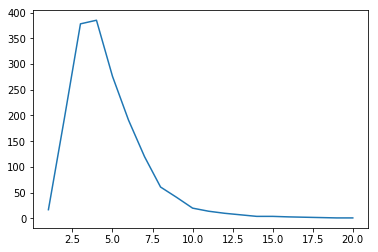

In [45]:
result.q_num_tokens.value_counts().sort_index().plot()

In [54]:
result_short = pd.DataFrame(result[result.q_num_tokens<=10])

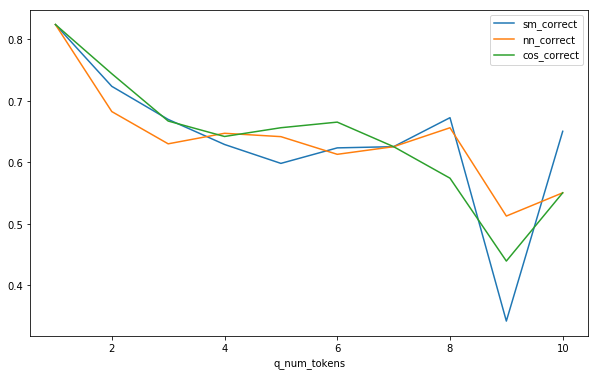

In [67]:
result_short['sm_correct'] = result_short[['exp_q', 'sm_stan_q']].apply(lambda x: x[0]==x[1], axis=1)
result_short['nn_correct'] = result_short[['exp_q', 'nn_stan_q']].apply(lambda x: x[0]==x[1], axis=1)
result_short['cos_correct'] = result_short[['exp_q', 'cos_stan_q']].apply(lambda x: x[0]==x[1], axis=1)

plt.figure(figsize=(10,6))
result_short.groupby('q_num_tokens')['sm_correct'].mean().plot(label='sm_correct')
result_short.groupby('q_num_tokens')['nn_correct'].mean().plot(label='nn_correct')
result_short.groupby('q_num_tokens')['cos_correct'].mean().plot(label='cos_correct')
plt.legend()
plt.show()

In [218]:
# three methods agree
consensus = result[ (result.sm_stan_q==result.nn_stan_q) & (result.sm_stan_q==result.cos_stan_q)  ]
print(consent.shape)
print( (consensus.sm_stan_q==consensus.exp_q).mean())
display(consensus[consensus.sm_stan_q!=consensus.exp_q])

(1162, 12)
0.7831325301204819


,q,exp_q,sm_sim_q,sm_stan_q,sm_score,nn_sim_q,nn_stan_q,nn_score,cos_sim_q,cos_stan_q,cos_score,major_stan_q
q_id,,,,,,,,,,,,
3,能 更改 开 发票,发票信息是否可以更改,能 更改 发票,电子发票和普通纸质发票怎么互换,0.79,能 更改 发票,电子发票和普通纸质发票怎么互换,1.0,能 更改 发票,电子发票和普通纸质发票怎么互换,0.932,电子发票和普通纸质发票怎么互换
4,怎么 物流,查询送货动态,怎么 物流,查询送货,1.00,怎么 物流,查询送货,1.0,怎么 物流,查询送货,1.000,查询送货
14,发票 更改 成 电子发票,发票类型是否可以更改,电子发票 更改 成 发票,电子发票和普通纸质发票怎么互换,1.00,电子发票 更改 成 发票,电子发票和普通纸质发票怎么互换,1.0,电子发票 更改 成 发票,电子发票和普通纸质发票怎么互换,0.733,电子发票和普通纸质发票怎么互换
32,问时间 到货 问时间 买,下单多久发货,问时间 买 问时间 到货,什么时候送,1.00,问时间 买 问时间 到货,什么时候送,1.0,我 知道 问时间 到货 能 买,什么时候送,0.725,什么时候送
43,我 订单 没有 发货,查询送货动态,订单 为什么 没有 发货,为什么还没送到,0.79,订单 为什么 没有 发货,为什么还没送到,1.0,我 订单 能 发货,为什么还没送到,0.850,为什么还没送到
48,这些 订单 我 没有 自提,查询送货动态,我 订单 要是 自提,怎么自提,0.69,我 订单 要是 自提,怎么自提,1.0,我 订单 要是 自提,怎么自提,0.743,怎么自提
49,有 订单 已经 到 系统 说 待 到,订单没有物流信息,订单 说 待 评价了 我 没有 到,为什么未收货却显示送货完成了,0.51,订单 说 待 评价了 我 没有 到,为什么未收货却显示送货完成了,1.0,怎么 已经 说 到,为什么未收货却显示送货完成了,0.591,为什么未收货却显示送货完成了
55,能 取消 拼团 订单,怎么取消订单,乐拼购 取消 订单,乐拼购可以申请退货么,0.87,乐拼购 取消 订单,乐拼购可以申请退货么,1.0,乐拼购 取消 订单,乐拼购可以申请退货么,0.713,乐拼购可以申请退货么
65,我 能 退款 重新 下 订单,可以重新下单吗,半天 不 退款 我 没法 重新 下 订单 支付,多久了怎么还没退款,0.54,半天 不 退款 我 没法 重新 下 订单 支付,多久了怎么还没退款,1.0,半天 不 退款 我 没法 重新 下 订单 支付,多久了怎么还没退款,0.561,多久了怎么还没退款


In [202]:
# three methods all miss
miss = result[ (result.sm_stan_q!=result.exp_q) & (result.nn_stan_q!=result.exp_q) & (result.cos_stan_q!=result.exp_q)  ]
print(miss.shape)
display(miss.sample(n=50))

(445, 12)


In [123]:
nn_wrong = result[(result.nn_stan_q!=result.exp_q)][['q', 'exp_q', 'nn_sim_q', 'nn_stan_q', 'nn_score']]
print(nn_wrong.shape)
display(nn_wrong.sample(n=50))

(631, 5)


In [ ]:
cos_conf = result[result.cos_score>0.5]
cos_conf_miss = cos_conf[cos_conf.cos_stan_q!=cos_conf.exp_q]
print(cos_conf_miss.shape)
display(cos_conf_miss.sample(n=50))

In [204]:
result.head()

,q,exp_q,sm_sim_q,sm_stan_q,sm_score,nn_sim_q,nn_stan_q,nn_score,cos_sim_q,cos_stan_q,cos_score,major_stan_q
q_id,,,,,,,,,,,,
1,问地点 领 券,在哪里领券,问地点 领 券,在哪里领券,1.00,问地点 领 券,在哪里领券,1.0,问地点 领 券,在哪里领券,1.000,在哪里领券
2,电子发票 下载,电子发票怎么下载（无下载按钮怎么办）,电子发票 下载,电子发票怎么下载（无下载按钮怎么办）,1.00,电子发票 下载,电子发票怎么下载（无下载按钮怎么办）,1.0,电子发票 下载,电子发票怎么下载（无下载按钮怎么办）,1.000,电子发票怎么下载（无下载按钮怎么办）
3,能 更改 开 发票,发票信息是否可以更改,能 更改 发票,电子发票和普通纸质发票怎么互换,0.79,能 更改 发票,电子发票和普通纸质发票怎么互换,1.0,能 更改 发票,电子发票和普通纸质发票怎么互换,0.932,电子发票和普通纸质发票怎么互换
4,怎么 物流,查询送货动态,怎么 物流,查询送货,1.00,怎么 物流,查询送货,1.0,怎么 物流,查询送货,1.000,查询送货
5,修改 订单,怎么修改收货人地址、电话,我 订单 能 修改,怎么修改收货人地址、电话,0.69,我 订单 能 修改,怎么修改收货人地址、电话,1.0,修改 物流 订单,怎么修改收货人地址、电话,0.784,怎么修改收货人地址、电话


In [74]:
either_wrong = result[ (result.nn_stan_q != result.expect_q) | (result.sm_stan_q != result.expect_q) ]
both_same_butWrong = result[ (result.nn_stan_q != result.expect_q) & (result.sm_stan_q == result.nn_stan_q) ]
diff_pred = result[ (result.nn_stan_q != result.sm_stan_q)  ]
both_wrong = result[ (result.nn_stan_q != result.expect_q) & (result.sm_stan_q != result.expect_q) ]

In [76]:
either_wrong.to_excel('either_wrong.xlsx', index=False, encoding='utf-8-sig')
both_same_butWrong.to_excel('both_same_butWrong.xlsx', index=False, encoding='utf-8-sig')
diff_pred.to_excel('diff_pred.xlsx', index=False, encoding='utf-8-sig')
both_wrong.to_excel('both_wrong.xlsx', index=False, encoding='utf-8-sig')

In [77]:
diff_pred.sample(n=20)

,q,expect_q,nn_sim_q,nn_stan_q,nn_score,sm_sim_q,sm_stan_q,sm_score,new_stan_q
q_id,,,,,,,,,
1815,我 能 撤 拼 单,更改拼团状态,不能 拼 单,为什么拼团失败,1.000,刚才 拼 团 我 不 拼 能 退换货 单,乐拼购可以申请退货么,0.42,乐拼购可以申请退货么
1669,现在 买 问时间 能 安装,怎么预约安装,现在 能 来 安装,怎么预约安装,1.000,问时间 买 问时间 物流 安装,什么时候送,0.66,什么时候送
1750,是 14.9元 2件,商品价格多少钱,2件 5折,什么是满2件5折,1.000,2件 198元,商品价格多少钱,0.67,商品价格多少钱
190,不是 苏宁 自营,商品是自营的么,不是 苏宁 自营 机子 是 苏宁 物流,送货用什么快递,1.000,这些 不是 自营,商品是自营的么,0.63,商品是自营的么
1130,分期 订单 退款 手续费 怎么 算,分期付款的退货有手续费吗,任性付 分期 手续费 怎么 算,任性付手续费多少,1.000,分期 退款 有 手续费,分期付款的退货有手续费吗,0.53,分期付款的退货有手续费吗
1592,要 运费,运费多少,我 要 退换货 运费,怎么退运费,1.000,怎么 要 运费,运费多少,0.84,运费多少
607,怎么 重新 拍 不了,可以重新下单吗,填 错 单 取消 怎么 拍 不了,可以重新下单吗,1.000,怎么 我 拍 不了,无法下单购买怎么回事,0.73,无法下单购买怎么回事
879,安装 要 另外 收 价格,安装如何收费,安装 工具 要 另外 加 价格,安装如何收费,1.000,安装 多 收 价格,安装乱收费怎么办,0.72,安装乱收费怎么办
1961,出现 故障 怎么 办,申请售后,出现 故障 安排 下 维修,如何预约维修,1.000,苏宁 租 机 手机 出现 故障 怎么,苏宁租机的手机出现质量问题怎么办,0.50,苏宁租机的手机出现质量问题怎么办


In [133]:
result[ (result.nn_stan_q==result.expect_q) & (result.sm_stan_q!=result.expect_q)  ]

,q,expect_q,nn_sim_q,nn_stan_q,nn_score,sm_sim_q,sm_stan_q,sm_score,new_stan_q,nn_maj,nn_maj_q
q_id,,,,,,,,,,,
3,能 更改 开 发票,发票信息是否可以更改,能 更改 发票 税号,发票信息是否可以更改,1.0,能 更改 发票,电子发票和普通纸质发票怎么互换,0.79,发票信息是否可以更改,发票信息是否可以更改,发票信息是否可以更改
8,现在 支付 不能 是 2899,有没有活动，价格能优惠吗,现在 不能 价格 给我,有没有活动，价格能优惠吗,1.0,不能 支付 是,支付为什么显示失败,0.74,有没有活动，价格能优惠吗,支付为什么显示失败,支付为什么显示失败
21,怎么 问时间 还是 不能 买,支付为什么显示失败,怎么 不能 点 击 买,支付为什么显示失败,1.0,我 再 买 怎么 不能 买,可以买多少,0.59,支付为什么显示失败,可以买多少,可以买多少
23,我 发票 你 给我 开 哪 去,怎么没有发票,我 备注 要 开 发票 麻烦 给我,怎么没有发票,1.0,我 你 发票 是 怎么 开,怎么开发票,0.69,怎么没有发票,怎么开发票,怎么开发票
62,39280708466 我 你 单 毛 不能 支付,支付为什么显示失败,我 购物车 有 手机 单 点 支付 老是 不能 支付,支付为什么显示失败,1.0,你 不能 支付宝 支付,支持支付宝或微信支付吗,0.53,支付为什么显示失败,支付为什么显示失败,支付为什么显示失败
72,我 订单 取消,怎么取消订单,我 把 订单 取消,怎么取消订单,1.0,为什么 取消 我 订单,订单被自动取消了,0.85,订单被自动取消了,订单被自动取消了,订单被自动取消了
93,订单 能 用 多少 张 券,券怎么使用,买 能 用 券,券怎么使用,1.0,订单 取消 券 能 用,退款后多久退优惠券/云钻？,0.66,券怎么使用,券怎么使用,券怎么使用
99,我 申请 退换货 麻烦 问时间 通过,咨询退换货进度,退换货 申请 问时间 审核 通过,咨询退换货进度,1.0,麻烦 问时间 我 退换货,申请退换货,0.75,咨询退换货进度,咨询退换货进度,咨询退换货进度
105,货 收 开 发票 过来,怎么没有发票,发票 问时间 送 过来,怎么没有发票,1.0,货 到 增值税 发票 怎么 开,怎么开增值税专用发票,0.54,怎么没有发票,怎么没有发票,怎么没有发票


In [134]:
result[ (result.nn_stan_q!=result.expect_q) & (result.sm_stan_q==result.expect_q)  ]

,q,expect_q,nn_sim_q,nn_stan_q,nn_score,sm_sim_q,sm_stan_q,sm_score,new_stan_q,nn_maj,nn_maj_q
q_id,,,,,,,,,,,
42,修改 问地点,怎么修改收货人地址、电话,怎么 修改 退换货 问地点,怎么更改退换货地址电话和时间,1.0,自助 修改 问地点,怎么修改收货人地址、电话,0.82,怎么修改收货人地址、电话,能否修改默认地址,能否修改默认地址
50,我 订单 怎么 到 现在 都 没有 物流,订单没有物流信息,物流 时 都 没有,什么时候送,1.0,订单 没有 物流,订单没有物流信息,0.61,什么时候送,什么时候送,什么时候送
58,我 电池 有 单买,商品是否有货,怎么 没有 电池,商品缺少配件怎么办,1.0,你家 有 三星 电池,商品是否有货,0.41,商品缺少配件怎么办,如何预约维修,如何预约维修
68,到底 是 苏宁 发货 不,从哪里发货,是 苏宁 物流 是否 不 发货 物流,送货用什么快递,1.0,是 苏宁 发货,从哪里发货,0.76,送货用什么快递,送货用什么快递,送货用什么快递
80,取消 能够 更改 我 要,撤回退换货申请,要 取消 订单 能 更改 支付,支付方式是否可以修改,1.0,我 定 取消 能 更改 回来,撤回退换货申请,0.50,支付方式是否可以修改,延保怎么退,延保怎么退
81,更改 问地点,怎么修改收货人地址、电话,我 更改 默认 问地点,能否修改默认地址,1.0,更改 到 问地点,怎么修改收货人地址、电话,0.81,怎么修改收货人地址、电话,怎么修改收货人地址、电话,怎么修改收货人地址、电话
96,更换 手机 外 屏,如何预约维修,想买 大 屏 手机,帮我推荐下手机、配件,1.0,我 手机 外 屏 破 怎么 修,如何预约维修,0.42,帮我推荐下手机、配件,申请退换货,申请退换货
117,我 刚 下 一 单 手机 我 发票 信息 写 错 怎么 修改,发票信息是否可以更改,发票 信息 怎么 填 写,如何设置发票信息,1.0,我 发票 有 字 写 错 怎么,发票信息是否可以更改,0.47,如何设置发票信息,发票信息是否可以更改,发票信息是否可以更改
139,问时间 前 买 299 现在 降 30,怎么申请价保,399 应该 降 30,为什么参加满减没有减少,1.0,现在 降,怎么申请价保,0.58,为什么参加满减没有减少,怎么申请价保,怎么申请价保


In [136]:
result[ (result.nn_stan_q!=result.expect_q)].sample(n=25)

,q,expect_q,nn_sim_q,nn_stan_q,nn_score,sm_sim_q,sm_stan_q,sm_score,new_stan_q,nn_maj,nn_maj_q
q_id,,,,,,,,,,,
266,能 店 自提,怎么自提,店 自提 能 店 支付,怎么门店付款,1.0,能 店 自提,怎么自提,1.00,怎么自提,怎么自提,怎么自提
50,我 订单 怎么 到 现在 都 没有 物流,订单没有物流信息,物流 时 都 没有,什么时候送,1.0,订单 没有 物流,订单没有物流信息,0.61,什么时候送,什么时候送,什么时候送
1547,东西 到 但是 没有 礼品,赠品配送问题,东西 到 没有 发票,怎么没有发票,1.0,我 买 东西 没有 到,为什么还没送到,0.49,怎么没有发票,怎么没有发票,怎么没有发票
1676,退换货 要 上门 取件,退换货是要邮寄还是上门取件,退换货 上门 取件,咨询退换货进度,1.0,退换货 上门 取件,咨询退换货进度,0.91,咨询退换货进度,咨询退换货进度,咨询退换货进度
1553,怎么 免运费,运费多少,怎么 免运费,运费券怎么领取,1.0,怎么 免运费,运费券怎么领取,1.00,运费券怎么领取,运费多少,运费多少
1093,双卡双待 是什么,双卡双待单通是什么意思,双卡双待 是什么,手机双卡多模跟双卡双待的有什么区别,1.0,双卡双待 是什么,手机双卡多模跟双卡双待的有什么区别,0.81,手机双卡多模跟双卡双待的有什么区别,双卡双待单通是什么意思,双卡双待单通是什么意思
188,卖家 已经 核实 价格 已经 退换货 给我 我 能 申请 运费,退换货有取件费用吗,我 申请 退换货 运费 退换货 给我,退款后多久退优惠券/云钻？,1.0,我 申请 退换货 运费 退换货 给我,退款后多久退优惠券/云钻？,0.57,退款后多久退优惠券/云钻？,怎么退运费,怎么退运费
598,延保 是 怎么,延保服务都可以保哪些问题的,延保 是,延保如何购买,1.0,怎么 延保,延保如何购买,0.76,延保如何购买,延保如何购买,延保如何购买
1436,支付宝 不能 买,支付宝可以支付吗,app 怎么 不能 支付宝 买,支持支付宝或微信支付吗,1.0,app 怎么 不能 支付宝 买,支持支付宝或微信支付吗,0.77,支持支付宝或微信支付吗,支付宝可以支付吗,支付宝可以支付吗


## Response Sim

In [ ]:
temp_df = pd.read_csv("samples_tokenized.csv", header=None)
temp_df.columns = ['s']

In [67]:
response_df = pd.DataFrame()

In [68]:
response_df['s1'] = temp_df[temp_df.index%2==0].reset_index(drop=True)['s']
response_df['s2'] = temp_df[temp_df.index%2==1].reset_index(drop=True)['s']
response_df['true_label'] = pd.Series(np.append( [2]*16, [[0]*16, [0]*16]).astype(int))

In [72]:
def label_temp(pred, ths):
    if pred<ths[0]:
        return 0
    elif pred<ths[1]:
        return 0
    else:
        return 2
response_df['tfidf_sim'] = response_df[['s1','s2']].apply(lambda x: label_temp(TF_IDF_predict(x[0], x[1]), [0.2,0.3]), axis=1)
response_df['avg_embed_sim'] = response_df[['s1','s2']].apply(lambda x: label_temp(avg_embedding_predict(x[0],x[1]), [0.3,0.6]), axis=1)
response_df['idf_embed_sim'] = response_df[['s1','s2']].apply(lambda x: label_temp(IDF_embedding_predict(x[0], x[1]), [0.3,0.4]), axis=1)
response_df['net_sim'] = response_df[['s1','s2']].apply(lambda x: 2 if test_onePair([x[0]], [x[1]])>=1 else 0, axis=1)

In [79]:
display(response_df)

,s1,s2,true_label,tfidf_sim,avg_embed_sim,idf_embed_sim,net_sim
0,建议 你 可以 提前 拨 打 预约 安装,﻿下单 时 可以 确认 安装 服务 方 下单 通过 以下 链接 确认 服务 信息 预约 更改 服务 时间 商家 安装 问题 优先 联系 商家 客服,2,0,2,2,2
1,﻿不 客气 亲爱 哒,﻿不 客气 亲爱 哒 很 高兴 服务 感谢 对 苏宁 易购 支持 对 我 服务 满意 记 给我 赞,2,2,0,2,0
2,﻿苏宁 配送 商 点 击 自助 修改 配送 信 息,﻿苏宁 发货 可以 自主 修改 指定 送达时间 在线 支付 最多 延迟 45天 货到付款 最多 延迟 7天 点 击 修改 非 苏宁 发货 商品 建议 联系 购买 页面 在线客服 修改,2,0,0,2,2
3,﻿商品 发货 出 库 但是 最近 几天 做 活动 单 量 比较 多 送货 有些 慢 送货 时间 会 有所 延迟 但是 放心 物流 在 加急 安排 拣 货 和 配送 到 站 优先 送 辛苦,﻿通过 点 击 查询 物流 苏宁 发货 商品 24小时 内 发货 非 苏宁 发货 商品 48小时 内 发货 实际 送达时间,2,0,2,2,0
4,﻿最近 几天 做 活动 单 量 比较 多 送货 有些 慢 送货 时间 会 有所 延迟 但是 放心 物流 在 加急 安排 拣 货 和 配送 到 站 优先 送 辛苦,﻿苏宁 发货 商品 页面 会 显示 预计 到达 时间 提交 订单 时 显示 时间 下单 按照 指定 日期 配送 非 苏宁 发货 商品 下单 在 48小时 内 发货 快递 信息 点 击 查询 当...,2,0,2,2,2
5,﻿苏宁 易购 所 出售 商品 均 正 品行 货 放心 选购,﻿苏宁 易购 所 出售 商品 均 正 品行 货 均 来自 正规 渠道 带 正规 机 打 发票 享受 国家 三包 服务 质量 和 售后服务 与 门店 完全 相同 放心 选购,2,2,2,2,2
6,﻿有 统一 全国 售后服务 正品 质量 保证,﻿苏宁 易购 与 天猫 苏宁 官方 旗舰 店 只是 销售 平台 不同 但 均 苏宁 销售 并发 货 有 统一 全国 售后服务 正品 质量 保证,2,2,2,2,2
7,﻿苏宁 发货 商品 下单 填写 地址 时 能 正常 保存 在 配送 范围 内 支持 送货上门 服务,﻿苏宁 发货 商品 下单 填写 地址 时 能 正常 保存 在 配送 范围 内 支持 送货上门 服务 非 苏宁 发货 商品 建议 联系 面上 在线客服 确定 配送 范围,2,2,2,2,2
8,﻿7天 之 内 只 要 符合 条 件 可以 进行 补差,﻿在 苏宁 易购 购买 自营商品 收货 前 收货 次日 起 七天 内 发现 同一 城市 同一 销售 渠道 商品 售价 低于 购买 时 价格 提交 七天 贵就赔 申请 苏宁 将 依据 本 政策 ...,2,0,0,2,2
9,﻿苏宁 在线 支付 立减 金额 随机 最高 100元 最低 0元,﻿绑定 银行卡 首次 支付 在 提交 订单 支付 时 会有 提示 显示 减价 任性付 支付 立减 立减 金额 随机 最高 100元 最低 0元 立减 0元 说明 此次 优惠 没有 获得 优惠 ...,2,2,2,2,2


In [ ]:
eval_plot(response_df['tfidf_sim'], response_df['true_label'])

Confusion matrix, without normalization
[[22 10]
 [ 6 10]]
Normalized confusion matrix
[[0.6875 0.3125]
 [0.375  0.625 ]]


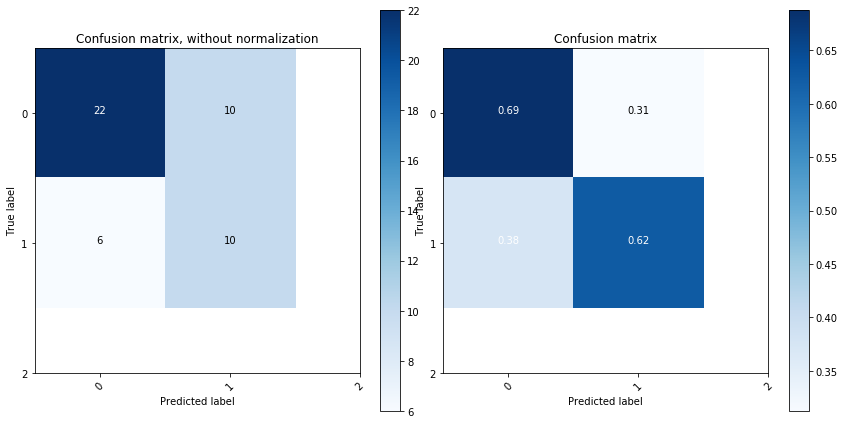

In [251]:
eval_plot(response_df['avg_embed_sim'], response_df['true_label'])

Confusion matrix, without normalization
[[19 13]
 [ 2 14]]
Normalized confusion matrix
[[0.59375 0.40625]
 [0.125   0.875  ]]


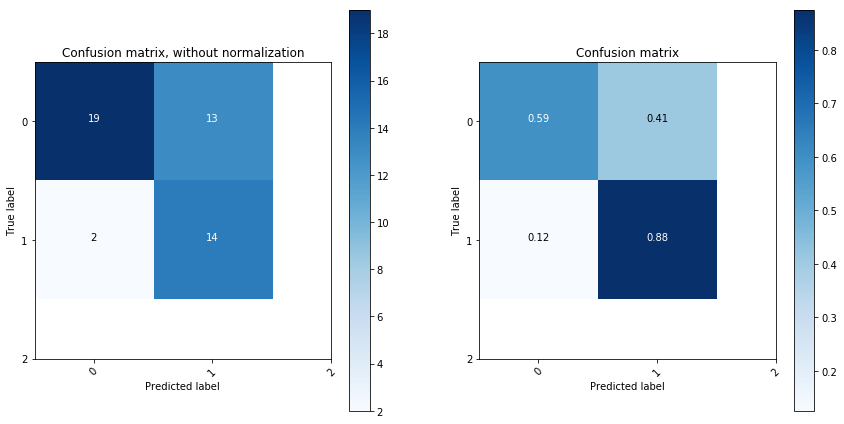

In [77]:
eval_plot(response_df['idf_embed_sim'], response_df['true_label'])

Confusion matrix, without normalization
[[22 10]
 [ 4 12]]
Normalized confusion matrix
[[0.6875 0.3125]
 [0.25   0.75  ]]


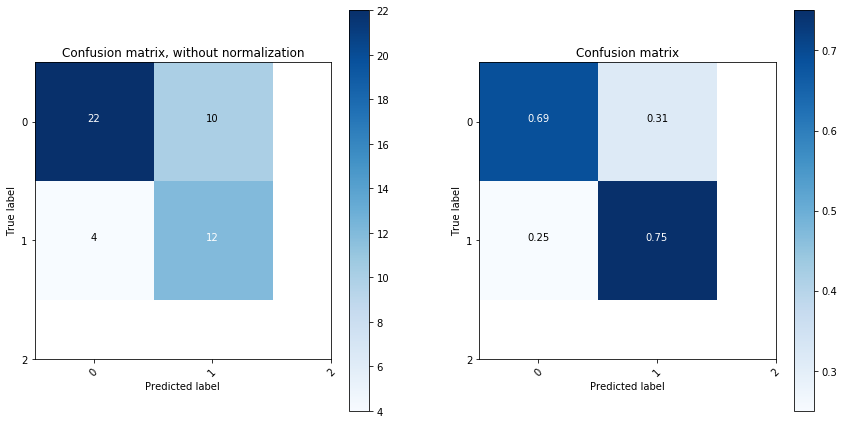

In [78]:
eval_plot(response_df['net_sim'], response_df['true_label'])